<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_true_crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA and processing

Parse timestamps → hour, weekday, month, holidays; derive rolling counts (7‑day, 28‑day), “seasonality” flags.

Spatialize: snap lat/long to H3/grid; compute neighbor stats (local mean, recent bursts).

Clean weird coords, coarse addresses, and duplicates; keep a “data issues” log (0°,0° cases and imprecise blocks)

**Importing Libraries & Dependencies**

In [30]:
# Install dependencies (specific versions for reproducibility)
!pip -q install h3==3.7.6 holidays==0.41 dcor==0.6 seaborn==0.13.2 folium==0.17.0

# Standard libraries
import os, re, math, json, warnings
warnings.filterwarnings("ignore")

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Date/time & holidays
from datetime import datetime
from holidays import US as USHolidays

# Statistics & dependencies
import dcor

# Machine learning / preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mutual_info_score
from sklearn.cluster import DBSCAN

# Set default style for plots
sns.set(style="whitegrid")
plt.style.use("seaborn-v0_8")


In [31]:
# ==== USER CONFIG ====
CSV_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip"
H3_RES   = 8  # ~0.74km2 cells; 8–9 is a good start for city-scale

# LA-ish bounding box to catch weird coords
LAT_MIN, LAT_MAX = 33.2, 34.9
LON_MIN, LON_MAX = -119.2, -117.4

# Unique-threshold for cat/num split
CATEGORICAL_MAX_UNIQUE = 20

# For rolling counts
ROLL_WINDOWS = [7, 28]  # in days
df = pd.read_csv(CSV_PATH, low_memory=False)
df.head()

DR_NO           Date_Reported            Date_occured  Time_occured  \
0  190326475           03/01/20 0:00           03/01/20 0:00          2130   
1  200106753           02/09/20 0:00           02/08/20 0:00          1800   
2  200320258           11/11/20 0:00           11/04/20 0:00          1700   
3  200907217           05/10/23 0:00           03/10/20 0:00          2037   
4  220614831  08/18/2022 12:00:00 AM  08/17/2020 12:00:00 AM          1200   

        Area                                Crime_Code  Victim_age Victim_sex  \
0   Wilshire                          VEHICLE - STOLEN           0          M   
1    Central                     BURGLARY FROM VEHICLE          47          M   
2  Southwest                             BIKE - STOLEN          19          X   
3   Van Nuys  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)          19          M   
4  Hollywood                         THEFT OF IDENTITY          28          M   

  Victim_descent                                        Premis Weapon  \
0              O                                        STREET    NaN   
1              O             BUS STOP/LAYOVER (ALSO QUERY 124)    NaN   
2              X  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    NaN   
3              O                                CLOTHING STORE    NaN   
4              H                                      SIDEWALK    NaN   

         Status                                  LOCATION      LAT       LON  
0  Adult Arrest   1900 S  LONGWOOD                     AV  34.0375 -118.3506  
1   Invest Cont   1000 S  FLOWER                       ST  34.0444 -118.2628  
2   Invest Cont   1400 W  37TH                         ST  34.0210 -118.3002  
3   Invest Cont  14000    RIVERSIDE                    DR  34.1576 -118.4387  
4   Invest Cont                         1900    TRANSIENT  34.0944 -118.3277

In [32]:
df = df.drop('DR_NO', axis=1)

df.head()

Date_Reported            Date_occured  Time_occured       Area  \
0           03/01/20 0:00           03/01/20 0:00          2130   Wilshire   
1           02/09/20 0:00           02/08/20 0:00          1800    Central   
2           11/11/20 0:00           11/04/20 0:00          1700  Southwest   
3           05/10/23 0:00           03/10/20 0:00          2037   Van Nuys   
4  08/18/2022 12:00:00 AM  08/17/2020 12:00:00 AM          1200  Hollywood   

                                 Crime_Code  Victim_age Victim_sex  \
0                          VEHICLE - STOLEN           0          M   
1                     BURGLARY FROM VEHICLE          47          M   
2                             BIKE - STOLEN          19          X   
3  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)          19          M   
4                         THEFT OF IDENTITY          28          M   

  Victim_descent                                        Premis Weapon  \
0              O                                        STREET    NaN   
1              O             BUS STOP/LAYOVER (ALSO QUERY 124)    NaN   
2              X  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    NaN   
3              O                                CLOTHING STORE    NaN   
4              H                                      SIDEWALK    NaN   

         Status                                  LOCATION      LAT       LON  
0  Adult Arrest   1900 S  LONGWOOD                     AV  34.0375 -118.3506  
1   Invest Cont   1000 S  FLOWER                       ST  34.0444 -118.2628  
2   Invest Cont   1400 W  37TH                         ST  34.0210 -118.3002  
3   Invest Cont  14000    RIVERSIDE                    DR  34.1576 -118.4387  
4   Invest Cont                         1900    TRANSIENT  34.0944 -118.3277

In [33]:
def parse_datetime(row):
    # Many LAPD datasets store date and separate HHMM int.
    # Handle strings like "01/31/2020" and time like 1345 (1:45 PM).
    d = row.get("date_occ")
    t = row.get("time_occ")
    if pd.isna(d):
        return pd.NaT
    # try several formats
    for fmt in ("%m/%d/%Y", "%m/%d/%Y %H:%M:%S", "%Y-%m-%d", "%m/%d/%y"):
        try:
            base = pd.to_datetime(d, format=fmt, errors="raise")
            break
        except Exception:
            base = pd.NaT
    if pd.isna(base):
        return pd.NaT
    # time as HHMM integer (e.g., 30, 830, 2230)
    if pd.notna(t):
        try:
            t = int(t)
            hh = int(t // 100)
            mm = int(t % 100)
            base = base + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")
        except Exception:
            pass
    return base

df["dt_occ"] = df.apply(parse_datetime, axis=1)
df["date"] = df["dt_occ"].dt.date # Extract the date part here

# seasonality / calendar
us_holidays = USHolidays()  # federal+common
df["hour"] = df["dt_occ"].dt.hour
df["weekday"] = df["dt_occ"].dt.weekday  # 0=Mon
df["month"] = df["dt_occ"].dt.month
df["weekofyear"] = df["dt_occ"].dt.isocalendar().week.astype("Int64")
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)
df["is_holiday"] = df["date"].isin(pd.to_datetime(list(us_holidays.keys()))).astype(int)
df["dayofyear"] = df["dt_occ"].dt.dayofyear
df["quarter"] = df["dt_occ"].dt.quarter

# simple seasonality tags (feel free to adjust ranges)
df["season"] = pd.cut(df["month"],
                      bins=[0,2,5,8,11,12],
                      labels=["Winter","Spring","Summer","Fall","Winter2"],
                      include_lowest=True)

In [34]:
# FIX: Your date column is empty - let's fix it and regenerate features

print("=== FIXING DATE ISSUES ===\n")

# Check what date columns actually contain data
print("1. Checking available date columns:")
date_columns = ['Date_Reported', 'Date_occured', 'dt_occ', 'date']
for col in date_columns:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"{col}: {non_null} non-null values")
        if non_null > 0:
            print(f"  Sample values: {df[col].dropna().head(3).tolist()}")

# Use dt_occ (which seems to have datetime data) or Date_occured
print("\n2. Using dt_occ as the primary date column:")
if 'dt_occ' in df.columns and df['dt_occ'].notna().sum() > 0:
    # Use dt_occ which is already datetime
    df['date'] = df['dt_occ']
    print("✅ Using dt_occ column")
elif 'Date_occured' in df.columns and df['Date_occured'].notna().sum() > 0:
    # Parse Date_occured
    df['date'] = pd.to_datetime(df['Date_occured'], errors='coerce')
    print("✅ Using Date_occured column")
else:
    print("❌ No valid date columns found!")

# Remove rows with invalid dates
initial_count = len(df)
df = df.dropna(subset=['date'])
print(f"\n3. Filtered dataset: {initial_count} → {len(df)} rows")

# Regenerate time features from the correct date column
print("\n4. Regenerating time features:")
# Fix hour extraction - your hours are all zeros
# If you have a Time_occured column with time info:
if 'Time_occured' in df.columns:
    # Convert time to hours (assuming Time_occured is in HHMM format like 1430 for 2:30 PM)
    df['hour'] = (df['Time_occured'] // 100) % 24
    print(f"Hour range after fix: {df['hour'].min()} to {df['hour'].max()}")
    print(f"Unique hours: {df['hour'].nunique()}")

df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Hour range: {df['hour'].min()} to {df['hour'].max()}")
print(f"Weekday range: {df['weekday'].min()} to {df['weekday'].max()}")

print("\n5. ✅ READY TO RERUN YOUR PLOTTING CODE!")

# Test the daily aggregation now
daily_test = df.groupby("date").size()
print(f"\nDaily aggregation now has {len(daily_test)} days of data")
print(f"Sample daily counts:\n{daily_test.head()}")

=== FIXING DATE ISSUES ===

1. Checking available date columns:
Date_Reported: 974477 non-null values
  Sample values: ['03/01/20 0:00', '02/09/20 0:00', '11/11/20 0:00']
Date_occured: 974477 non-null values
  Sample values: ['03/01/20 0:00', '02/08/20 0:00', '11/04/20 0:00']
dt_occ: 0 non-null values
date: 0 non-null values

2. Using dt_occ as the primary date column:
✅ Using Date_occured column

3. Filtered dataset: 974477 → 974477 rows

4. Regenerating time features:
Hour range after fix: 0 to 23
Unique hours: 24
Date range: 2020-01-01 00:00:00 to 2024-09-02 00:00:00
Hour range: 0 to 23
Weekday range: 0 to 6

5. ✅ READY TO RERUN YOUR PLOTTING CODE!

Daily aggregation now has 1707 days of data
Sample daily counts:
date
2020-01-01    1153
2020-01-02     527
2020-01-03     595
2020-01-04     541
2020-01-05     505
dtype: int64


In [35]:
issues = []

# Coerce lat/lon
for c in ("lat","lon"):
    if c in df:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Bad coords: missing or (0,0) or out-of-bounds
bad_zero = ((df["lat"]==0) & (df["lon"]==0)).sum() if {"lat","lon"}.issubset(df.columns) else 0
issues.append({"issue":"zero_zero_coords","count":int(bad_zero)})

bad_bounds = 0
if {"lat","lon"}.issubset(df.columns):
    mask_bounds = ~df["lat"].between(LAT_MIN,LAT_MAX) | ~df["lon"].between(LON_MIN,LON_MAX)
    bad_bounds = mask_bounds.sum()
    issues.append({"issue":"outside_LA_bbox","count":int(bad_bounds)})
    df.loc[mask_bounds | ((df["lat"]==0)&(df["lon"]==0)), ["lat","lon"]] = np.nan

# Coarse/odd addresses (very dataset-dependent; here we flag obviously imprecise strings)
addr_issues = 0
if "address" in df:
    coarse_mask = df["address"].astype(str).str.contains(r"\b\d{1,3}00\s+BLK\b", case=False, na=False)
    addr_issues = coarse_mask.sum()
    issues.append({"issue":"coarse_block_addresses","count":int(addr_issues)})

# Duplicates by DR number (if present)
dups = 0
if "dr_no" in df:
    dups = df["dr_no"].duplicated(keep=False).sum()
    issues.append({"issue":"duplicate_DR_NO_rows","count":int(dups)})

issues_log = pd.DataFrame(issues)
issues_log


issue  count
0  zero_zero_coords      0

In [36]:
from h3 import h3

# Generate H3 index from LAT and LON
if {"LAT", "LON"}.issubset(df.columns):
    # Ensure LAT and LON are numeric and handle potential NaNs
    df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
    df["LON"] = pd.to_numeric(df["LON"], errors="coerce")

    # Generate h3 index, handling NaNs in LAT/LON
    df["h3"] = df.apply(
        lambda row: h3.geo_to_h3(row["LAT"], row["LON"], H3_RES)
        if pd.notna(row["LAT"]) and pd.notna(row["LON"])
        else None,
        axis=1,
    )
    print(f"Generated H3 index at resolution {H3_RES}")
else:
    print("LAT or LON column not found. Cannot generate H3 index.")
    # Create an empty h3 column to prevent further errors if LAT/LON are missing
    df["h3"] = None


# --- Daily counts per cell (with continuous dates) ---
cell_daily = (
    df.dropna(subset=["h3","date"])
      .groupby(["h3","date"])
      .size()
      .rename("cnt")
      .reset_index()
)

# For correct rolling windows: reindex each cell onto its full date range (fill missing days with 0)
def make_continuous(g):
    idx = pd.date_range(g["date"].min(), g["date"].max(), freq="D")
    g2 = g.set_index("date").reindex(idx).fillna(0.0).rename_axis("date").reset_index()
    g2["h3"] = g["h3"].iloc[0]
    return g2[["h3","date","cnt"]]

cell_daily = (
    cell_daily.groupby("h3", group_keys=False).apply(make_continuous).reset_index(drop=True)
)

# Rolling features per cell (7d/28d sums)
cell_daily = cell_daily.sort_values(["h3","date"])
for w in ROLL_WINDOWS:
    cell_daily[f"roll_{w}d"] = cell_daily.groupby("h3")["cnt"].transform(
        lambda s: s.rolling(window=w, min_periods=1).sum()
    )

# --- Neighbor stats & burstiness ---
def neighbor_stats(cell_daily, k=1):
    unique_cells = cell_daily["h3"].unique().tolist()
    # k_ring returns a set; use set subtraction to drop self
    neigh_map = {c: list(h3.k_ring(c, k) - {c}) if c == c else [] for c in unique_cells}

    # Pivot date x h3 for fast neighbor means
    pivot = cell_daily.pivot_table(index="date", columns="h3", values="cnt", aggfunc="sum").fillna(0)

    # Compute neighbor mean per column
    neighbor_mean_cols = {}
    cols = pivot.columns
    for c in cols:
        neighs = [n for n in neigh_map.get(c, []) if n in cols]
        if len(neighs) == 0:
            neighbor_mean_cols[c] = pd.Series(0, index=pivot.index)
        else:
            neighbor_mean_cols[c] = pivot[neighs].mean(axis=1)

    neighbor_mean_df = pd.DataFrame(neighbor_mean_cols)
    # FIX: After stacking, 'h3' becomes level 1, not a column
    neighbor_mean_df = (
        neighbor_mean_df.stack()
        .rename("neighbor_mean")
        .reset_index()
        .rename(columns={"level_0": "date", "level_1": "h3"})
    )
    neighbor_mean_df["date"] = pd.to_datetime(neighbor_mean_df["date"])

    out = cell_daily.merge(neighbor_mean_df, on=["date","h3"], how="left")
    out["burstiness"] = out["cnt"] / (1.0 + out["neighbor_mean"])
    return out
cell_daily = neighbor_stats(cell_daily, k=1)

# Attach back to row level (by [h3, date])
df = df.merge(cell_daily, on=["h3","date"], how="left", suffixes=("", "_cell"))
df.head(3)

Generated H3 index at resolution 8


Date_Reported   Date_occured  Time_occured       Area  \
0  03/01/20 0:00  03/01/20 0:00          2130   Wilshire   
1  02/09/20 0:00  02/08/20 0:00          1800    Central   
2  11/11/20 0:00  11/04/20 0:00          1700  Southwest   

              Crime_Code  Victim_age Victim_sex Victim_descent  \
0       VEHICLE - STOLEN           0          M              O   
1  BURGLARY FROM VEHICLE          47          M              O   
2          BIKE - STOLEN          19          X              X   

                                         Premis Weapon  ... is_holiday  \
0                                        STREET    NaN  ...          0   
1             BUS STOP/LAYOVER (ALSO QUERY 124)    NaN  ...          0   
2  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    NaN  ...          0   

  dayofyear  quarter  season               h3  cnt  roll_7d  roll_28d  \
0       NaN      NaN     NaN  8829a1992bfffff  1.0      3.0      15.0   
1       NaN      NaN     NaN  8829a1d62dfffff  7.0     55.0     193.0   
2       NaN      NaN     NaN  8829a1d64bfffff  2.0      8.0      16.0   

   neighbor_mean  burstiness  
0       1.000000    0.500000  
1       3.166667    1.680000  
2       1.166667    0.923077  

[3 rows x 31 columns]

In [37]:
# ====== NAN HANDLING (DOMAIN-AWARE) ======

# 0) helper: safe-exists
def has(c): return c in df.columns

# 1) engineered spatio-temporal features → true zeros (absence of events)
for c in ["cnt","roll_7d","roll_28d","neighbor_mean","burstiness"]:
    if has(c):
        df[c] = df[c].fillna(0.0)

# 2) time fields
# hour may be NA if Time_occured missing → encode as -1 and keep a flag
if has("hour"):
    df["hour_missing"] = df["hour"].isna().astype(int)
    df["hour"] = df["hour"].fillna(-1).astype(int)

# weekday/month/etc. should exist; if not, regenerate from date
if has("date"):
    for c, fn in {
        "weekday": df["date"].dt.weekday,
        "month":   df["date"].dt.month,
        "dayofyear": df["date"].dt.dayofyear,
        "quarter": df["date"].dt.quarter
    }.items():
        if not has(c):
            df[c] = fn
    # holiday/weekend flags default to 0 if missing
    for c in ["is_weekend","is_holiday"]:
        if has(c):
            df[c] = df[c].fillna(0).astype(int)

# 3) victim age cleanup → cap to plausible range, then hierarchical median impute
if has("victim_age"):
    # invalid ages to NaN
    df["victim_age"] = pd.to_numeric(df["victim_age"], errors="coerce")
    df.loc[(df["victim_age"] < 0) | (df["victim_age"] > 110), "victim_age"] = np.nan
    df["victim_age_missing"] = df["victim_age"].isna().astype(int)

    # build coarse crime bucket to use in grouping (e.g., 100s)
    crime_bucket = None
    if has("crime_code"):
        cc = pd.to_numeric(df["crime_code"], errors="coerce")
        crime_bucket = (cc // 100).astype("Int64")

    # hierarchical fill: (sex + crime_bucket) → (sex) → global
    if has("victim_sex") and crime_bucket is not None:
        grp_med = df.groupby(["victim_sex", crime_bucket])["victim_age"].transform("median")
        df["victim_age"] = df["victim_age"].fillna(grp_med)
    if has("victim_sex"):
        grp_med2 = df.groupby("victim_sex")["victim_age"].transform("median")
        df["victim_age"] = df["victim_age"].fillna(grp_med2)
    df["victim_age"] = df["victim_age"].fillna(df["victim_age"].median())

# 4) location: coords may be missing by design → keep NaN, add flags (don’t fabricate)
for c in ["lat","lon"]:
    if has(c):
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[f"{c}_missing"] = df[c].isna().astype(int)

# Optional: try to infer H3 for rows missing it from modal H3 of the same area_name (safe-ish fallback)
if has("h3"):
    df["h3_missing"] = df["h3"].isna().astype(int)
    if has("area_name"):
        mode_by_area = (
            df.dropna(subset=["h3","area_name"])
              .groupby("area_name")["h3"]
              .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
        )
        # only fill H3 where area_name has a very dominant mode (avoid noisy fill)
        area_counts = (df.groupby("area_name")["h3"].nunique())
        strong_areas = area_counts[area_counts == 1].index  # area maps to a single H3 (rare), or tighten as needed
        mask = df["h3"].isna() & df["area_name"].isin(strong_areas)
        df.loc[mask, "h3"] = df.loc[mask, "area_name"].map(mode_by_area)

# 5) categorical codes → explicit "Unknown" + missing flags (keeps info without dropping rows)
cat_fill = ["crime_desc","premise_desc","weapon_desc","victim_sex","victim_descent","area_name"]
for c in cat_fill:
    if has(c):
        df[f"{c}_missing"] = df[c].isna().astype(int)
        df[c] = df[c].fillna("Unknown")

# 6) status / text address — keep “Unknown” to avoid losing rows
for c in ["status","address","LOCATION","location"]:
    if has(c):
        df[f"{c}_missing"] = df[c].isna().astype(int)
        df[c] = df[c].fillna("Unknown")

# 7) modeling-friendly list of numeric/categorical after imputations
num_cols_model = sorted(list(df.select_dtypes(include=[np.number]).columns))
cat_cols_model = sorted([c for c in df.columns if df[c].dtype == "object"])

print("✅ NaN handling done.")
print("Numeric (sample):", num_cols_model[:10], "… total", len(num_cols_model))
print("Categorical (sample):", cat_cols_model[:10], "… total", len(cat_cols_model))


✅ NaN handling done.
Numeric (sample): ['LAT', 'LOCATION_missing', 'LON', 'Time_occured', 'Victim_age', 'burstiness', 'cnt', 'dayofyear', 'h3_missing', 'hour'] … total 20
Categorical (sample): ['Area', 'Crime_Code', 'Date_Reported', 'Date_occured', 'LOCATION', 'Premis', 'Status', 'Victim_descent', 'Victim_sex', 'Weapon'] … total 11


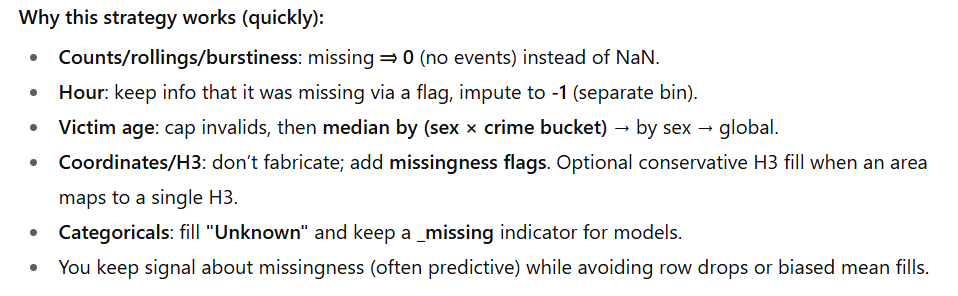

In [38]:
# classify by unique-count rule
num_cols, cat_cols = [], []
for c in df.columns:
    if df[c].dtype.kind in "biufc" and df[c].nunique(dropna=True) > CATEGORICAL_MAX_UNIQUE:
        num_cols.append(c)
    elif df[c].dtype.kind in "O" or df[c].nunique(dropna=True) <= CATEGORICAL_MAX_UNIQUE:
        # treat string-ish or low-unique as categorical
        cat_cols.append(c)

# basic hygiene: drop obvious IDs from modeling features later
id_like = [c for c in ["dr_no"] if c in df.columns]
print("Numerical:", num_cols[:12], "... (total", len(num_cols),")")
print("Categorical:", cat_cols[:12], "... (total", len(cat_cols),")")

# optional one-hot: only for *low-card* categoricals to avoid explosion
LOW_CARD_MAX = 30
low_card = [c for c in cat_cols if df[c].nunique(dropna=True) <= LOW_CARD_MAX]
df_oh = pd.get_dummies(df, columns=low_card, dummy_na=True, drop_first=False)
df_oh.shape


Numerical: ['Time_occured', 'Victim_age', 'LAT', 'LON', 'hour', 'cnt', 'roll_7d', 'roll_28d', 'neighbor_mean', 'burstiness'] ... (total 10 )
Categorical: ['Date_Reported', 'Date_occured', 'Area', 'Crime_Code', 'Victim_sex', 'Victim_descent', 'Premis', 'Weapon', 'Status', 'LOCATION', 'dt_occ', 'weekday'] ... (total 23 )


(974477, 116)

In [39]:
"""# 7.1 Pearson/Spearman on numerics - not interesting at all, it was clearly just very obvious correlations
num_used = [c for c in num_cols if c not in id_like]
num_df = df[num_used].select_dtypes(include=[np.number]).dropna(axis=1, how="all")

plt.figure(figsize=(10,7))
sns.heatmap(num_df.corr(method="pearson"), cmap="coolwarm", center=0)
plt.title("Pearson correlation (numeric)")
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(num_df.corr(method="spearman"), cmap="coolwarm", center=0)
plt.title("Spearman correlation (numeric)")
plt.show()"""
"""
# 7.2 Distance correlation (numeric) - also, no interesting results
def distance_corr_matrix(X: pd.DataFrame):
    cols = X.columns
    n = len(cols)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            xi = X[cols[i]].to_numpy()
            xj = X[cols[j]].to_numpy()
            mask = ~np.isnan(xi) & ~np.isnan(xj)
            dc = dcor.distance_correlation(xi[mask], xj[mask]) if mask.sum()>3 else np.nan
            M[i,j]=M[j,i]=dc
    return pd.DataFrame(M, index=cols, columns=cols)

dc_mat = distance_corr_matrix(num_df.sample(min(8000, len(num_df)), random_state=42))
plt.figure(figsize=(10,7))
sns.heatmap(dc_mat, cmap="viridis")
plt.title("Distance correlation (numeric, non-linear)")
plt.show()"""

'\n# 7.2 Distance correlation (numeric) - also, no interesting results\ndef distance_corr_matrix(X: pd.DataFrame):\n    cols = X.columns\n    n = len(cols)\n    M = np.zeros((n,n))\n    for i in range(n):\n        for j in range(i, n):\n            xi = X[cols[i]].to_numpy()\n            xj = X[cols[j]].to_numpy()\n            mask = ~np.isnan(xi) & ~np.isnan(xj)\n            dc = dcor.distance_correlation(xi[mask], xj[mask]) if mask.sum()>3 else np.nan\n            M[i,j]=M[j,i]=dc\n    return pd.DataFrame(M, index=cols, columns=cols)\n\ndc_mat = distance_corr_matrix(num_df.sample(min(8000, len(num_df)), random_state=42))\nplt.figure(figsize=(10,7))\nsns.heatmap(dc_mat, cmap="viridis")\nplt.title("Distance correlation (numeric, non-linear)")\nplt.show()'

In [40]:
# 7.3 Cramér’s V for categorical
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    if ct.empty: # Add this check
        return np.nan # Return NaN if crosstab is empty
    chi2 = pd.api.types.CategoricalDtype
    from scipy.stats import chi2_contingency
    chi2, p, dof, exp = chi2_contingency(ct, correction=False)
    n = ct.sum().sum()
    phi2 = chi2 / n
    r, k = ct.shape
    # bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))

from itertools import combinations
cats_small = [c for c in cat_cols if df[c].nunique(dropna=True) <= 50]
cv_pairs = {}
for a, b in combinations(cats_small, 2):
    v = cramers_v(df[a], df[b])
    cv_pairs[(a,b)] = v

# show top associations
sorted_cv = sorted(cv_pairs.items(), key=lambda kv: kv[1], reverse=True)[:20]
sorted_cv[:10]

[(('Area', 'Victim_descent'), np.float64(0.1218081414286508)),
 (('Area', 'dt_occ'), nan),
 (('Area', 'weekofyear'), nan),
 (('Area', 'dayofyear'), nan),
 (('Area', 'quarter'), nan),
 (('Area', 'season'), nan),
 (('Victim_sex', 'Victim_descent'), np.float64(0.2722408955621365)),
 (('Victim_sex', 'Status'), np.float64(0.053856452521417277)),
 (('Area', 'Victim_sex'), np.float64(0.045102444961214905)),
 (('Area', 'Status'), np.float64(0.027291521815220102))]

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
# from joblib import Parallel, delayed  # optional

def discretize_columns(df, n_bins=10):
    """Return dict of integer-coded columns (-1 denotes NaN)."""
    codes = {}
    for c in df.columns:
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            # cut once; labels=False gives integer bin IDs
            binned = pd.cut(s, bins=n_bins, duplicates="drop", labels=False)
            codes[c] = binned.astype("float64")  # will have NaN
        else:
            # category codes: unseen/missing -> -1
            cat = s.astype("category")
            codes[c] = cat.cat.codes.replace(-1, np.nan).astype("float64")
    return codes

def mi_pair_from_codes(x_codes, y_codes, min_n=50):
    mask = (~np.isnan(x_codes)) & (~np.isnan(y_codes))
    if mask.sum() < min_n:
        return np.nan
    # cast to int for mutual_info_score
    return mutual_info_score(x_codes[mask].astype(int), y_codes[mask].astype(int))

# ---- Precompute once ----
n_bins = 10
codes = discretize_columns(df, n_bins=n_bins)

targets = ["hour","weekday","month","is_weekend","is_holiday"]
targets = [t for t in targets if t in df.columns]

mi_rows = []
for t in targets:
    y = codes[t].values
    for f in df.columns:
        if f == t:
            continue
        x = codes[f].values
        mi = mi_pair_from_codes(x, y, min_n=50)
        mi_rows.append((t, f, mi))

mi_df = pd.DataFrame(mi_rows, columns=["target","feature","MI"])
mi_df = (mi_df
         .sort_values(["target","MI"], ascending=[True, False])
         .groupby("target", as_index=False)
         .head(10))
mi_df

target         feature        MI
2          hour    Time_occured  2.027451
11         hour        LOCATION  0.327419
4          hour      Crime_Code  0.050936
8          hour          Premis  0.034272
24         hour              h3  0.019218
1          hour    Date_occured  0.018063
15         hour            date  0.018063
0          hour   Date_Reported  0.014122
9          hour          Weapon  0.010746
5          hour      Victim_age  0.006400
132  is_holiday   Date_Reported  0.000000
133  is_holiday    Date_occured  0.000000
134  is_holiday    Time_occured  0.000000
135  is_holiday            Area  0.000000
136  is_holiday      Crime_Code  0.000000
137  is_holiday      Victim_age  0.000000
138  is_holiday      Victim_sex  0.000000
139  is_holiday  Victim_descent  0.000000
140  is_holiday          Premis  0.000000
141  is_holiday          Weapon  0.000000
116  is_weekend         weekday  0.598239
100  is_weekend    Date_occured  0.598239
114  is_weekend            date  0.598239
99   is_weekend   Date_Reported  0.177727
110  is_weekend        LOCATION  0.045868
103  is_weekend      Crime_Code  0.003194
107  is_weekend          Premis  0.003098
115  is_weekend            hour  0.002064
101  is_weekend    Time_occured  0.002042
123  is_weekend              h3  0.001866
81        month            date  2.251679
67        month    Date_occured  2.251679
66        month   Date_Reported  1.847850
77        month        LOCATION  0.314390
90        month              h3  0.010831
93        month        roll_28d  0.004289
74        month          Premis  0.004227
92        month         roll_7d  0.002606
70        month      Crime_Code  0.002436
75        month          Weapon  0.001949
34      weekday    Date_occured  1.945341
48      weekday            date  1.945341
52      weekday      is_weekend  0.598239
33      weekday   Date_Reported  0.561964
44      weekday        LOCATION  0.222408
57      weekday              h3  0.006908
41      weekday          Premis  0.004943
37      weekday      Crime_Code  0.004412
35      weekday    Time_occured  0.002501
49      weekday            hour  0.002498

In [42]:
# Debug your empty graphs - run these checks step by step

print("=== DEBUGGING EMPTY GRAPHS ===\n")

# 1. Check your DataFrame basics
print("1. DataFrame Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}\n")

# 2. Check date column specifically
print("2. Date Column Analysis:")
if "date" in df.columns:
    print(f"Date column type: {df['date'].dtype}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Non-null dates: {df['date'].notna().sum()} / {len(df)}")
    print(f"Sample dates: {df['date'].dropna().head(3).tolist()}")
else:
    print("❌ NO 'date' COLUMN FOUND!")
    print("Available columns:", df.columns.tolist())

# 3. Check the daily aggregation
print("\n3. Daily Aggregation Check:")
try:
    daily_test = df.groupby("date").size()
    print(f"Daily counts shape: {daily_test.shape}")
    print(f"Sample daily counts:\n{daily_test.head()}")
    if daily_test.empty:
        print("❌ Daily aggregation is EMPTY!")
    else:
        print(f"✅ Daily aggregation has {len(daily_test)} days")
except Exception as e:
    print(f"❌ Error in daily aggregation: {e}")

# 4. Check ROLL_WINDOWS variable
print("\n4. Rolling Windows Check:")
try:
    print(f"ROLL_WINDOWS: {ROLL_WINDOWS}")
except NameError:
    print("❌ ROLL_WINDOWS is not defined!")
    print("Try: ROLL_WINDOWS = [7, 28]")

# 5. Check for weekday/hour columns
print("\n5. Time Feature Check:")
required_time_cols = ['weekday', 'hour']
for col in required_time_cols:
    if col in df.columns:
        print(f"✅ {col}: {df[col].nunique()} unique values, range: {df[col].min()}-{df[col].max()}")
    else:
        print(f"❌ Missing {col} column")

# 6. Check pivot table data
print("\n6. Pivot Table Check:")
try:
    if 'weekday' in df.columns and 'hour' in df.columns:
        # Try to find a suitable value column
        value_col = "dr_no" if "dr_no" in df else df.select_dtypes(include=['number']).columns[0]
        print(f"Using value column: {value_col}")
        pivot_test = df.pivot_table(index="weekday", columns="hour", values=value_col, aggfunc="count")
        print(f"Pivot shape: {pivot_test.shape}")
        print(f"Pivot has data: {not pivot_test.empty}")
        if not pivot_test.empty:
            print(f"Sample pivot data:\n{pivot_test.iloc[:3, :3]}")
    else:
        print("❌ Missing weekday or hour columns for pivot")
except Exception as e:
    print(f"❌ Pivot error: {e}")

# 7. Quick fix suggestions
print("\n=== QUICK FIXES ===")

# Fix 1: Check if date needs parsing
if "date" in df.columns and df['date'].dtype == 'object':
    print("\n🔧 FIX 1 - Parse dates:")
    print("df['date'] = pd.to_datetime(df['date'])")

# Fix 2: Create time features if missing
if 'weekday' not in df.columns or 'hour' not in df.columns:
    print("\n🔧 FIX 2 - Create time features:")
    print("df['weekday'] = df['date'].dt.weekday")
    print("df['hour'] = df['date'].dt.hour")

# Fix 3: Define rolling windows if missing
print("\n🔧 FIX 3 - Define rolling windows:")
print("ROLL_WINDOWS = [7, 28]")

# Fix 4: Filter out null dates
print("\n🔧 FIX 4 - Filter null dates:")
print("df = df.dropna(subset=['date'])")

print("\n=== RUN THESE FIXES, THEN TRY YOUR PLOTTING CODE AGAIN ===")

=== DEBUGGING EMPTY GRAPHS ===

1. DataFrame Info:
Shape: (974477, 34)
Columns: ['Date_Reported', 'Date_occured', 'Time_occured', 'Area', 'Crime_Code', 'Victim_age', 'Victim_sex', 'Victim_descent', 'Premis', 'Weapon', 'Status', 'LOCATION', 'LAT', 'LON', 'dt_occ', 'date', 'hour', 'weekday', 'month', 'weekofyear', 'is_weekend', 'is_holiday', 'dayofyear', 'quarter', 'season', 'h3', 'cnt', 'roll_7d', 'roll_28d', 'neighbor_mean', 'burstiness', 'hour_missing', 'h3_missing', 'LOCATION_missing']
Data types:
Date_Reported               object
Date_occured                object
Time_occured                 int64
Area                        object
Crime_Code                  object
Victim_age                   int64
Victim_sex                  object
Victim_descent              object
Premis                      object
Weapon                      object
Status                      object
LOCATION                    object
LAT                        float64
LON                        float64
dt_oc

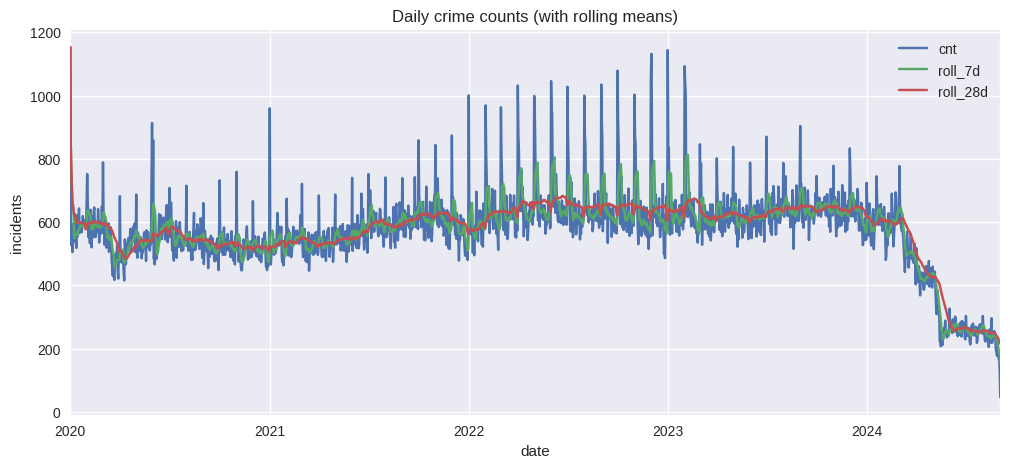

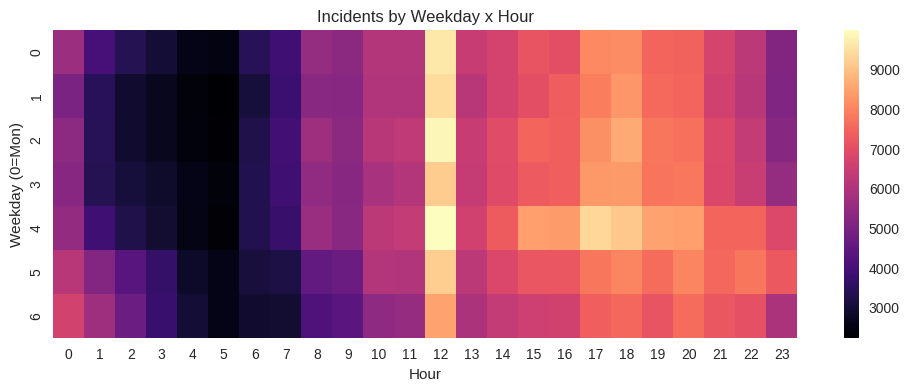

In [43]:
# Time series: daily total + rolling
daily = df.groupby("date").size().rename("cnt").to_frame()
for w in ROLL_WINDOWS:
    daily[f"roll_{w}d"] = daily["cnt"].rolling(w, min_periods=1).mean()

ax = daily.plot(figsize=(12,5), title="Daily crime counts (with rolling means)")
ax.set_ylabel("incidents"); plt.show()

# Hour vs Weekday heatmap
pivot_hw = df.pivot_table(index="weekday", columns="hour", values="dr_no" if "dr_no" in df else df.columns[0], aggfunc="count")
plt.figure(figsize=(12,4))
if not pivot_hw.empty:
    sns.heatmap(pivot_hw, cmap="magma")
    plt.title("Incidents by Weekday x Hour"); plt.xlabel("Hour"); plt.ylabel("Weekday (0=Mon)")
    plt.show()
else:
    print("No data to display Weekday x Hour heatmap.")


# Top crime descriptions (if available)
if "crime_desc" in df:
    top_desc = (df["crime_desc"].value_counts().head(20)).sort_values()
    top_desc.plot(kind="barh", figsize=(8,8), title="Top 20 Crime Descriptions")
    plt.xlabel("count"); plt.show()

# Simple map: sample of hex cells (centroids) colored by recent counts
if "h3" in df and df["h3"].notna().any():
    last_90 = df[df["date"] >= (df["date"].max() - pd.Timedelta(days=90))]
    c90 = last_90.groupby("h3").size().rename("cnt").reset_index()
    # center map around mean lat/lon of valid points
    center_lat = df["lat"].dropna().mean() if "lat" in df else 34.05
    center_lon = df["lon"].dropna().mean() if "lon" in df else -118.25
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    for _, row in c90.iterrows():
        # draw hex boundary
        poly = h3.h3_to_geo_boundary(row["h3"], geo_json=True)
        folium.Polygon(locations=poly, weight=1, fill=True, fill_opacity=0.4,
                       tooltip=f'H3 {row["h3"]} | 90d cnt={int(row["cnt"])}').add_to(m)
    m

In [44]:
# 9.1 Z-score outliers on chosen numeric columns
Z_NUMS = [c for c in ["victim_age","cnt","roll_7d","roll_28d","burstiness","lat","lon"] if c in df.columns]
z_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=1)
    if not np.isfinite(mu) or sd==0 or s.isna().all():
        continue
    z = (s - mu) / sd
    z_flags = z_flags | (np.abs(z) > 3.0)  # “3-sigma” heuristic

df["outlier_z"] = z_flags.astype(int)

# 9.2 IQR rule for the same columns
iqr_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float).dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_flags = iqr_flags | (df[c] < lo) | (df[c] > hi)

df["outlier_iqr"] = iqr_flags.astype(int)

# 9.3 DBSCAN on spatial coords (find isolated points)
if {"lat","lon"}.issubset(df.columns):
    # sample for speed if huge
    samp_idx = df[["lat","lon"]].dropna().index
    if len(samp_idx) > 200000:
        samp_idx = np.random.default_rng(42).choice(samp_idx, size=200000, replace=False)
    coords = df.loc[samp_idx, ["lat","lon"]].to_numpy()

    # eps in degrees (~300m); tweak as needed
    db = DBSCAN(eps=0.003, min_samples=10, n_jobs=-1)
    labels = db.fit_predict(coords)
    spatial_outliers = pd.Series(0, index=df.index)
    spatial_outliers.loc[samp_idx] = (labels==-1).astype(int)
    df["outlier_dbscan_spatial"] = spatial_outliers
else:
    df["outlier_dbscan_spatial"] = 0

# Composite flag (any method)
df["outlier_any"] = ((df["outlier_z"]==1) | (df["outlier_iqr"]==1) | (df["outlier_dbscan_spatial"]==1)).astype(int)

df[["outlier_z","outlier_iqr","outlier_dbscan_spatial","outlier_any"]].mean().rename("share_of_rows_flagged")


outlier_z                 0.045405
outlier_iqr               0.131551
outlier_dbscan_spatial    0.000000
outlier_any               0.131551
Name: share_of_rows_flagged, dtype: float64

In [45]:
# 9.1 Z-score outliers on chosen numeric columns
Z_NUMS = [c for c in ["victim_age","cnt","roll_7d","roll_28d","burstiness","lat","lon"] if c in df.columns]
z_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=1)
    if not np.isfinite(mu) or sd==0 or s.isna().all():
        continue
    z = (s - mu) / sd
    z_flags = z_flags | (np.abs(z) > 3.0)  # “3-sigma” heuristic

df["outlier_z"] = z_flags.astype(int)

# 9.2 IQR rule for the same columns
iqr_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float).dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_flags = iqr_flags | (df[c] < lo) | (df[c] > hi)

df["outlier_iqr"] = iqr_flags.astype(int)

# 9.3 DBSCAN on spatial coords (find isolated points)
if {"lat","lon"}.issubset(df.columns):
    # sample for speed if huge
    samp_idx = df[["lat","lon"]].dropna().index
    if len(samp_idx) > 200000:
        samp_idx = np.random.default_rng(42).choice(samp_idx, size=200000, replace=False)
    coords = df.loc[samp_idx, ["lat","lon"]].to_numpy()

    # eps in degrees (~300m); tweak as needed
    db = DBSCAN(eps=0.003, min_samples=10, n_jobs=-1)
    labels = db.fit_predict(coords)
    spatial_outliers = pd.Series(0, index=df.index)
    spatial_outliers.loc[samp_idx] = (labels==-1).astype(int)
    df["outlier_dbscan_spatial"] = spatial_outliers
else:
    df["outlier_dbscan_spatial"] = 0

# Composite flag (any method)
df["outlier_any"] = ((df["outlier_z"]==1) | (df["outlier_iqr"]==1) | (df["outlier_dbscan_spatial"]==1)).astype(int)

df[["outlier_z","outlier_iqr","outlier_dbscan_spatial","outlier_any"]].mean().rename("share_of_rows_flagged")

outlier_z                 0.045405
outlier_iqr               0.131551
outlier_dbscan_spatial    0.000000
outlier_any               0.131551
Name: share_of_rows_flagged, dtype: float64

=== DISTRIBUTION ANALYSIS ===

Found 12 categorical columns: ['Date_Reported', 'Date_occured', 'Area', 'Crime_Code', 'Victim_sex', 'Victim_descent', 'Premis', 'Weapon', 'Status', 'LOCATION', 'season', 'h3']
Found 18 numerical columns: ['Victim_age', 'LAT', 'LON', 'hour', 'weekday', 'month', 'is_weekend', 'is_holiday', 'dayofyear', 'quarter', 'cnt', 'hour_missing', 'h3_missing', 'LOCATION_missing', 'outlier_z', 'outlier_iqr', 'outlier_dbscan_spatial', 'outlier_any']

1. CATEGORICAL DISTRIBUTIONS:


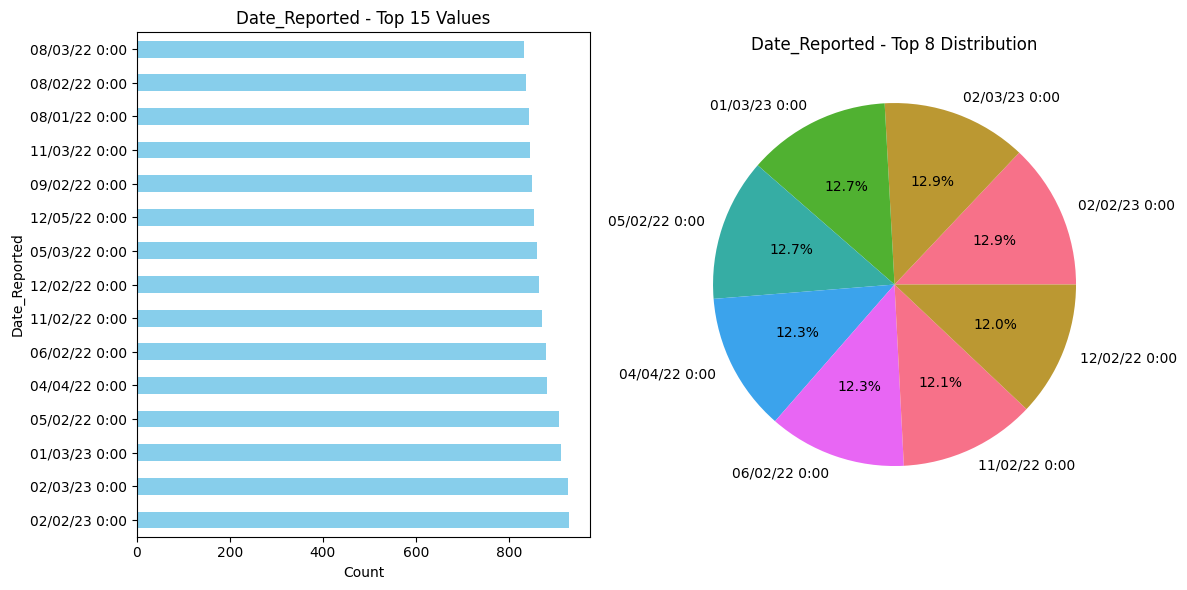


Date_Reported Stats:
  Unique values: 1708
  Most common: 02/02/23 0:00
  Missing values: 0


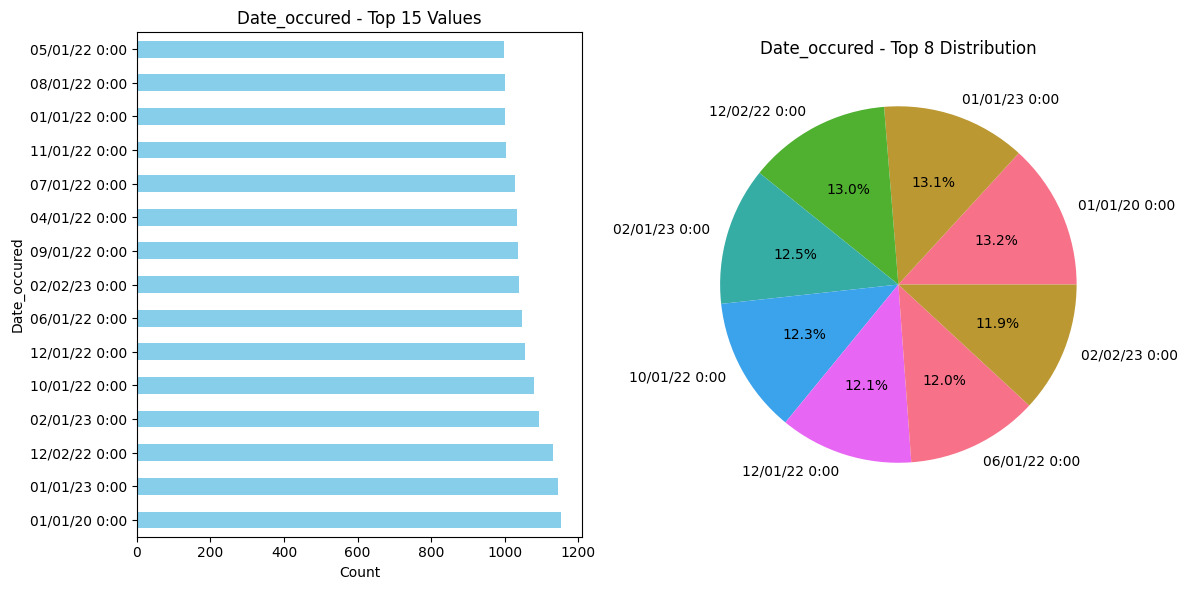


Date_occured Stats:
  Unique values: 1707
  Most common: 01/01/20 0:00
  Missing values: 0


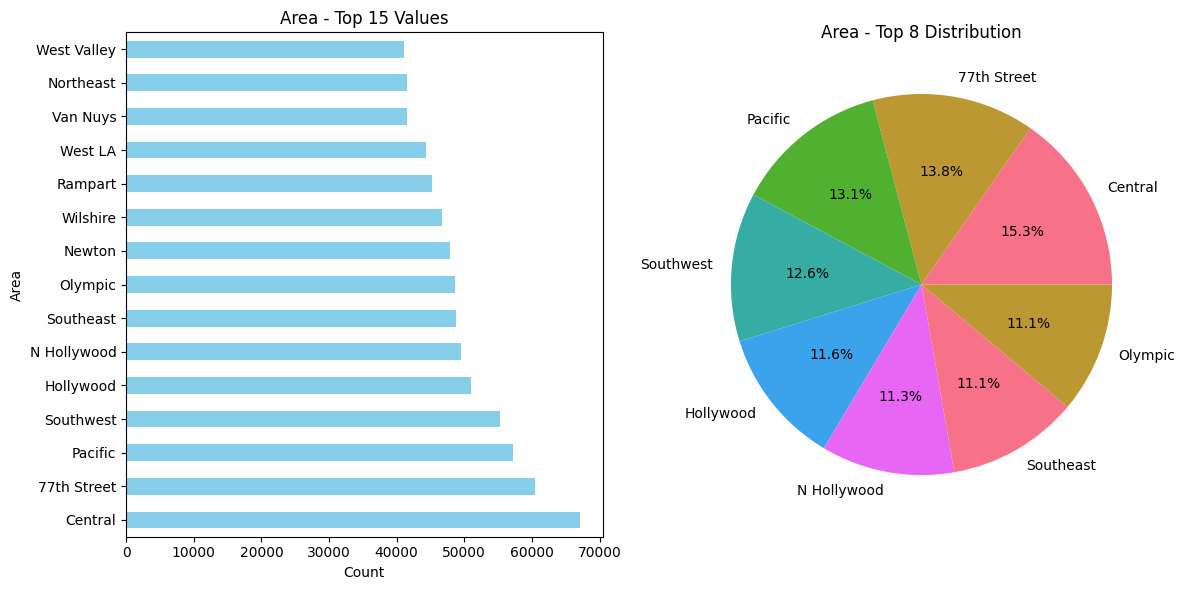


Area Stats:
  Unique values: 21
  Most common: Central
  Missing values: 0


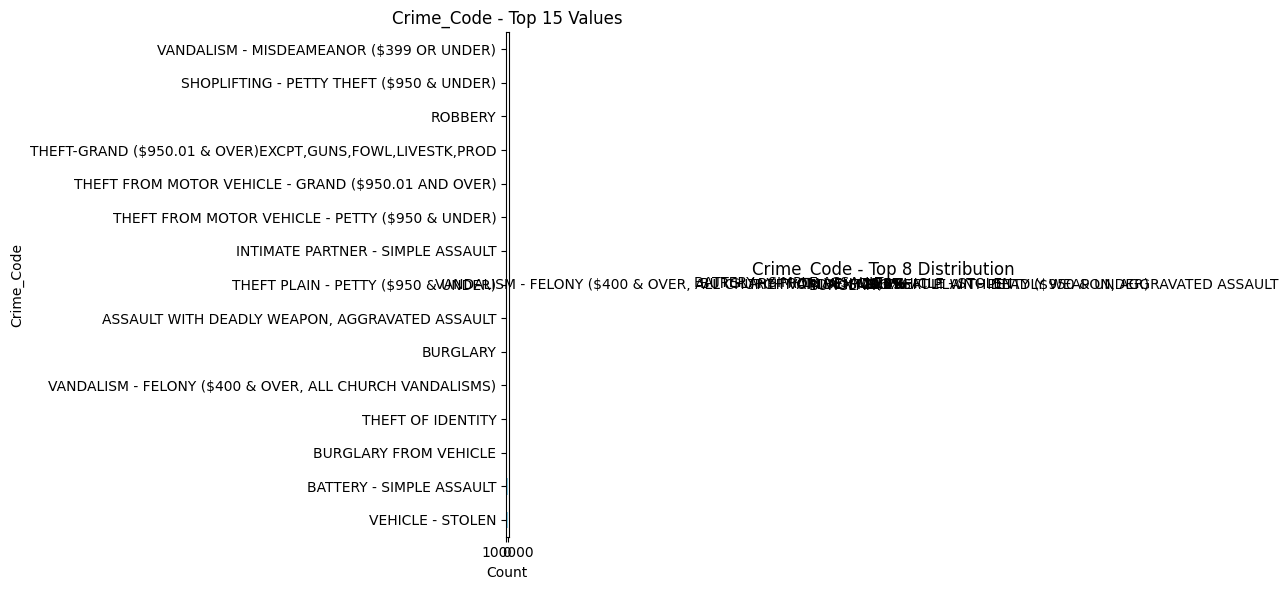


Crime_Code Stats:
  Unique values: 139
  Most common: VEHICLE - STOLEN
  Missing values: 0


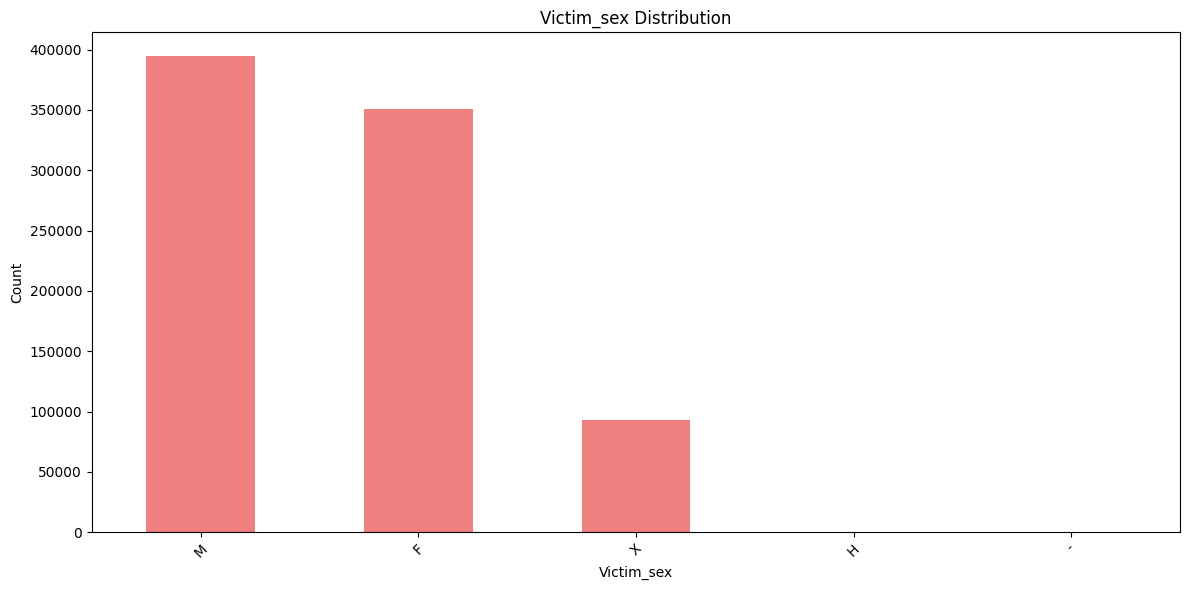


Victim_sex Stats:
  Unique values: 5
  Most common: M
  Missing values: 136003


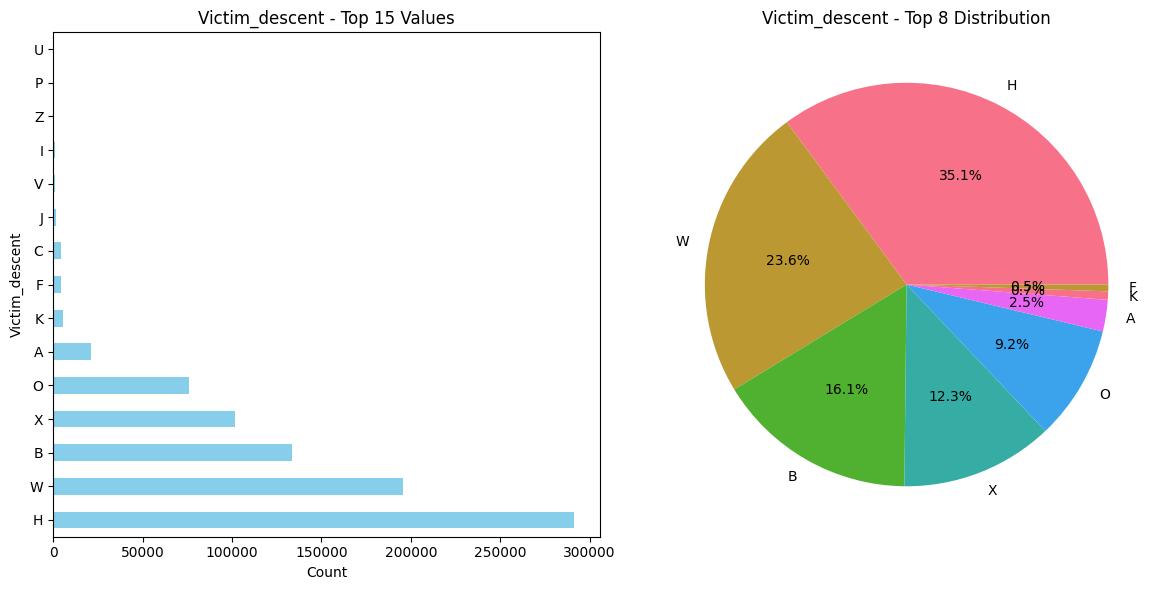


Victim_descent Stats:
  Unique values: 20
  Most common: H
  Missing values: 136013


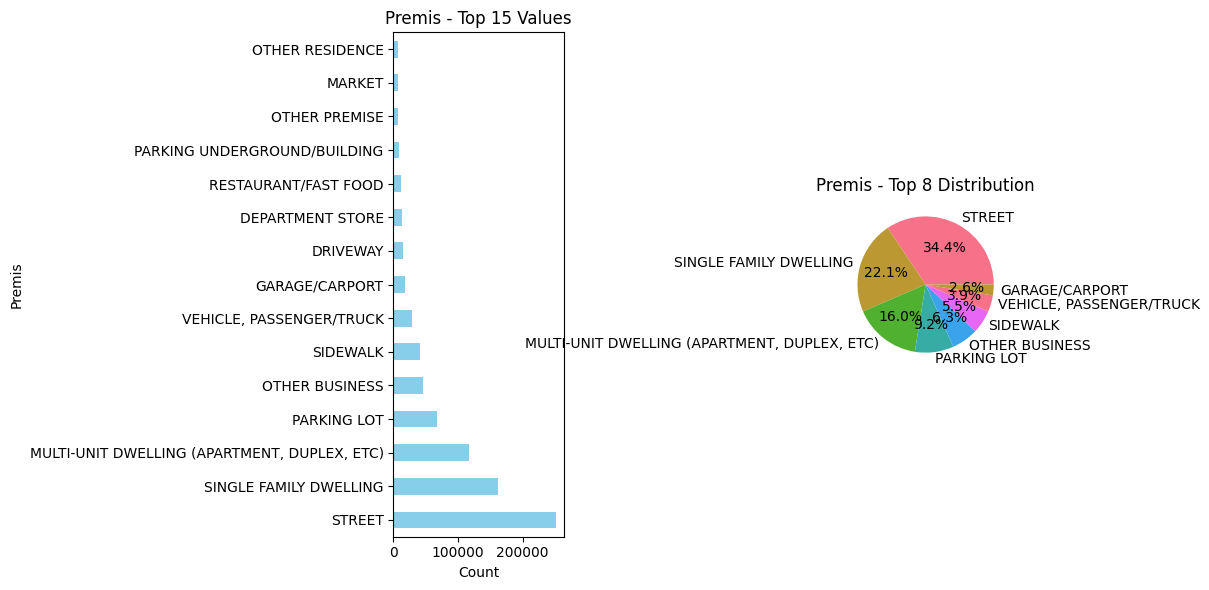


Premis Stats:
  Unique values: 306
  Most common: STREET
  Missing values: 584


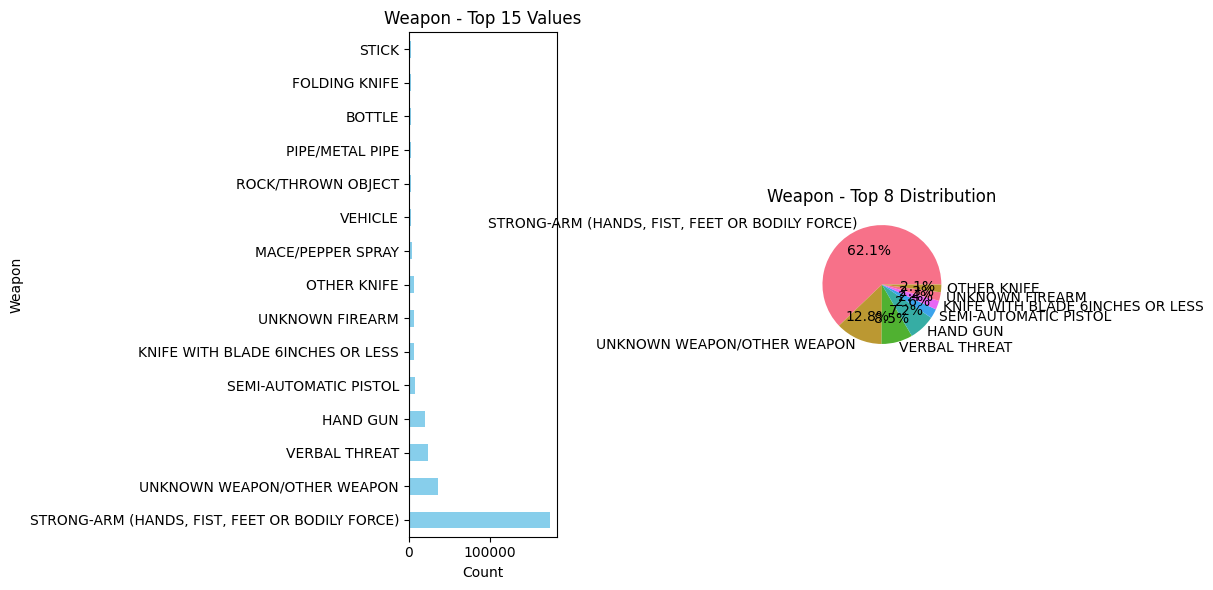


Weapon Stats:
  Unique values: 79
  Most common: STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)
  Missing values: 648695


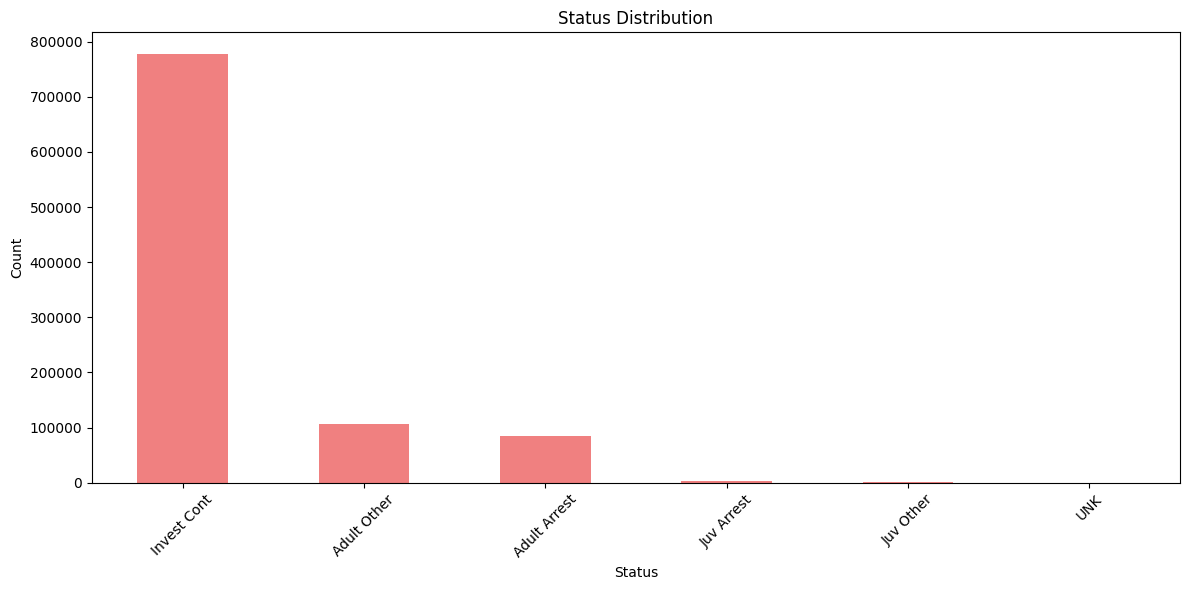


Status Stats:
  Unique values: 6
  Most common: Invest Cont
  Missing values: 0


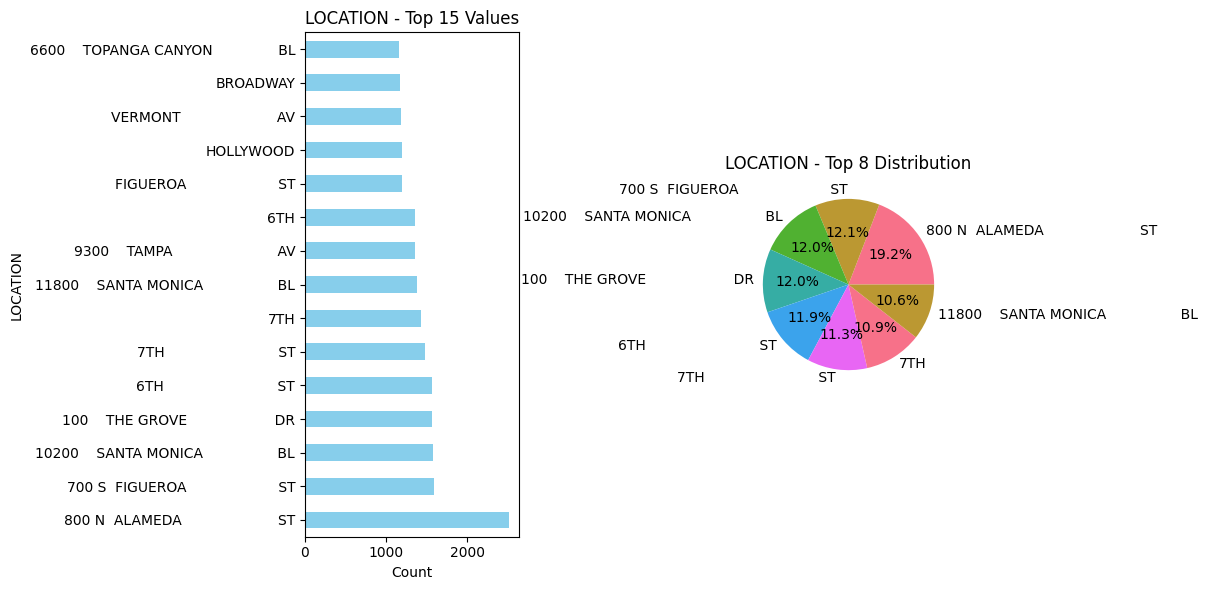


LOCATION Stats:
  Unique values: 66165
  Most common: 800 N  ALAMEDA                      ST
  Missing values: 0


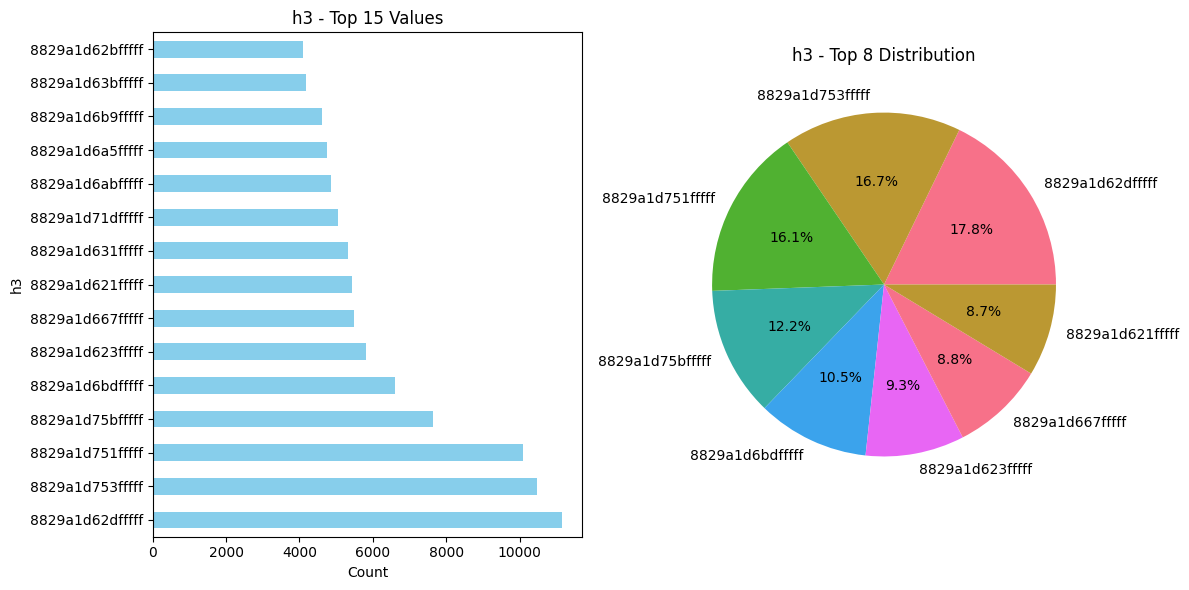


h3 Stats:
  Unique values: 1571
  Most common: 8829a1d62dfffff
  Missing values: 0

2. NUMERICAL DISTRIBUTIONS:


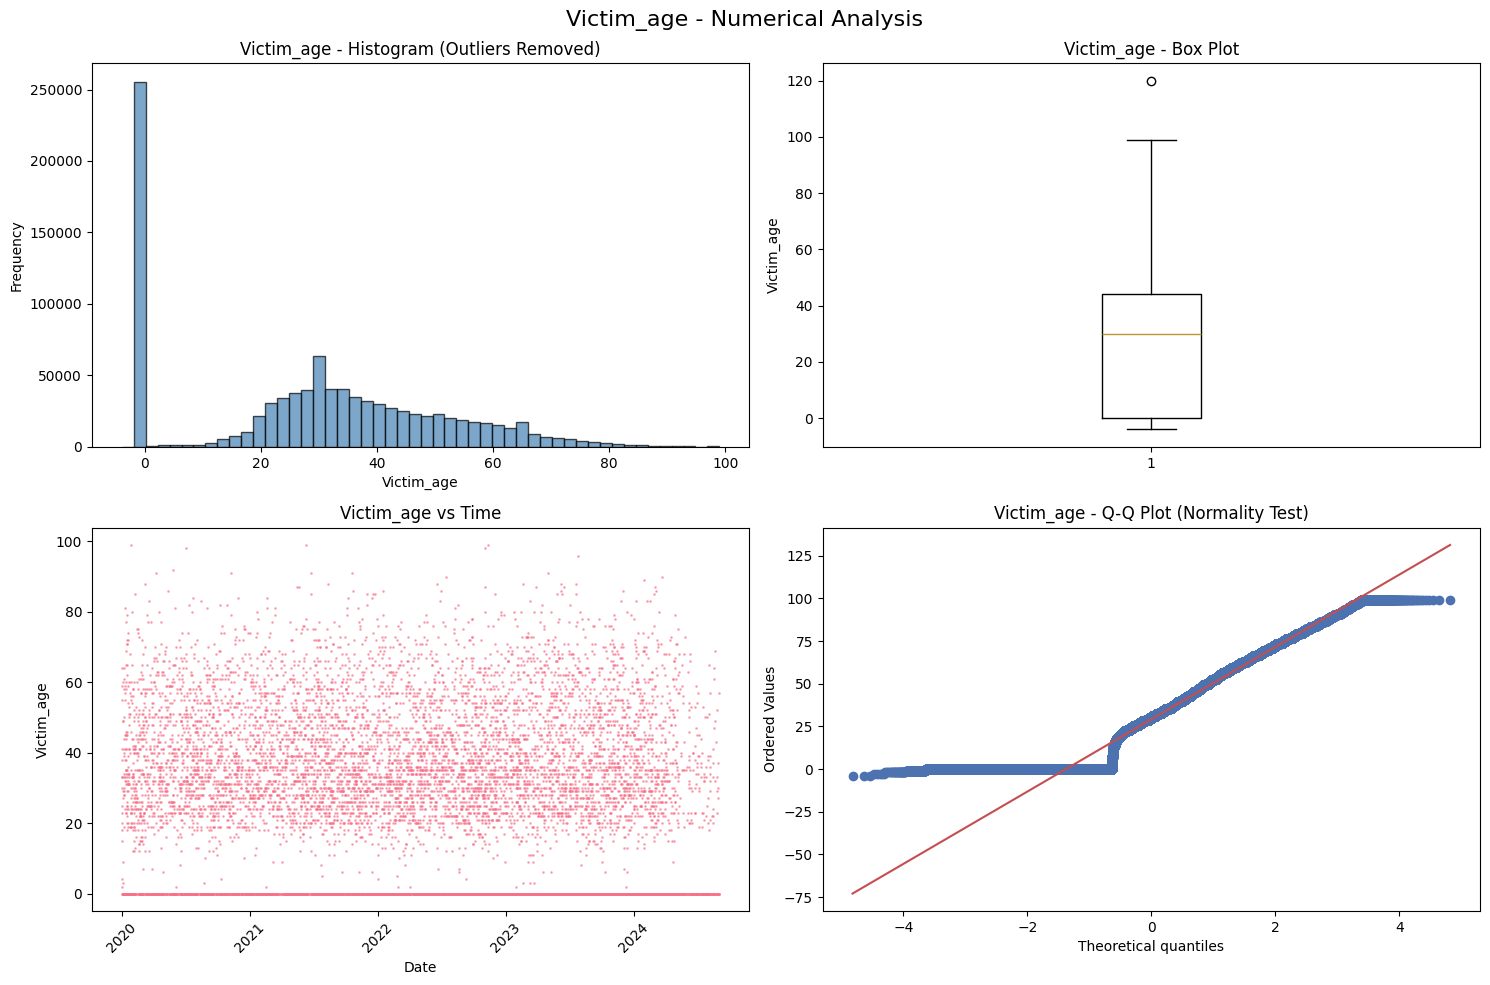


Victim_age Statistics:
  Count: 974477
  Mean: 29.17
  Median: 30.00
  Std: 21.95
  Min: -4
  Max: 120
  Missing: 0
  Outliers (IQR method): 1


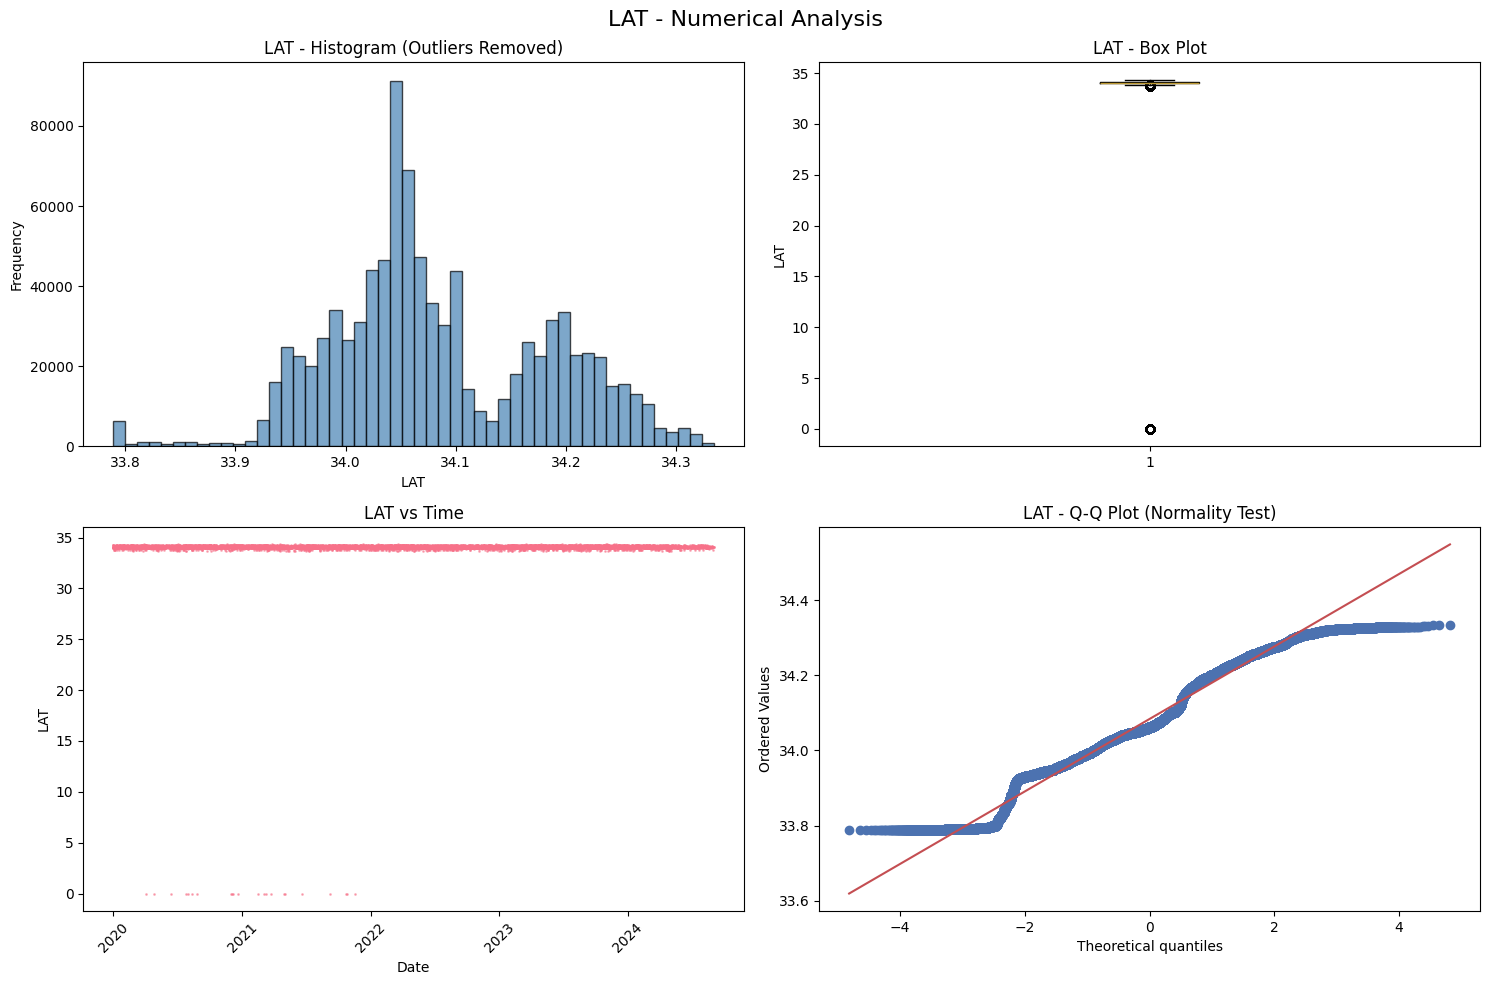


LAT Statistics:
  Count: 974477
  Mean: 34.00
  Median: 34.06
  Std: 1.64
  Min: 0.0
  Max: 34.3343
  Missing: 0
  Outliers (IQR method): 30048


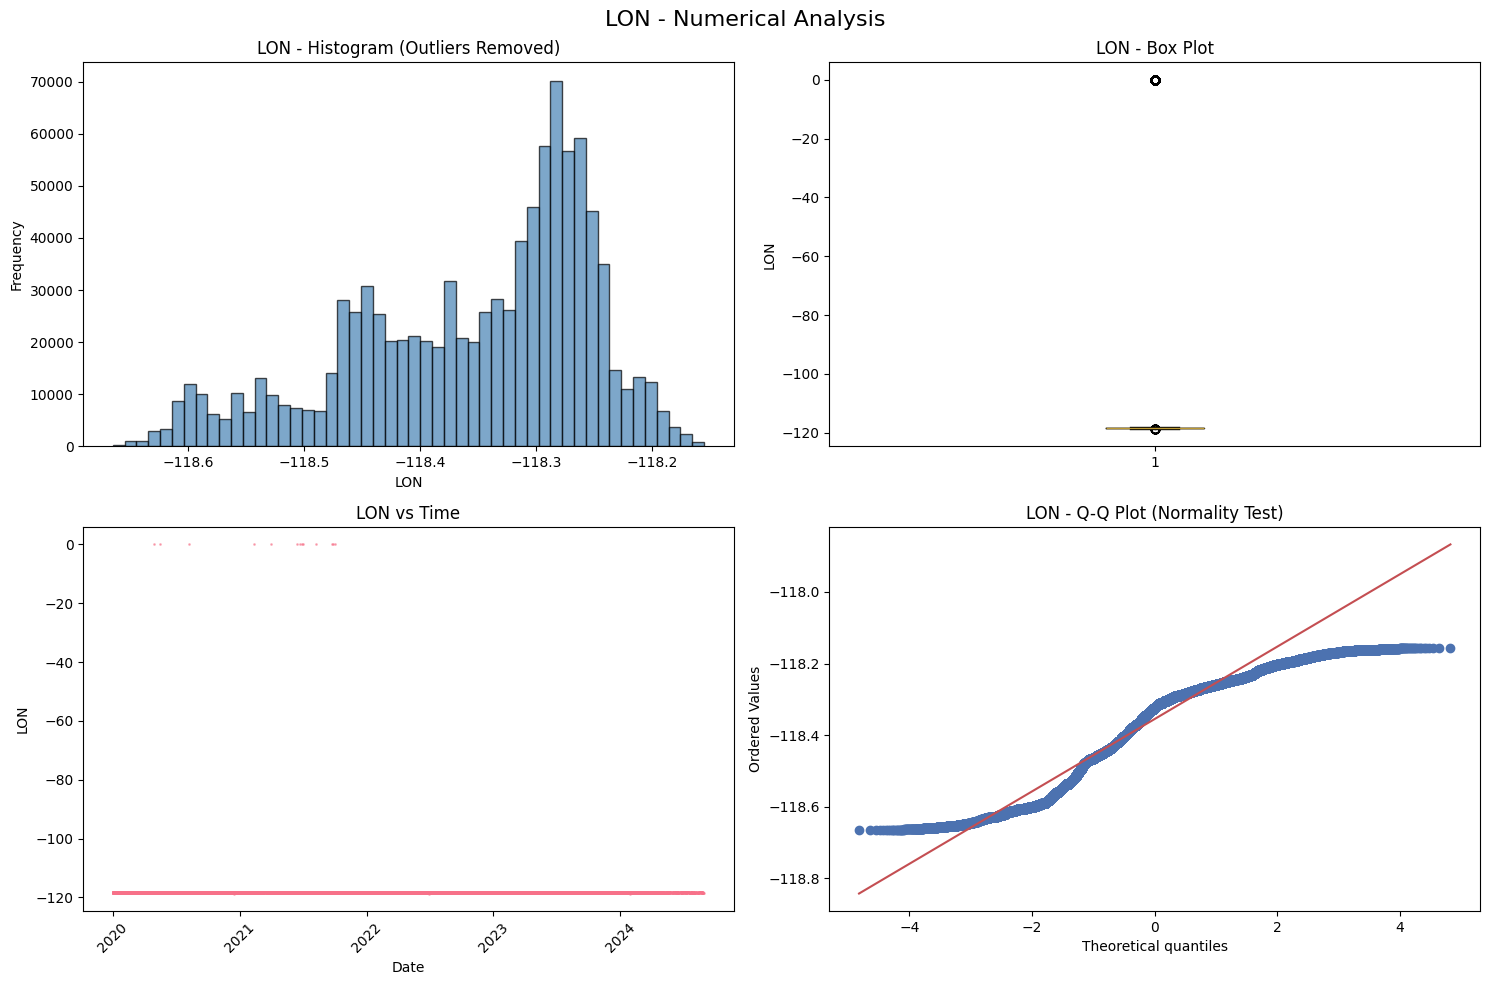


LON Statistics:
  Count: 974477
  Mean: -118.08
  Median: -118.32
  Std: 5.70
  Min: -118.6676
  Max: 0.0
  Missing: 0
  Outliers (IQR method): 2291


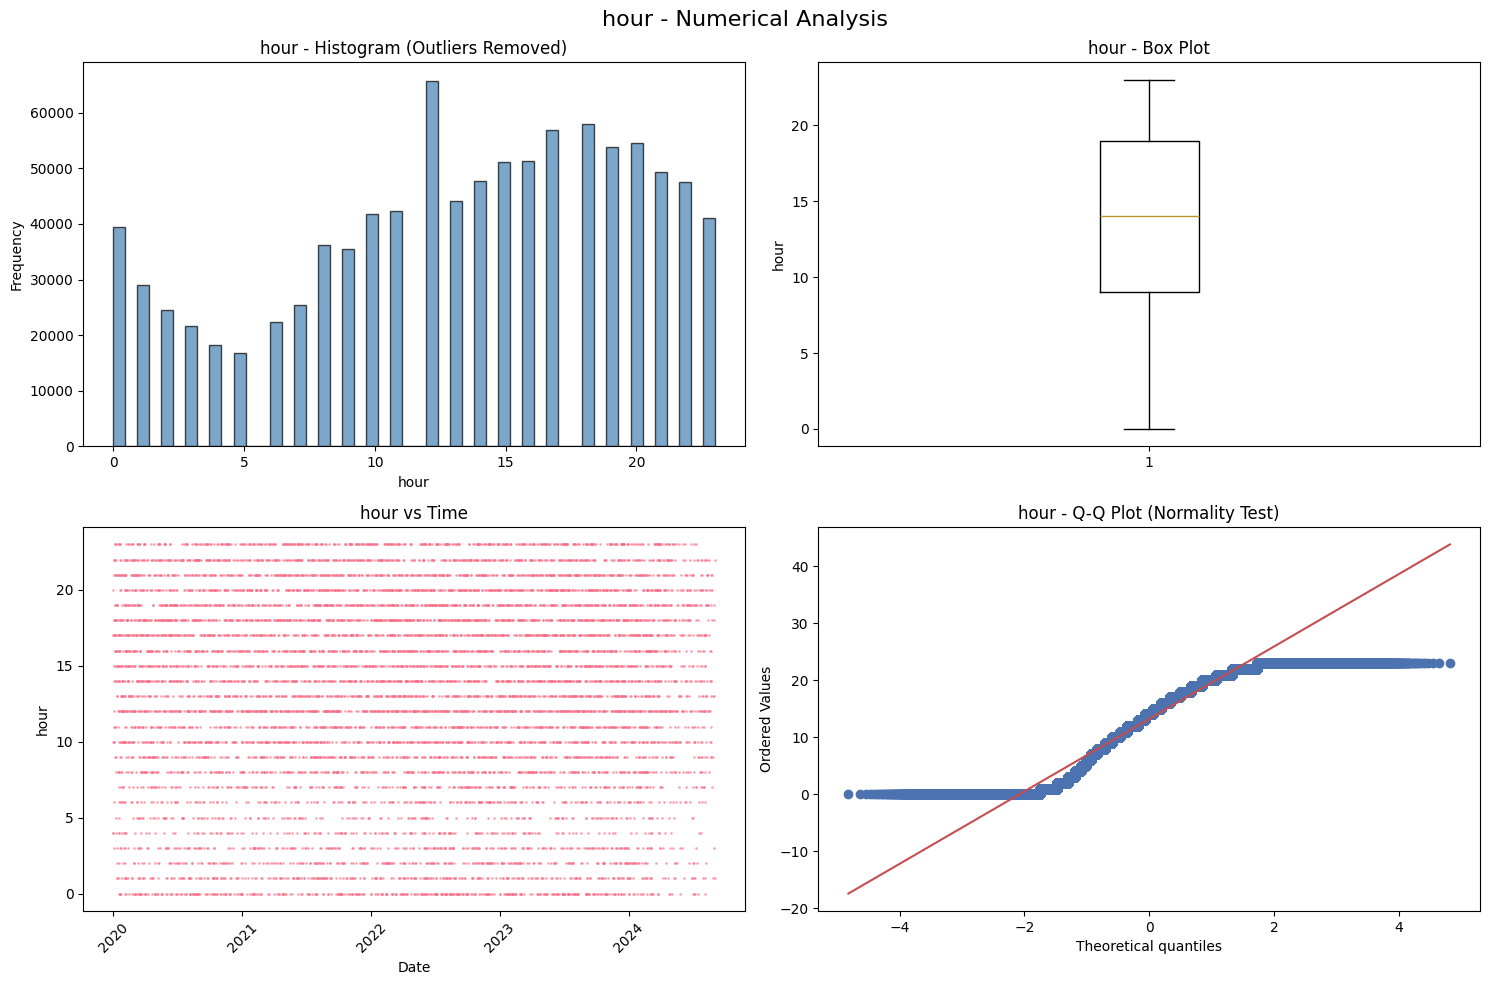


hour Statistics:
  Count: 974477
  Mean: 13.21
  Median: 14.00
  Std: 6.52
  Min: 0
  Max: 23
  Missing: 0
  Outliers (IQR method): 0


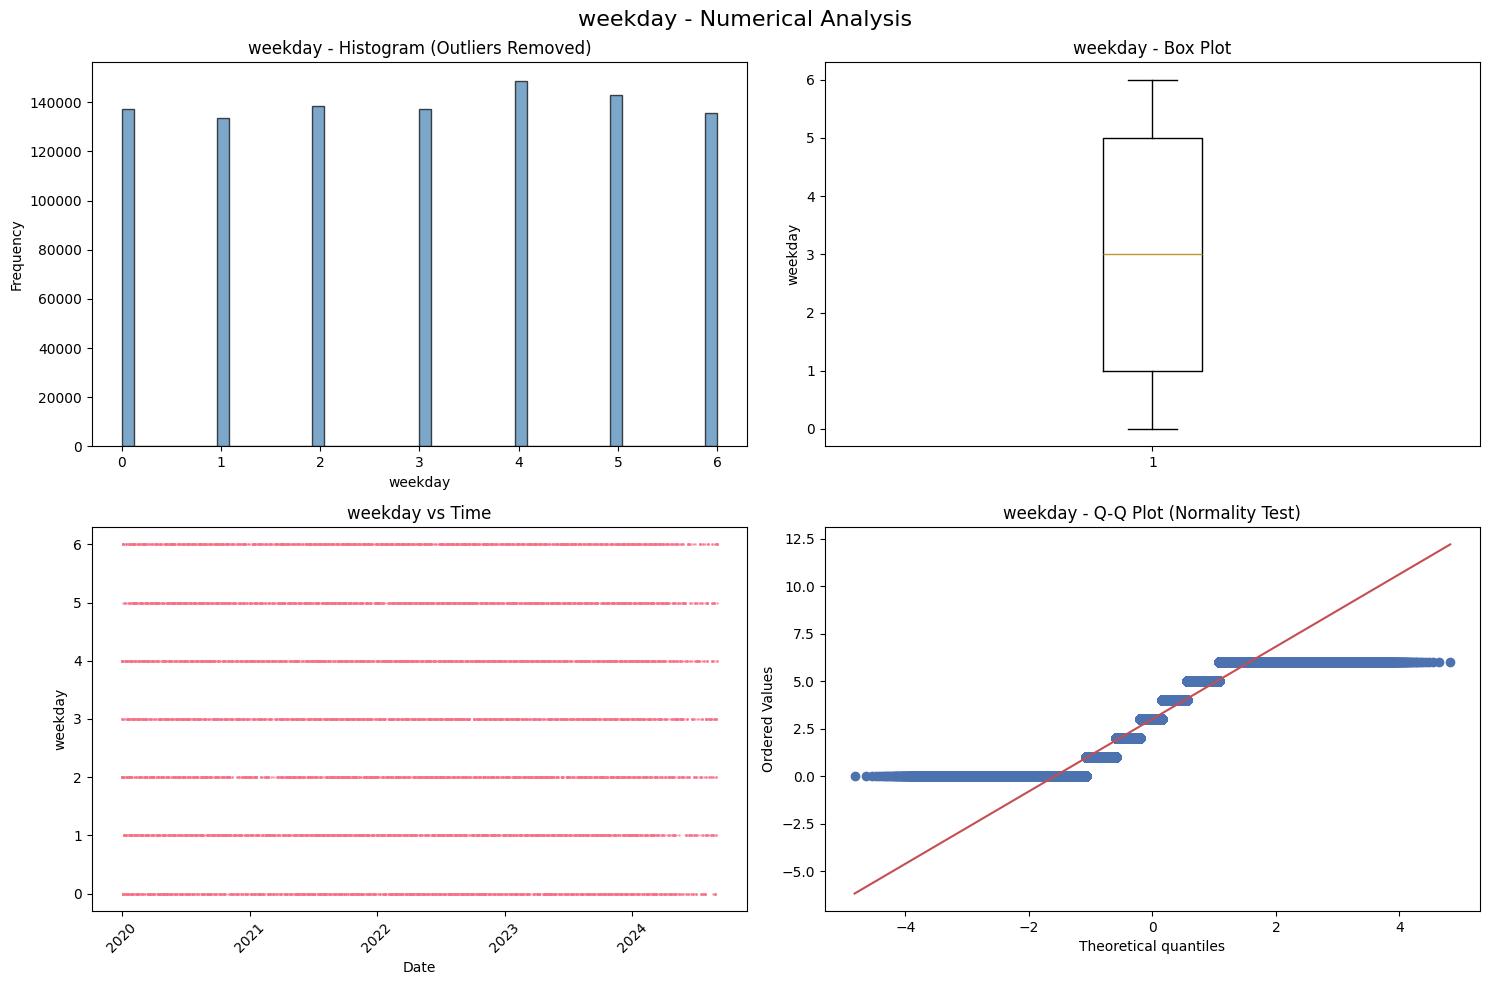


weekday Statistics:
  Count: 974477
  Mean: 3.02
  Median: 3.00
  Std: 1.99
  Min: 0
  Max: 6
  Missing: 0
  Outliers (IQR method): 0


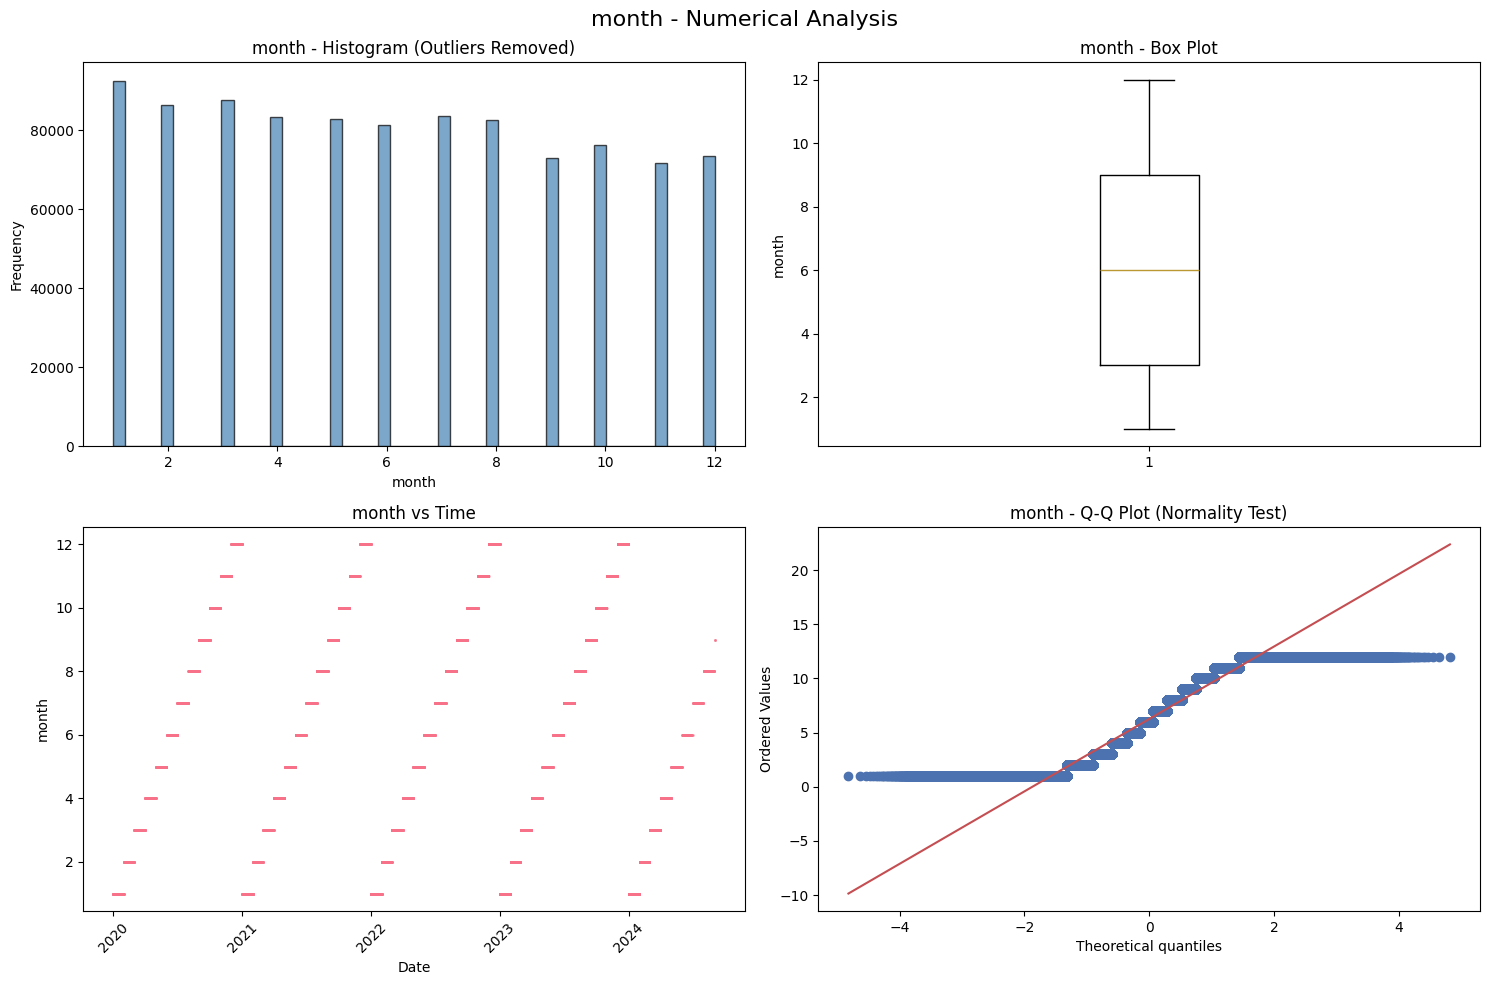


month Statistics:
  Count: 974477
  Mean: 6.26
  Median: 6.00
  Std: 3.44
  Min: 1
  Max: 12
  Missing: 0
  Outliers (IQR method): 0


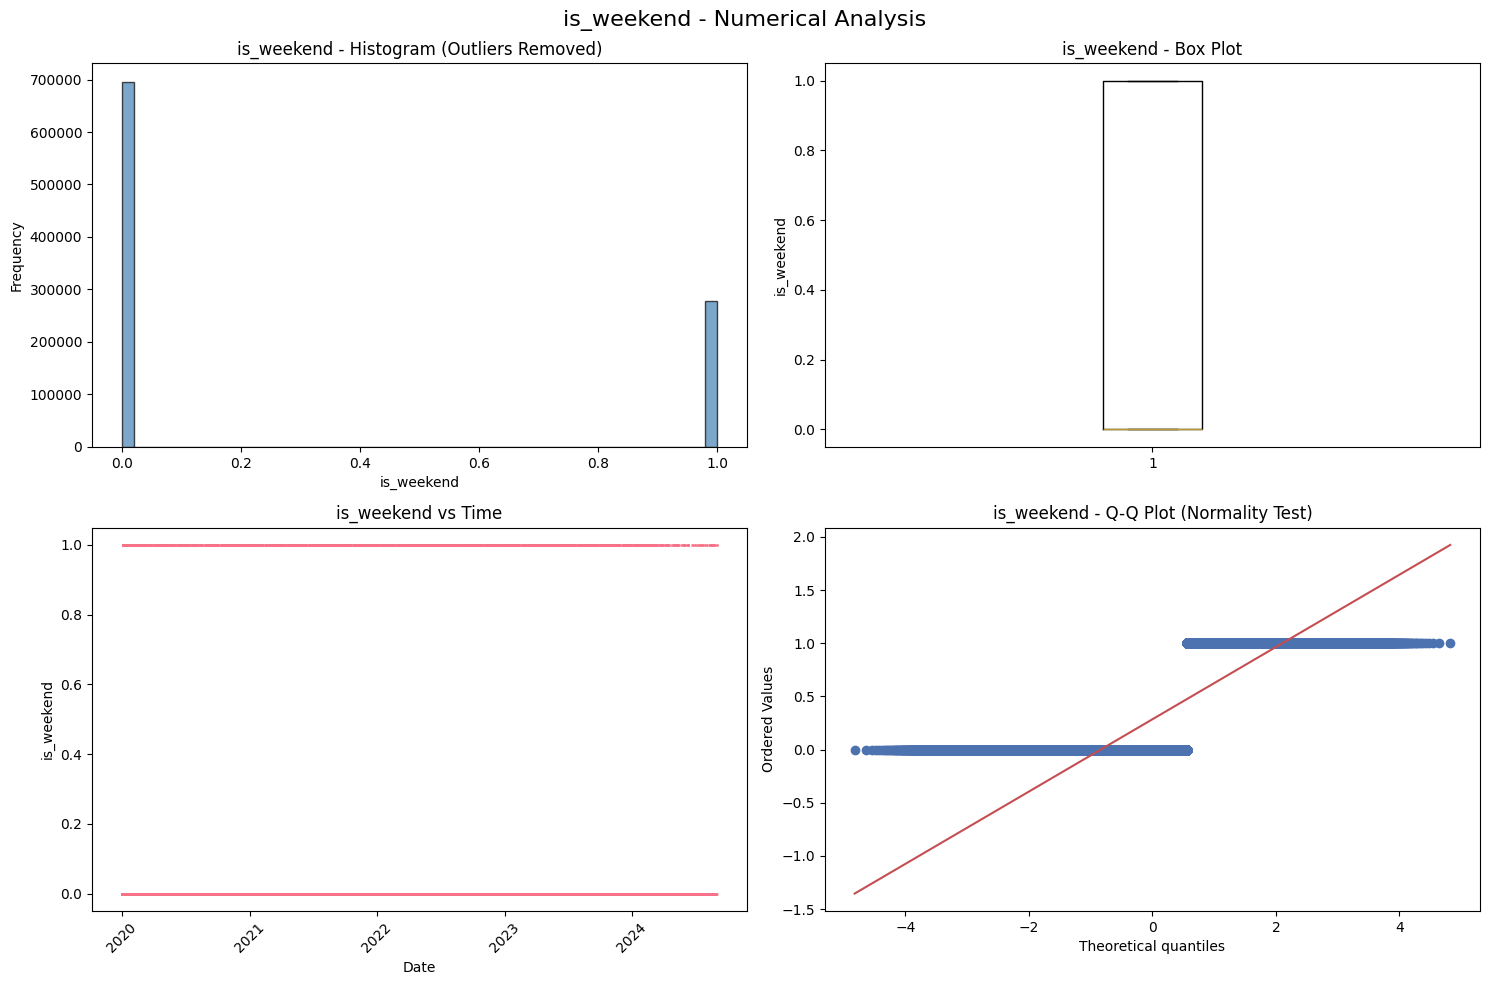


is_weekend Statistics:
  Count: 974477
  Mean: 0.29
  Median: 0.00
  Std: 0.45
  Min: 0
  Max: 1
  Missing: 0
  Outliers (IQR method): 0


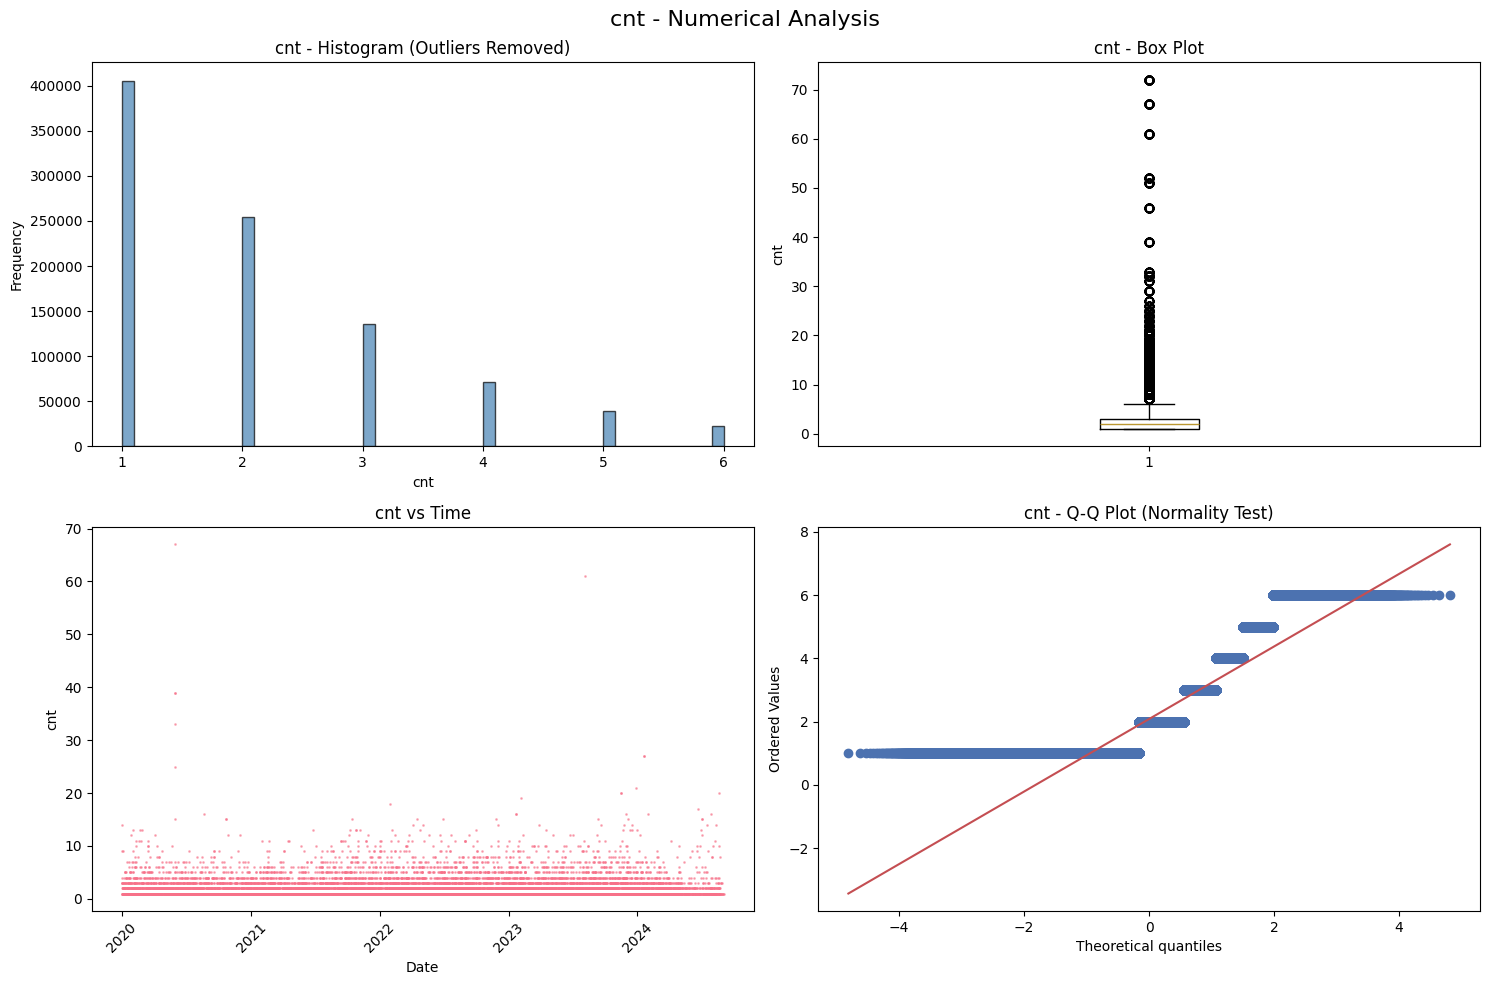


cnt Statistics:
  Count: 974477
  Mean: 2.46
  Median: 2.00
  Std: 2.40
  Min: 1.0
  Max: 72.0
  Missing: 0
  Outliers (IQR method): 46615


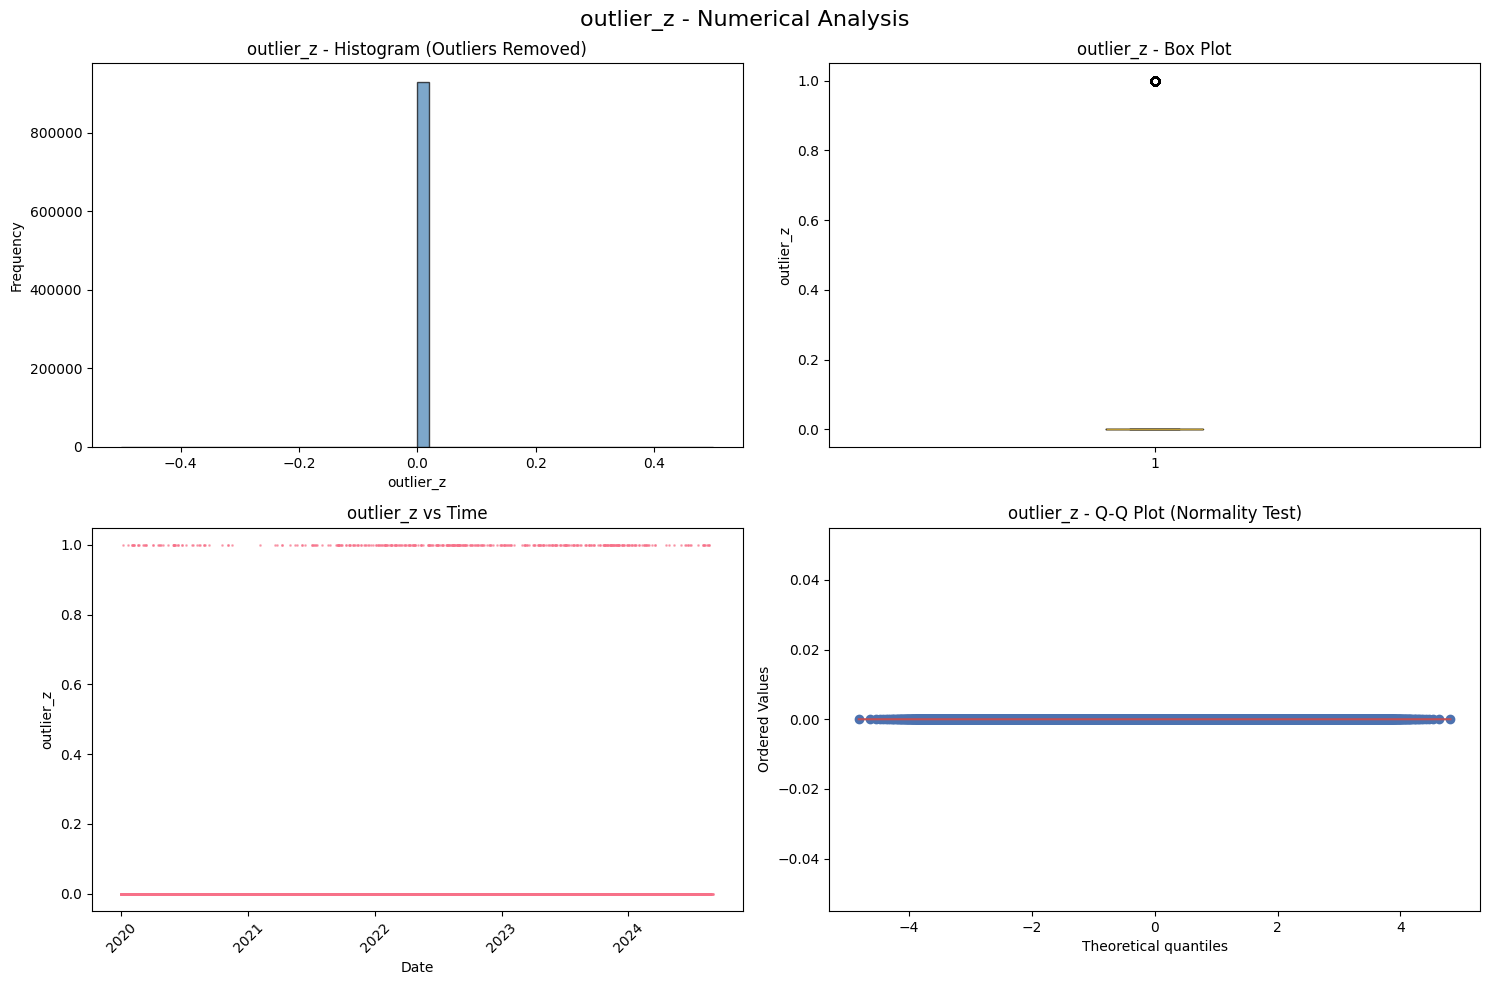


outlier_z Statistics:
  Count: 974477
  Mean: 0.05
  Median: 0.00
  Std: 0.21
  Min: 0
  Max: 1
  Missing: 0
  Outliers (IQR method): 44246


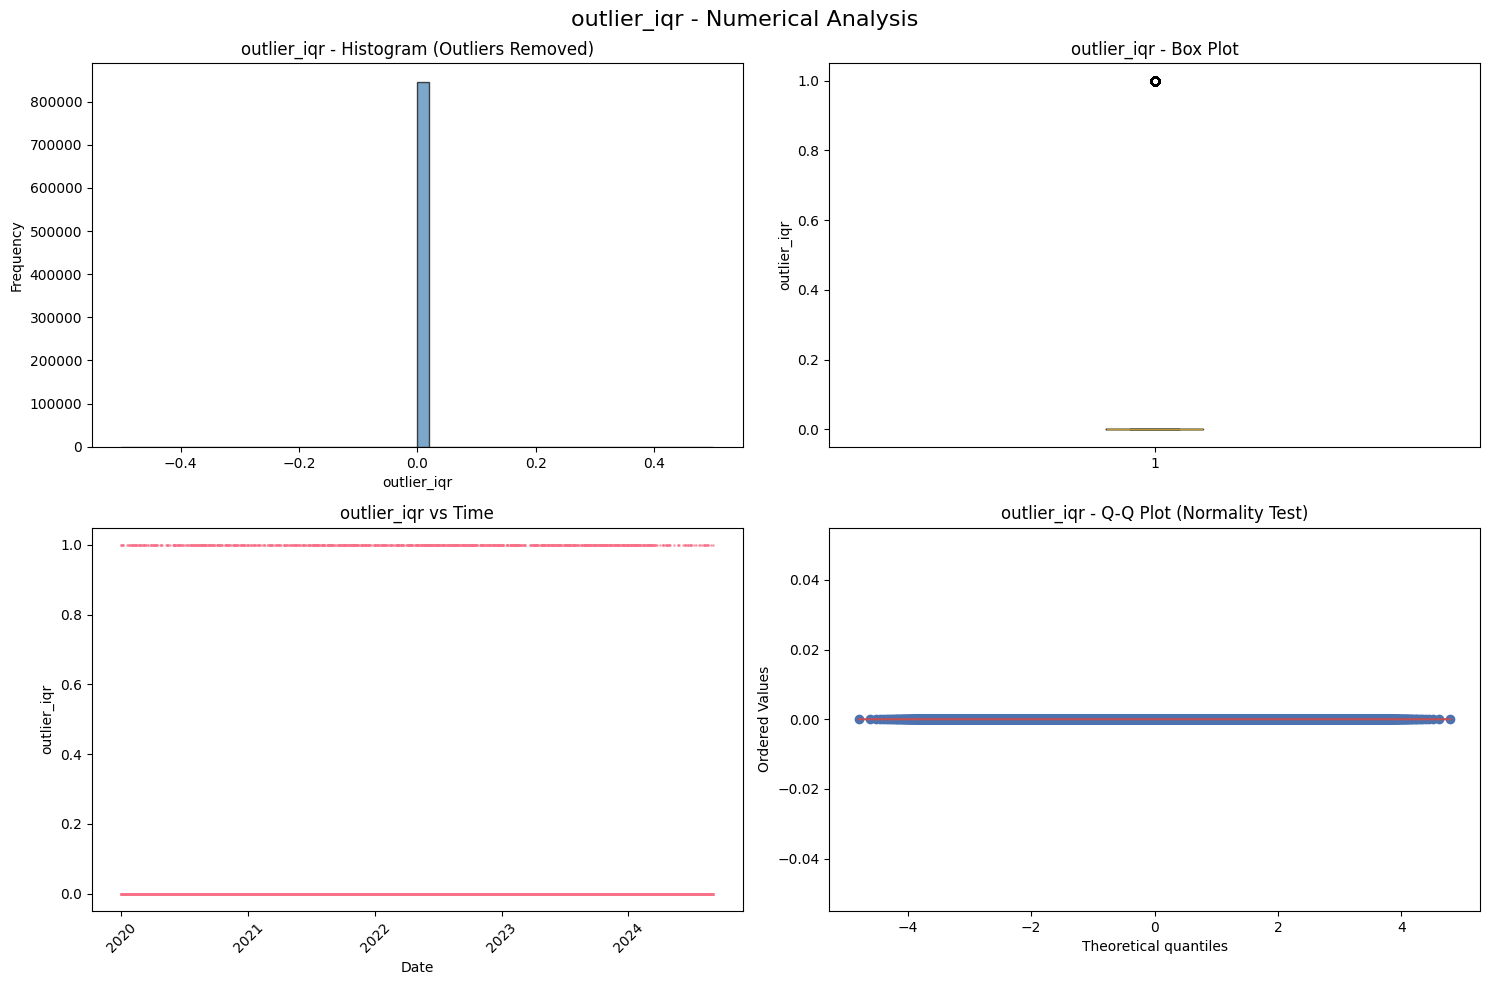


outlier_iqr Statistics:
  Count: 974477
  Mean: 0.13
  Median: 0.00
  Std: 0.34
  Min: 0
  Max: 1
  Missing: 0
  Outliers (IQR method): 128193


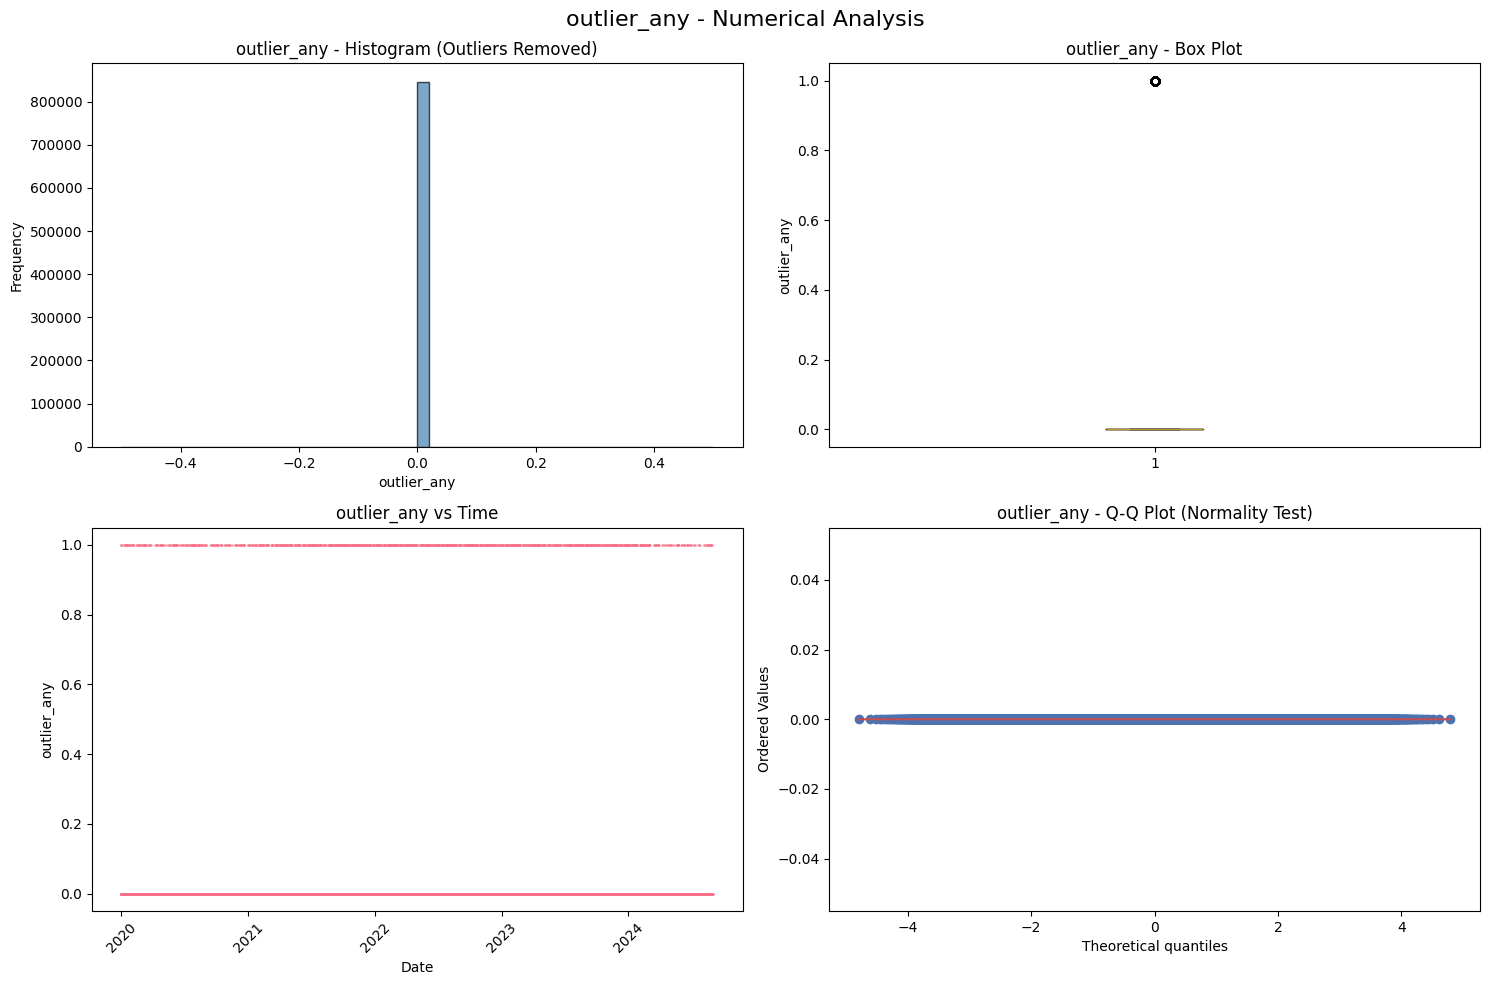


outlier_any Statistics:
  Count: 974477
  Mean: 0.13
  Median: 0.00
  Std: 0.34
  Min: 0
  Max: 1
  Missing: 0
  Outliers (IQR method): 128193

3. CORRELATION ANALYSIS:


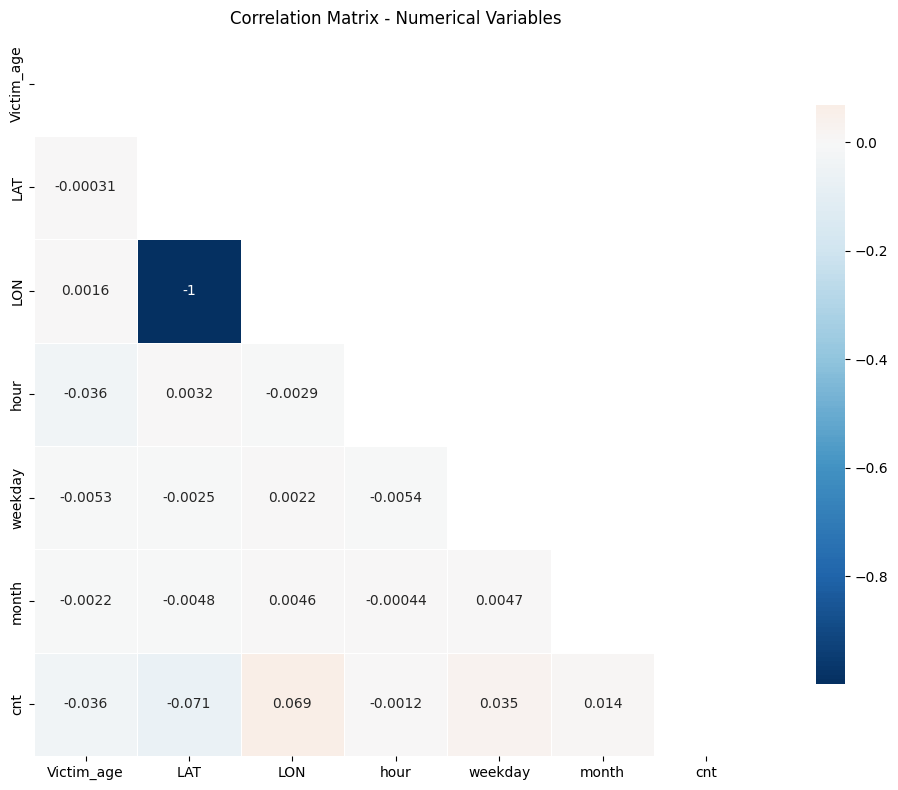


Strong Correlations (|r| > 0.5):
  LAT ↔ LON: -0.998

=== ANALYSIS COMPLETE ===
📊 All distribution plots generated!
📈 Check the correlation matrix for interesting relationships
📋 Review the printed statistics for data quality insights


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import ceil

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("=== DISTRIBUTION ANALYSIS ===\n")

# Identify categorical and numerical columns
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if df[col].dtype in ['object', 'category']:
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        # Skip ID-like columns or columns with too many unique values
        if col not in ['LAT', 'LON'] and df[col].nunique() < 50:
            numerical_cols.append(col)
        elif col in ['LAT', 'LON', 'Victim_age']:  # Special numerical columns
            numerical_cols.append(col)

print(f"Found {len(categorical_cols)} categorical columns: {categorical_cols}")
print(f"Found {len(numerical_cols)} numerical columns: {numerical_cols}")

# ====== CATEGORICAL DISTRIBUTIONS (Histograms/Bar Charts) ======
print("\n1. CATEGORICAL DISTRIBUTIONS:")

# Function to create categorical plots
def plot_categorical_distribution(col, max_categories=15):
    plt.figure(figsize=(12, 6))

    # Get value counts
    value_counts = df[col].value_counts().head(max_categories)

    if len(value_counts) > 10:
        # Horizontal bar chart for many categories
        plt.subplot(1, 2, 1)
        value_counts.plot(kind='barh', color='skyblue')
        plt.title(f'{col} - Top {max_categories} Values')
        plt.xlabel('Count')

        # Pie chart for top categories
        plt.subplot(1, 2, 2)
        value_counts.head(8).plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'{col} - Top 8 Distribution')
        plt.ylabel('')
    else:
        # Regular bar chart for fewer categories
        value_counts.plot(kind='bar', color='lightcoral', rot=45)
        plt.title(f'{col} Distribution')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print stats
    print(f"\n{col} Stats:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Most common: {df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'}")
    print(f"  Missing values: {df[col].isnull().sum()}")

# Plot categorical distributions
for col in categorical_cols:
    if df[col].nunique() > 1:  # Skip columns with only one value
        plot_categorical_distribution(col)

# ====== NUMERICAL DISTRIBUTIONS (Histograms + Scatter Plots) ======
print("\n2. NUMERICAL DISTRIBUTIONS:")

def plot_numerical_distribution(col):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{col} - Numerical Analysis', fontsize=16)

    # Remove outliers for better visualization
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = df[col][(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # 1. Histogram
    axes[0, 0].hist(filtered_data.dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].set_title(f'{col} - Histogram (Outliers Removed)')
    axes[0, 0].set_xlabel(col)
    axes[0, 0].set_ylabel('Frequency')

    # 2. Box plot
    axes[0, 1].boxplot(df[col].dropna(), vert=True)
    axes[0, 1].set_title(f'{col} - Box Plot')
    axes[0, 1].set_ylabel(col)

    # 3. Scatter plot vs date (if date column exists)
    if 'date' in df.columns:
        sample_data = df.sample(min(10000, len(df)))  # Sample for performance
        axes[1, 0].scatter(sample_data['date'], sample_data[col], alpha=0.5, s=1)
        axes[1, 0].set_title(f'{col} vs Time')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel(col)
        axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Q-Q plot for normality check
    from scipy import stats
    stats.probplot(filtered_data.dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f'{col} - Q-Q Plot (Normality Test)')

    plt.tight_layout()
    plt.show()

    # Print detailed stats
    print(f"\n{col} Statistics:")
    print(f"  Count: {df[col].count()}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Std: {df[col].std():.2f}")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Missing: {df[col].isnull().sum()}")
    print(f"  Outliers (IQR method): {((df[col] < lower_bound) | (df[col] > upper_bound)).sum()}")

# Plot numerical distributions
for col in numerical_cols:
    if df[col].nunique() > 1 and df[col].notna().sum() > 0:
        plot_numerical_distribution(col)

# ====== CORRELATION MATRIX FOR NUMERICAL COLUMNS ======
print("\n3. CORRELATION ANALYSIS:")

# Select numerical columns with sufficient data
corr_cols = [col for col in numerical_cols if df[col].notna().sum() > 100 and df[col].nunique() > 2]

if len(corr_cols) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[corr_cols].corr()

    # Create correlation heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix - Numerical Variables')
    plt.tight_layout()
    plt.show()

    # Print strong correlations
    print("\nStrong Correlations (|r| > 0.5):")
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                col1, col2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
                print(f"  {col1} ↔ {col2}: {corr_val:.3f}")

print("\n=== ANALYSIS COMPLETE ===")
print("📊 All distribution plots generated!")
print("📈 Check the correlation matrix for interesting relationships")
print("📋 Review the printed statistics for data quality insights")

In [47]:
# A slimmer working set can help (drop raw text cols you don’t need right now)
keep_cols = [
    "dr_no","dt_occ","date","hour","weekday","month","weekofyear","dayofyear","quarter","season",
    "is_weekend","is_holiday","area_name","crime_code","crime_desc","premise_desc","weapon_desc",
    "victim_age","victim_sex","victim_descent","lat","lon","h3",
    "cnt","roll_7d","roll_28d","neighbor_mean","burstiness",
    "outlier_z","outlier_iqr","outlier_dbscan_spatial","outlier_any"
]
keep_cols = [c for c in keep_cols if c in df.columns]
df_final = df[keep_cols].copy()

clean_path = "/content/lapd_features.parquet"
log_path   = "/content/data_issues_log.csv"

df_final.to_parquet(clean_path, index=False)
issues_log.to_csv(log_path, index=False)

print(f"Saved feature table → {clean_path}")
print(f"Saved issues log   → {log_path}")
df_final.head(2)


Saved feature table → /content/lapd_features.parquet
Saved issues log   → /content/data_issues_log.csv


dt_occ       date  hour  weekday  month  weekofyear  dayofyear  quarter  \
0    NaT 2020-03-01    21        6      3        <NA>        NaN      NaN   
1    NaT 2020-02-08    18        5      2        <NA>        NaN      NaN   

  season  is_weekend  ...               h3  cnt  roll_7d  roll_28d  \
0    NaN           1  ...  8829a1992bfffff  1.0      3.0      15.0   
1    NaN           1  ...  8829a1d62dfffff  7.0     55.0     193.0   

   neighbor_mean  burstiness  outlier_z  outlier_iqr  outlier_dbscan_spatial  \
0       1.000000        0.50          0            0                       0   
1       3.166667        1.68          1            1                       0   

   outlier_any  
0            0  
1            1  

[2 rows x 21 columns]

=== DISTRIBUTION ANALYSIS (SCALED DATA) ===


1. NUMERICAL DISTRIBUTIONS (SCALED):


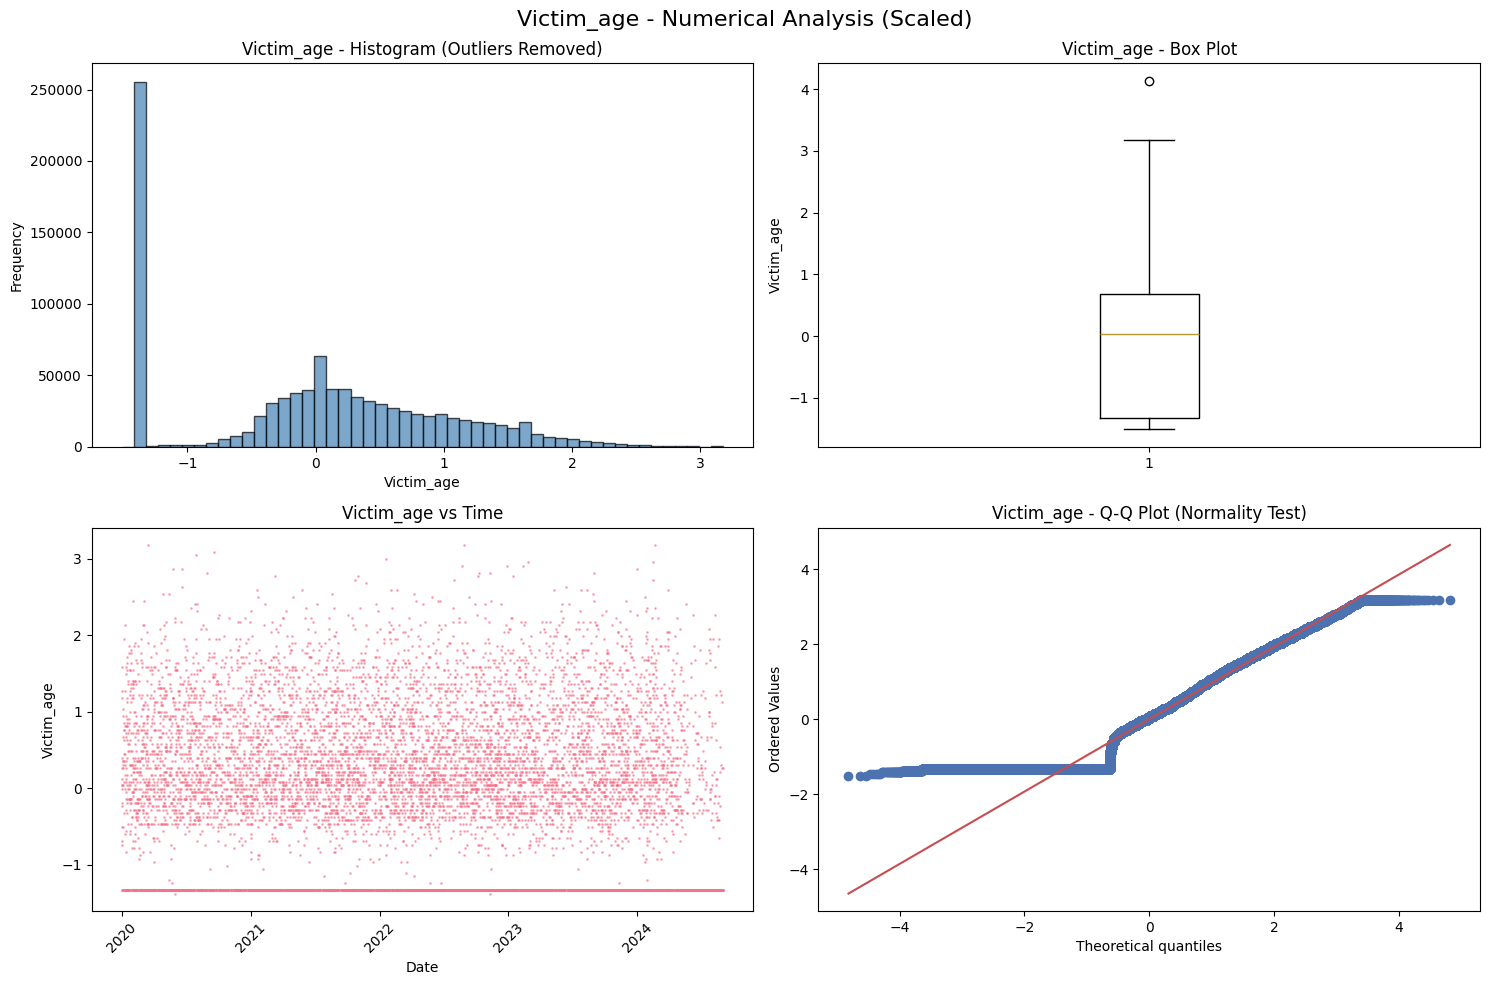


Victim_age Statistics (Scaled):
  Count: 974477
  Mean: -0.00
  Median: 0.04
  Std: 1.00
  Min: -1.51
  Max: 4.14
  Missing: 0
  Outliers (IQR method): 1


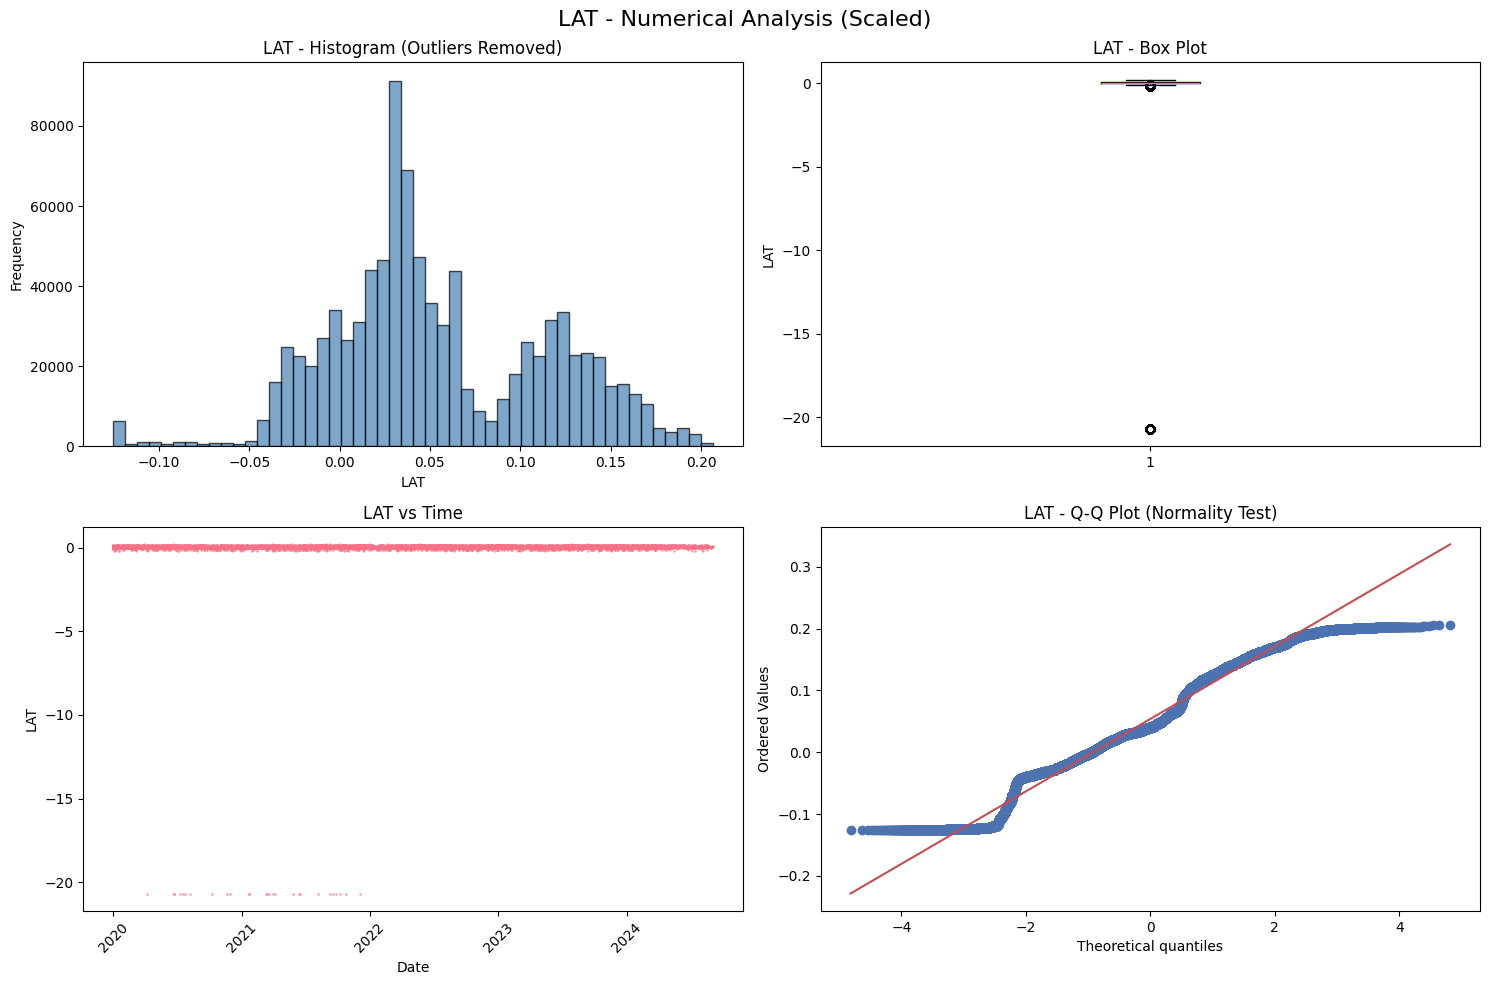


LAT Statistics (Scaled):
  Count: 974477
  Mean: -0.00
  Median: 0.04
  Std: 1.00
  Min: -20.68
  Max: 0.21
  Missing: 0
  Outliers (IQR method): 30048


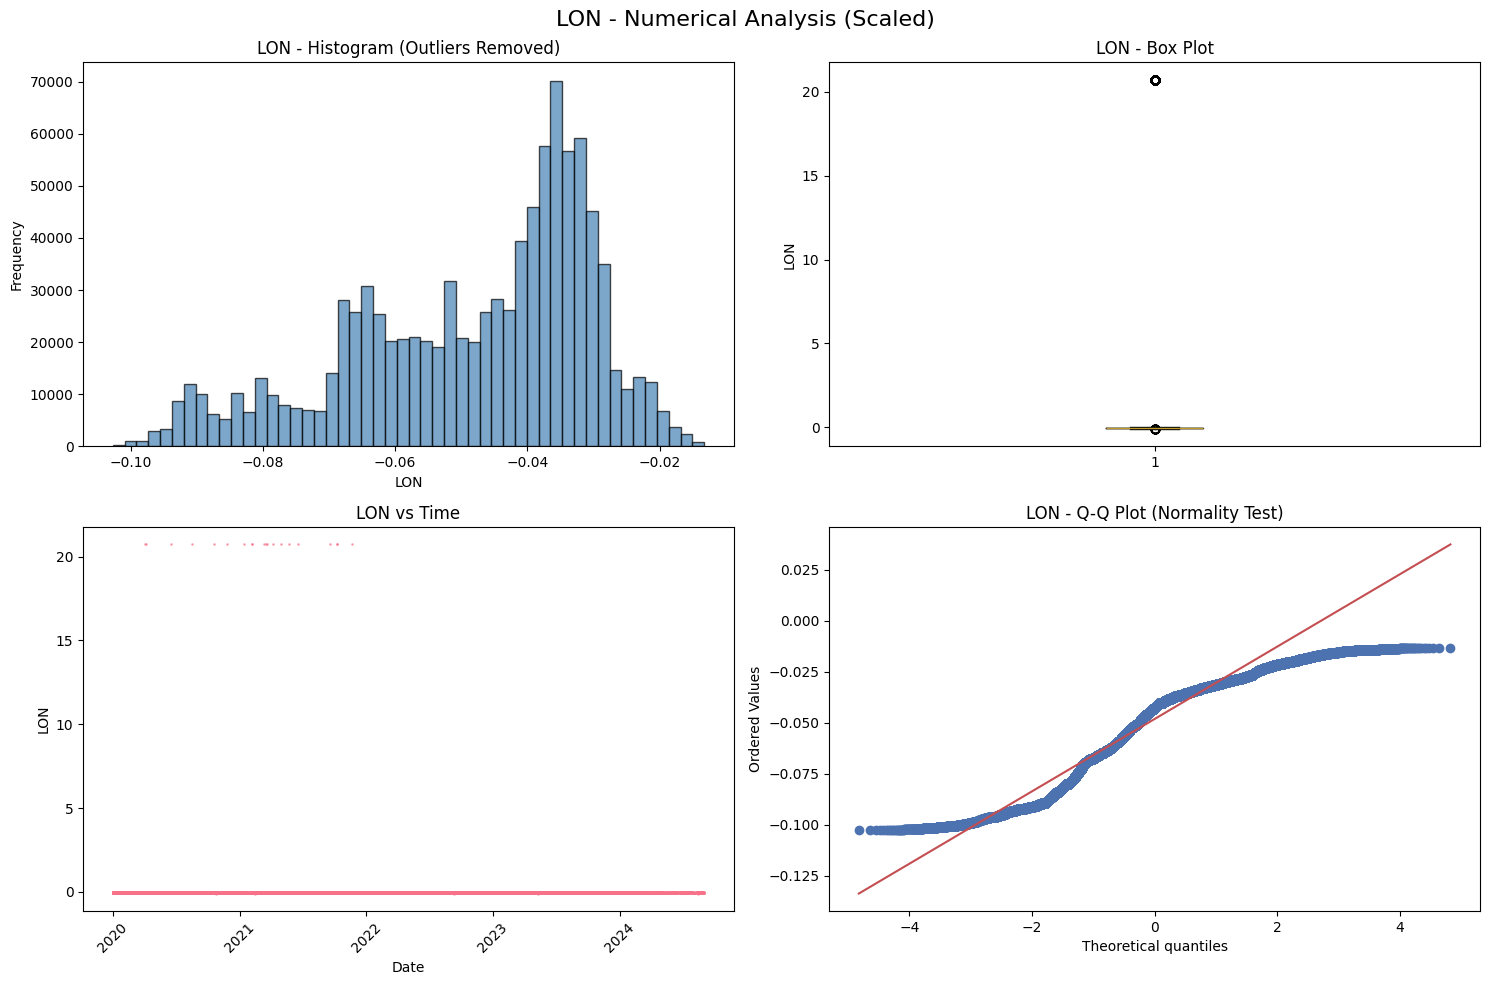


LON Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.04
  Std: 1.00
  Min: -0.10
  Max: 20.73
  Missing: 0
  Outliers (IQR method): 2291


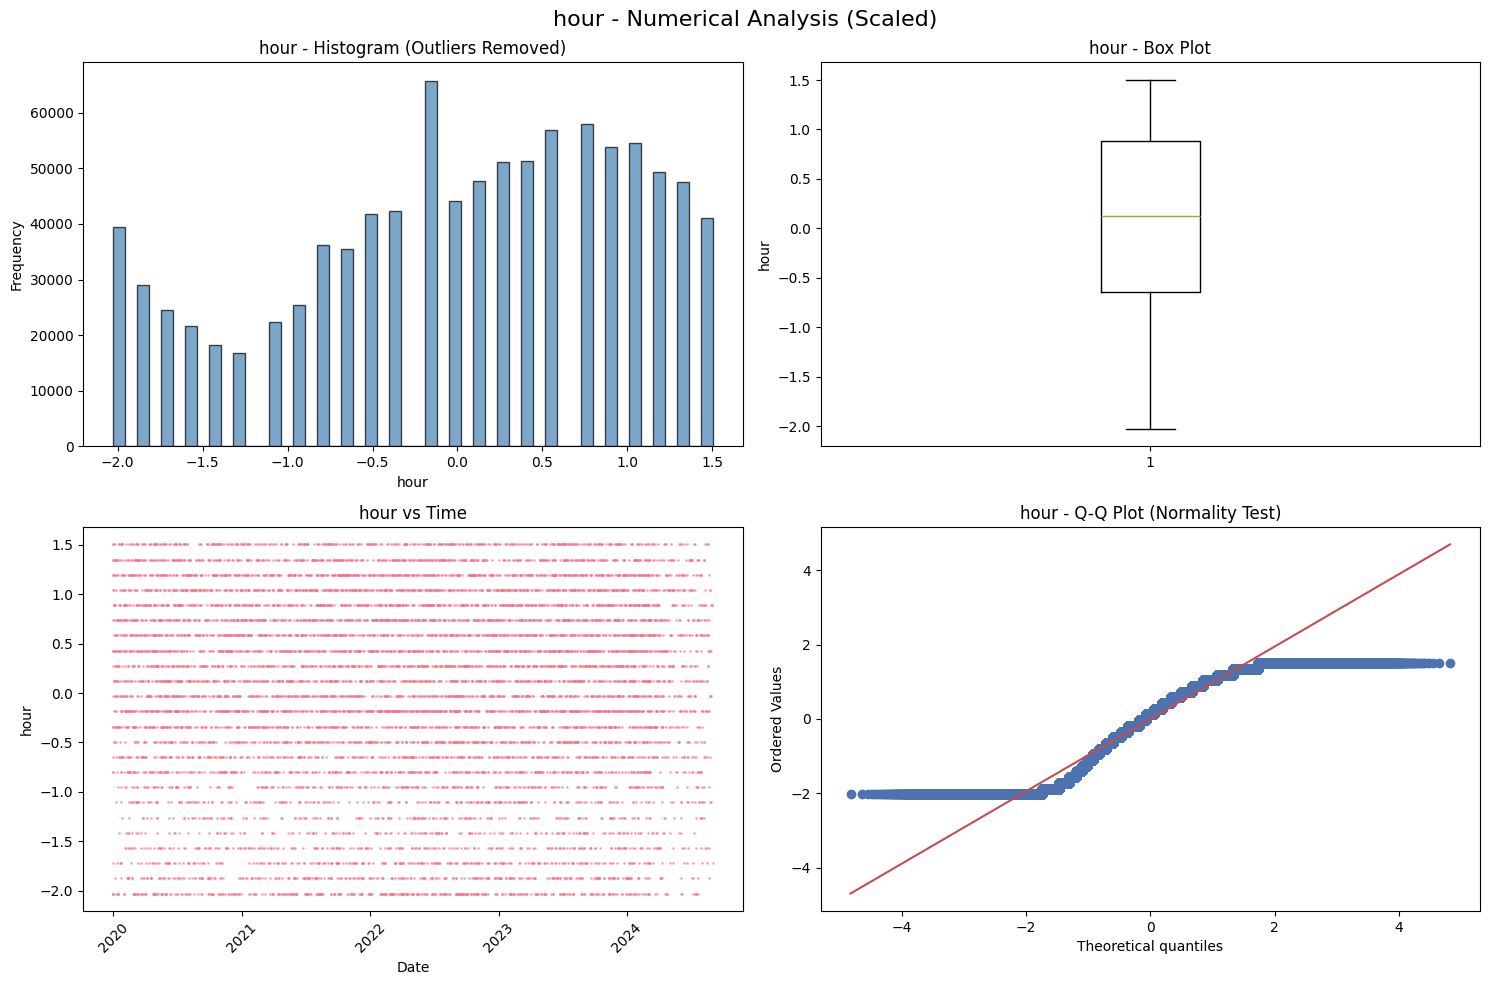


hour Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: 0.12
  Std: 1.00
  Min: -2.03
  Max: 1.50
  Missing: 0
  Outliers (IQR method): 0


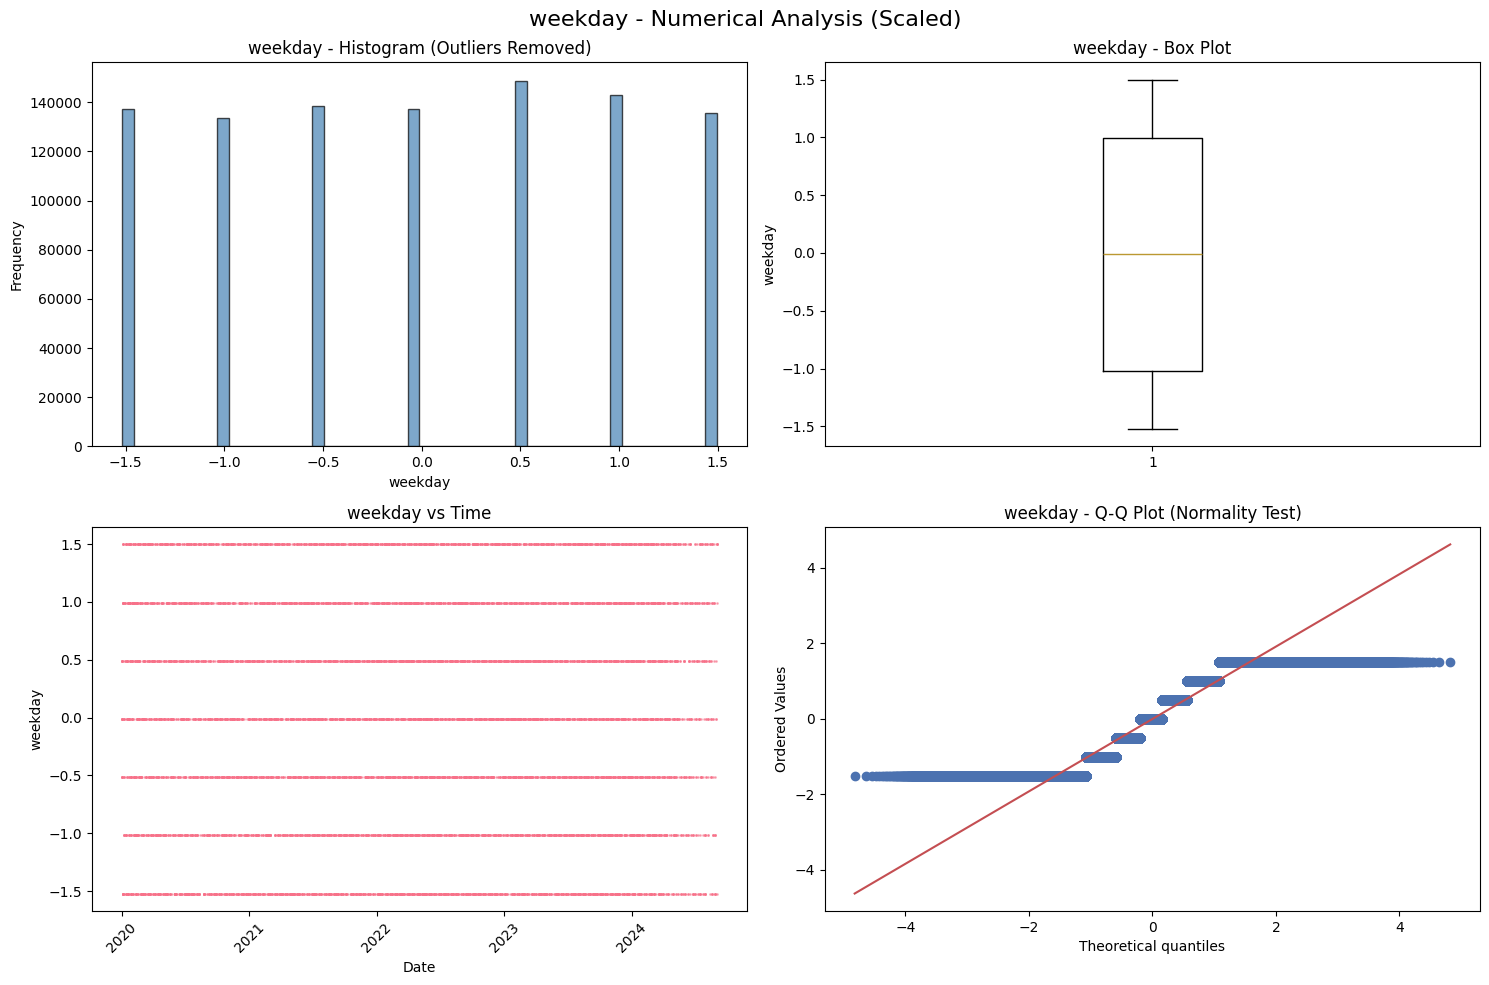


weekday Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.01
  Std: 1.00
  Min: -1.52
  Max: 1.50
  Missing: 0
  Outliers (IQR method): 0


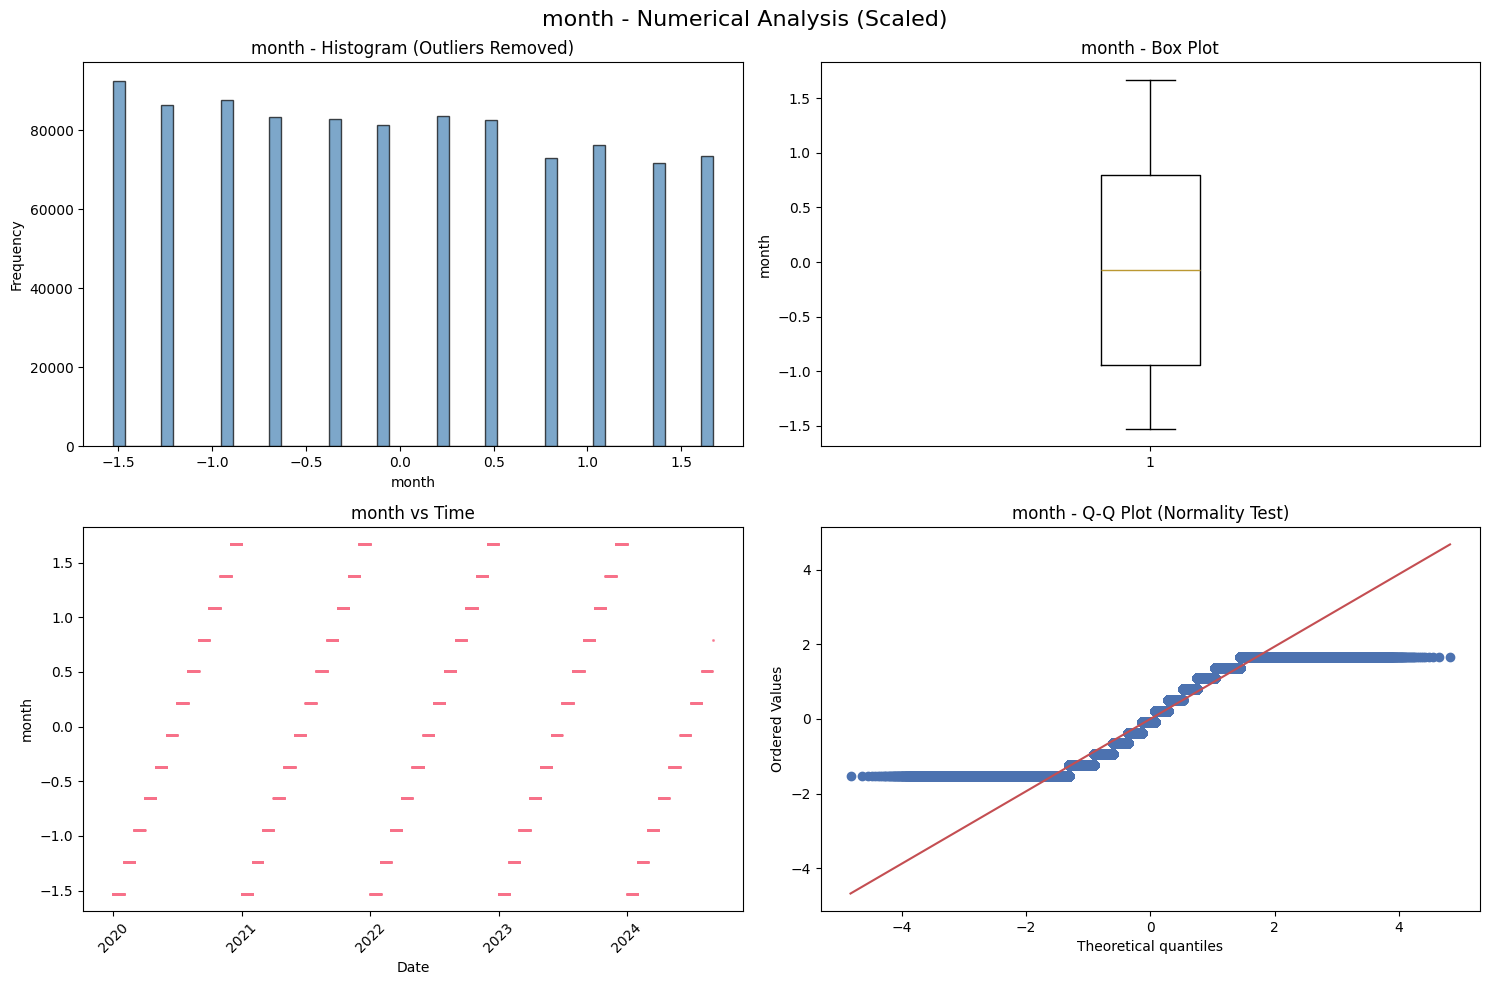


month Statistics (Scaled):
  Count: 974477
  Mean: -0.00
  Median: -0.07
  Std: 1.00
  Min: -1.53
  Max: 1.67
  Missing: 0
  Outliers (IQR method): 0


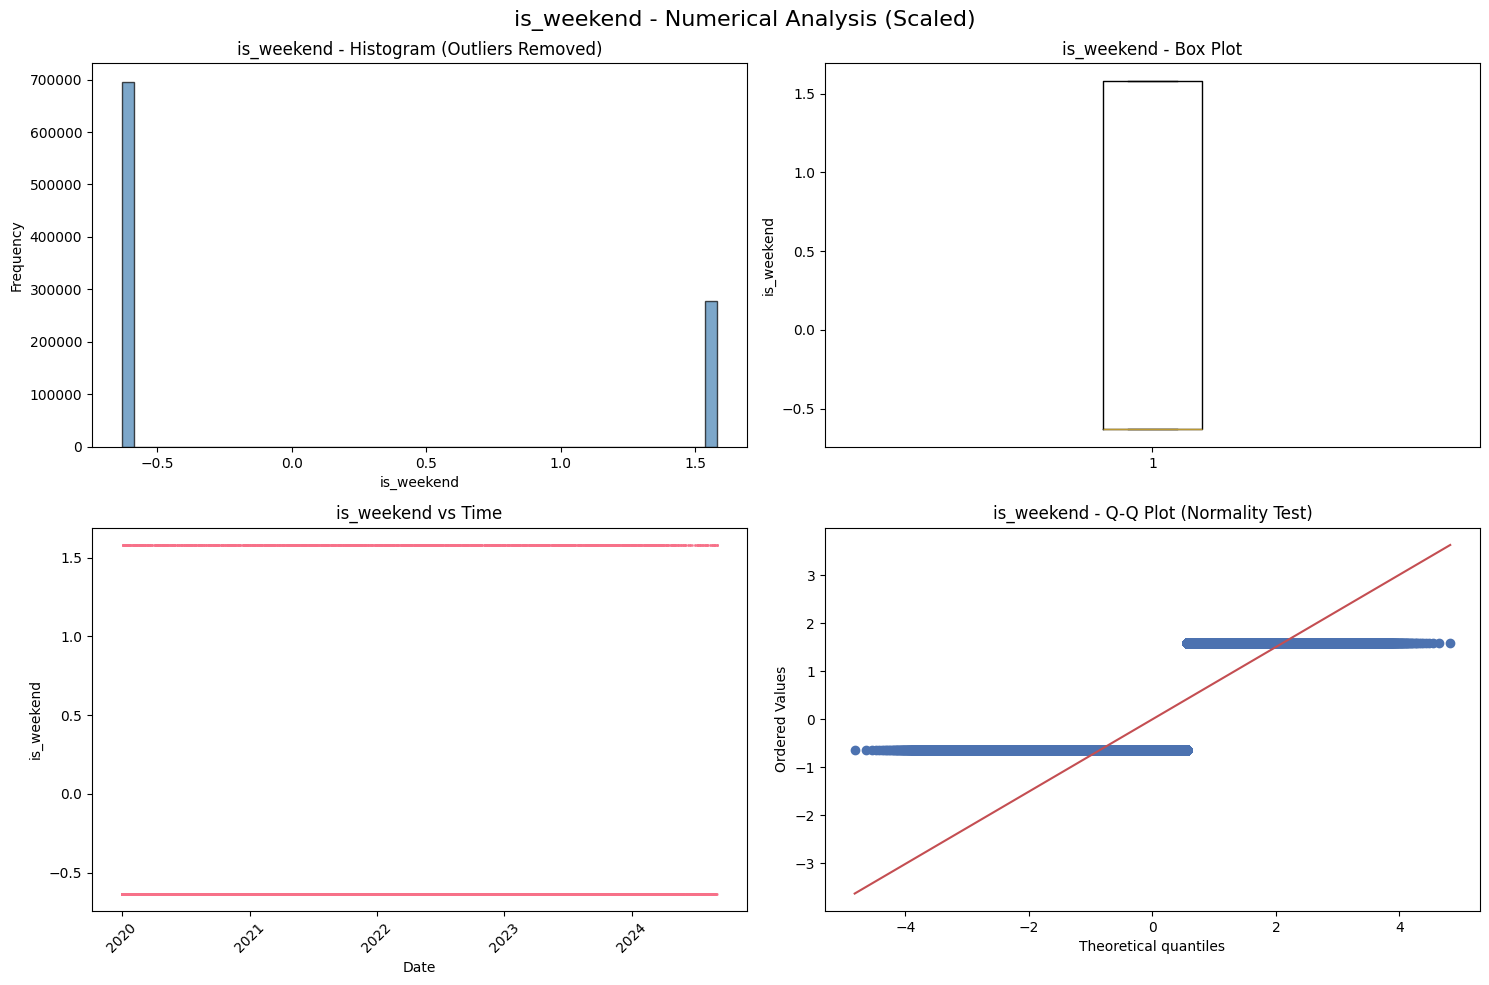


is_weekend Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.63
  Std: 1.00
  Min: -0.63
  Max: 1.58
  Missing: 0
  Outliers (IQR method): 0


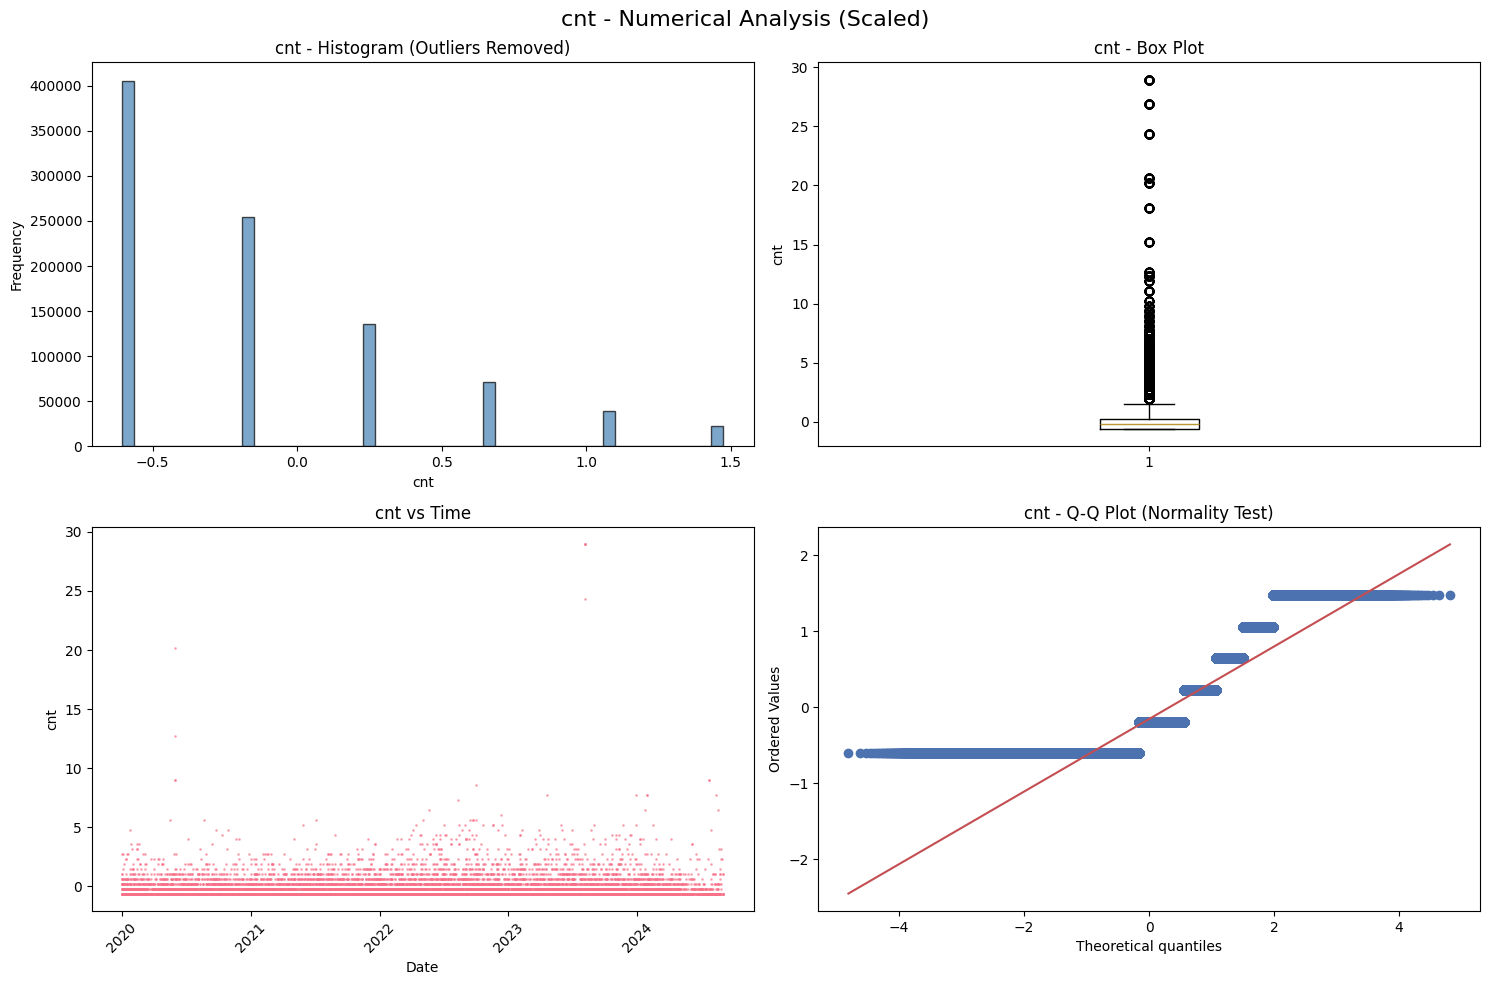


cnt Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.19
  Std: 1.00
  Min: -0.61
  Max: 28.94
  Missing: 0
  Outliers (IQR method): 46615


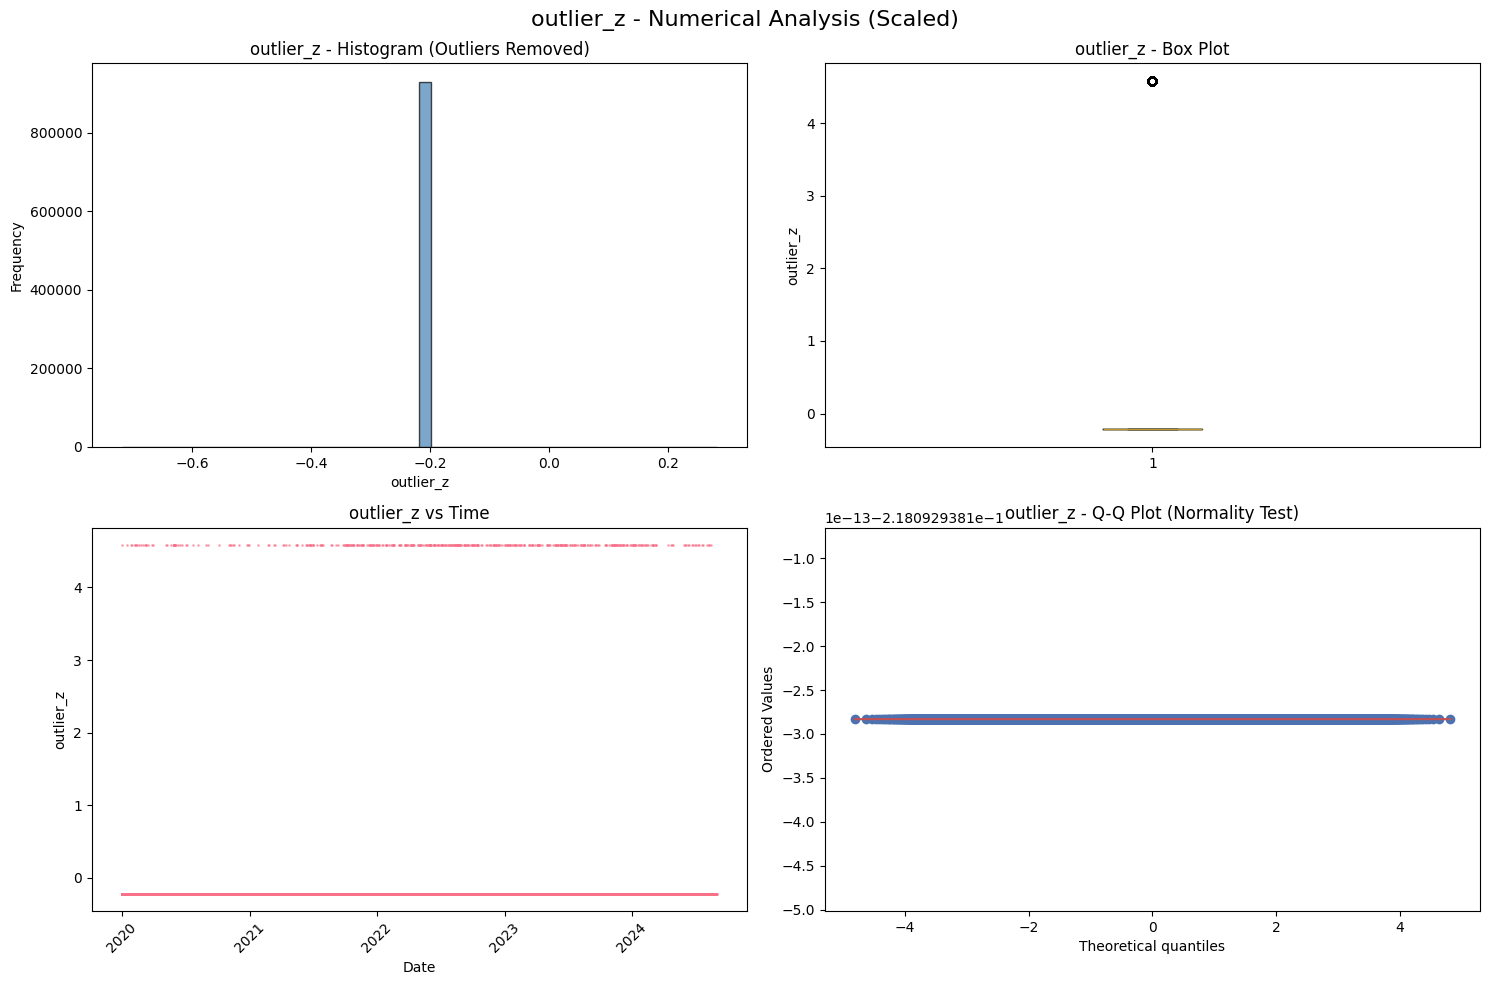


outlier_z Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.22
  Std: 1.00
  Min: -0.22
  Max: 4.59
  Missing: 0
  Outliers (IQR method): 44246


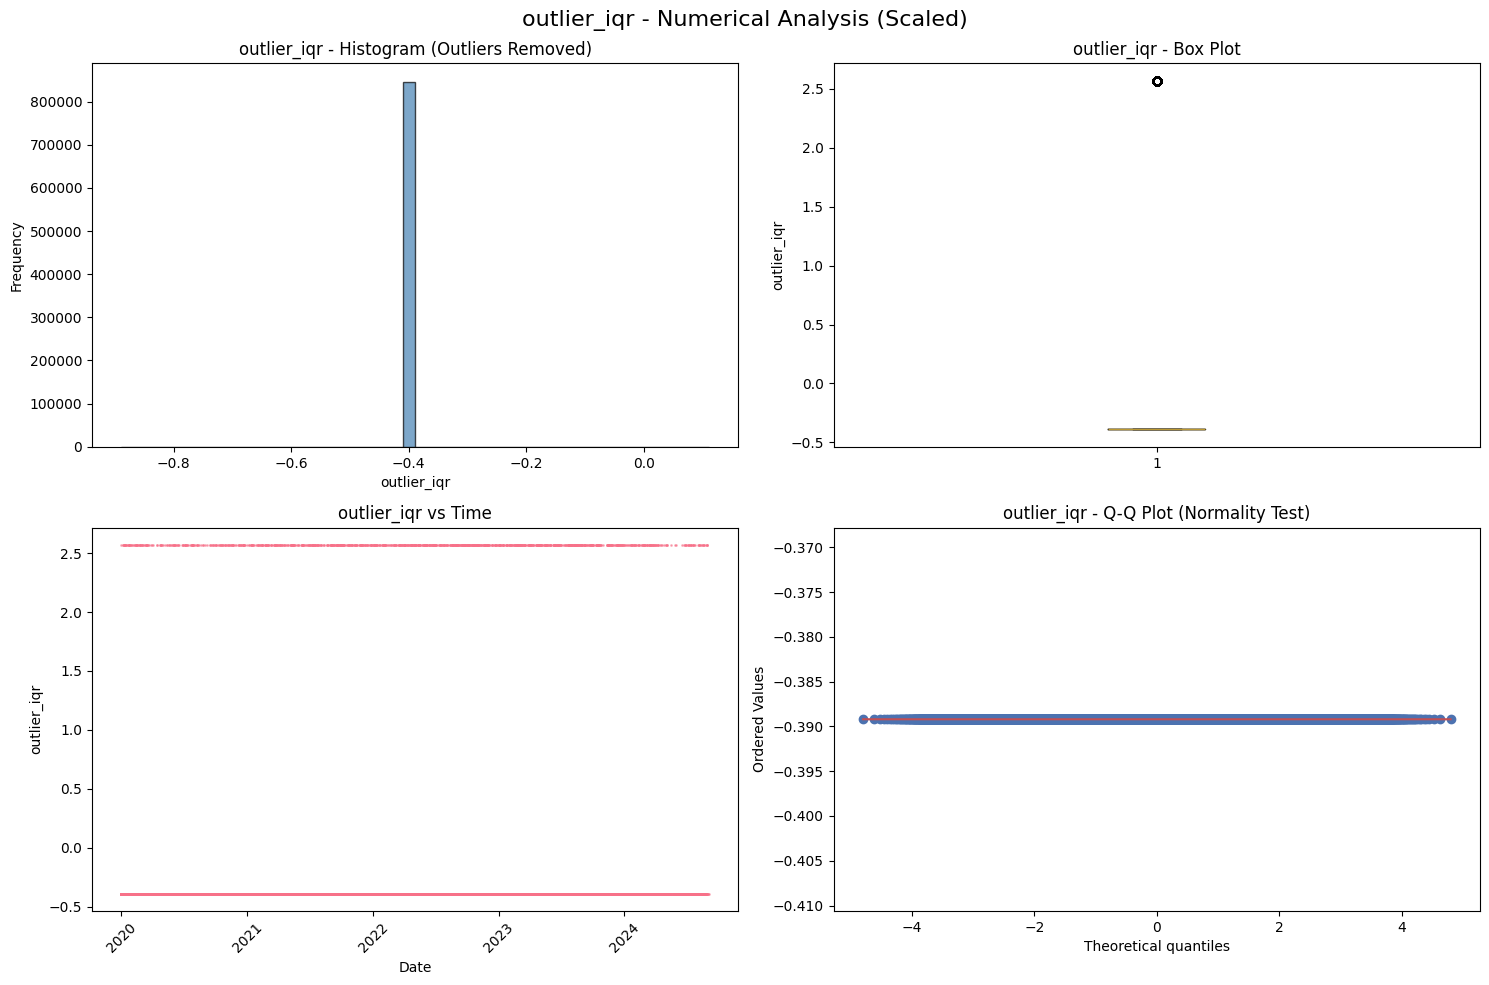


outlier_iqr Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.39
  Std: 1.00
  Min: -0.39
  Max: 2.57
  Missing: 0
  Outliers (IQR method): 128193


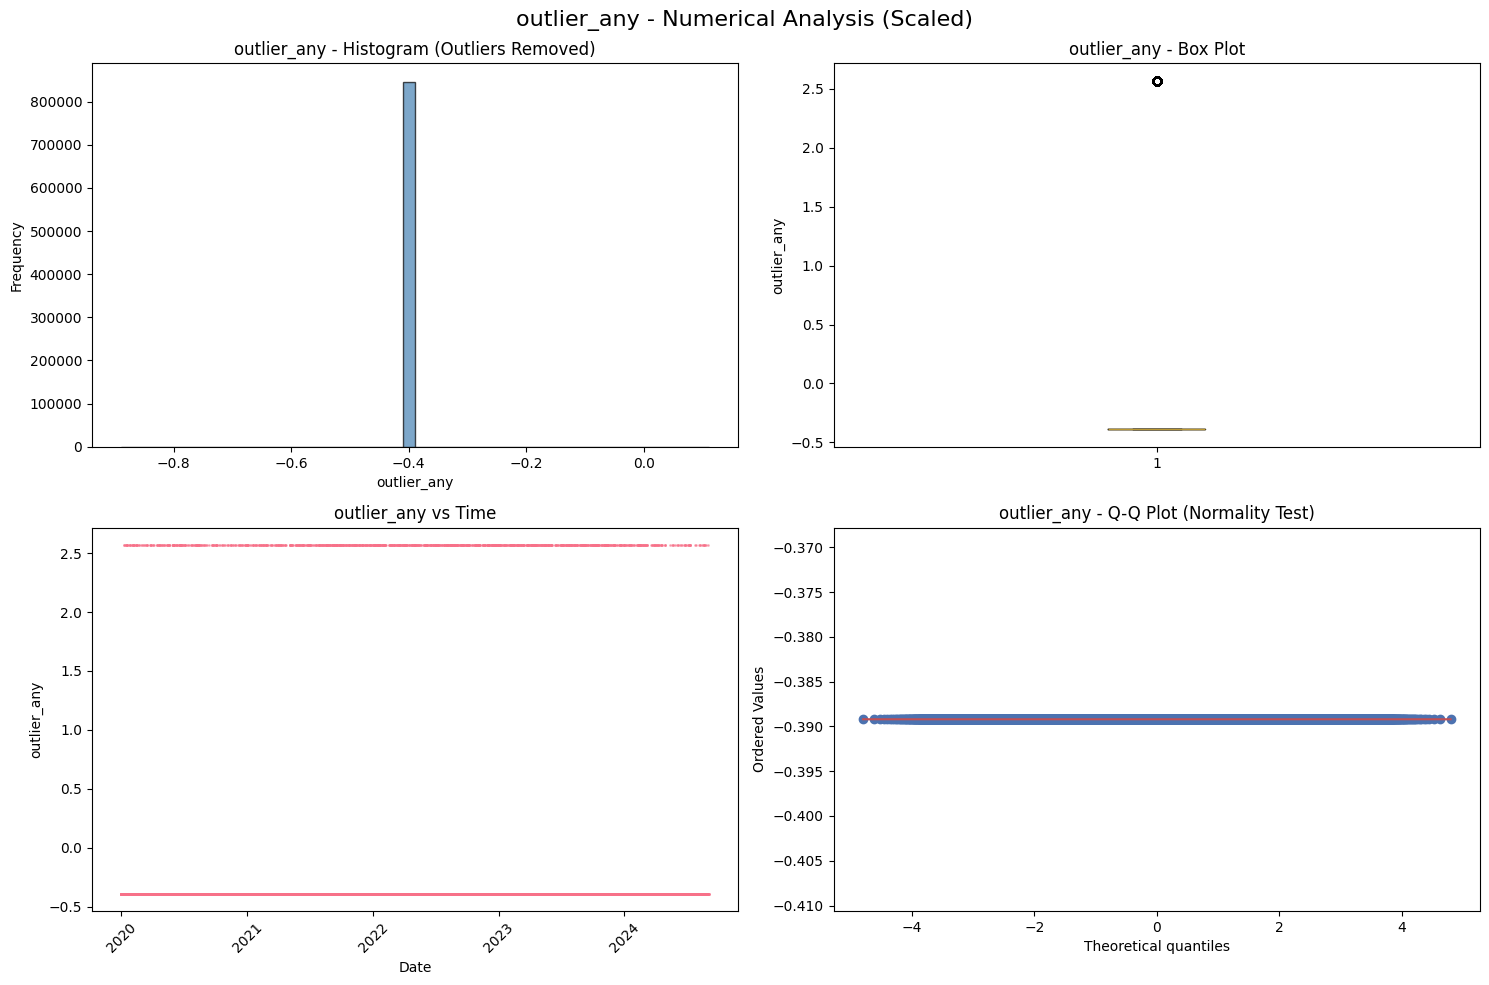


outlier_any Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.39
  Std: 1.00
  Min: -0.39
  Max: 2.57
  Missing: 0
  Outliers (IQR method): 128193

2. CORRELATION ANALYSIS (SCALED):


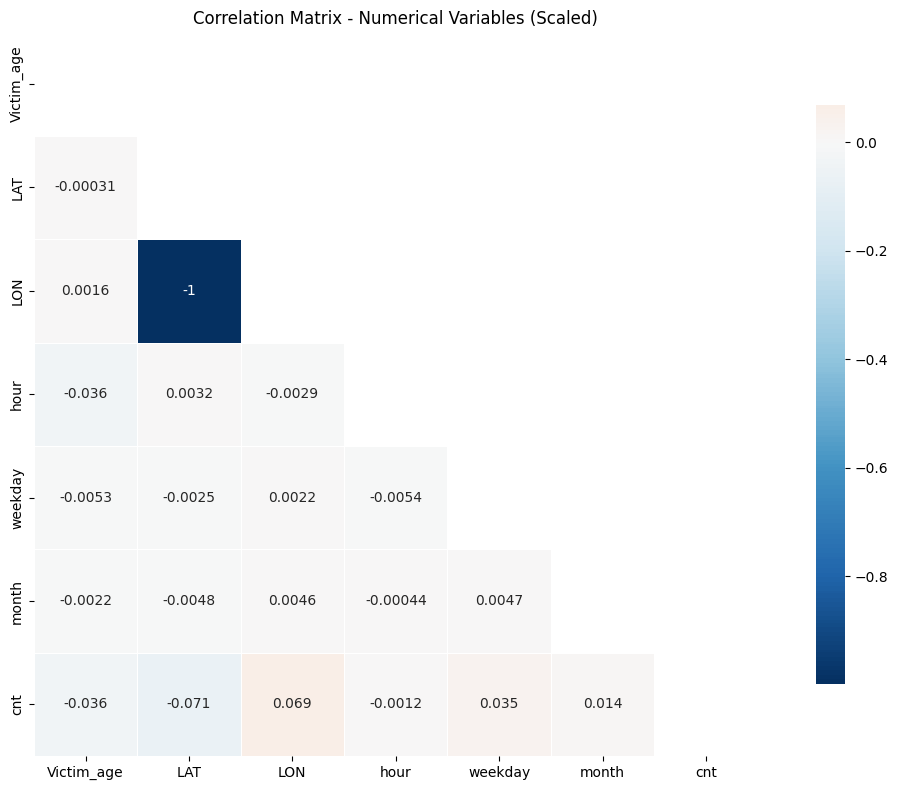


Strong Correlations (|r| > 0.5) (Scaled):
  LAT ↔ LON: -0.998

=== ANALYSIS COMPLETE (SCALED DATA) ===
📊 All distribution plots generated for scaled data!
📈 Check the correlation matrix for interesting relationships in scaled data
📋 Review the printed statistics for data quality insights on scaled data


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import ceil
from sklearn.preprocessing import StandardScaler

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("=== DISTRIBUTION ANALYSIS (SCALED DATA) ===\n")

# Identify numerical columns (assuming numerical_cols is already defined from previous steps)
if 'numerical_cols' not in locals():
    print("Error: 'numerical_cols' not found. Please run the previous cell to define it.")
else:
    # Apply Standard Scaler to numerical columns
    scaler = StandardScaler()
    df_scaled = df[numerical_cols].copy() # Create a copy to avoid modifying original df
    # Handle potential NaNs before scaling by imputing (e.g., with median or mean)
    # For simplicity, let's fill NaNs with the mean before scaling
    df_scaled = df_scaled.fillna(df_scaled.mean())
    df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])


    # ====== NUMERICAL DISTRIBUTIONS (Histograms + Scatter Plots) ======
    print("\n1. NUMERICAL DISTRIBUTIONS (SCALED):")

    def plot_numerical_distribution(col):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{col} - Numerical Analysis (Scaled)', fontsize=16)

        # Remove outliers for better visualization (using IQR on scaled data)
        Q1 = df_scaled[col].quantile(0.25)
        Q3 = df_scaled[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = df_scaled[col][(df_scaled[col] >= lower_bound) & (df_scaled[col] <= upper_bound)]

        # 1. Histogram
        axes[0, 0].hist(filtered_data.dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[0, 0].set_title(f'{col} - Histogram (Outliers Removed)')
        axes[0, 0].set_xlabel(col)
        axes[0, 0].set_ylabel('Frequency')

        # 2. Box plot
        axes[0, 1].boxplot(df_scaled[col].dropna(), vert=True)
        axes[0, 1].set_title(f'{col} - Box Plot')
        axes[0, 1].set_ylabel(col)

        # 3. Scatter plot vs date (if date column exists in original df - scaling doesn't change dates)
        if 'date' in df.columns: # Use original df for date
             # Need to align scaled data with original dates
            temp_df = pd.DataFrame({col: df_scaled[col], 'date': df['date']})
            sample_data = temp_df.sample(min(10000, len(temp_df)))  # Sample for performance
            axes[1, 0].scatter(sample_data['date'], sample_data[col], alpha=0.5, s=1)
            axes[1, 0].set_title(f'{col} vs Time')
            axes[1, 0].set_xlabel('Date')
            axes[1, 0].set_ylabel(col)
            axes[1, 0].tick_params(axis='x', rotation=45)
        else:
             axes[1, 0].set_title('Date column not available')


        # 4. Q-Q plot for normality check
        from scipy import stats
        stats.probplot(filtered_data.dropna(), dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title(f'{col} - Q-Q Plot (Normality Test)')

        plt.tight_layout()
        plt.show()

        # Print detailed stats
        print(f"\n{col} Statistics (Scaled):")
        print(f"  Count: {df_scaled[col].count()}")
        print(f"  Mean: {df_scaled[col].mean():.2f}")
        print(f"  Median: {df_scaled[col].median():.2f}")
        print(f"  Std: {df_scaled[col].std():.2f}")
        print(f"  Min: {df_scaled[col].min():.2f}")
        print(f"  Max: {df_scaled[col].max():.2f}")
        print(f"  Missing: {df_scaled[col].isnull().sum()}")
        print(f"  Outliers (IQR method): {((df_scaled[col] < lower_bound) | (df_scaled[col] > upper_bound)).sum()}")

    # Plot numerical distributions
    for col in numerical_cols:
        if df_scaled[col].nunique() > 1 and df_scaled[col].notna().sum() > 0:
            plot_numerical_distribution(col)

    # ====== CORRELATION MATRIX FOR NUMERICAL COLUMNS ======
    print("\n2. CORRELATION ANALYSIS (SCALED):")

    # Select numerical columns with sufficient data
    corr_cols = [col for col in numerical_cols if df_scaled[col].notna().sum() > 100 and df_scaled[col].nunique() > 2]

    if len(corr_cols) > 1:
        plt.figure(figsize=(12, 8))
        correlation_matrix = df_scaled[corr_cols].corr()

        # Create correlation heatmap
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Correlation Matrix - Numerical Variables (Scaled)')
        plt.tight_layout()
        plt.show()

        # Print strong correlations
        print("\nStrong Correlations (|r| > 0.5) (Scaled):")
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.5:
                    col1, col2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
                    print(f"  {col1} ↔ {col2}: {corr_val:.3f}")
    else:
        print("Not enough numerical columns with sufficient data to compute correlation.")


    print("\n=== ANALYSIS COMPLETE (SCALED DATA) ===")
    print("📊 All distribution plots generated for scaled data!")
    print("📈 Check the correlation matrix for interesting relationships in scaled data")
    print("📋 Review the printed statistics for data quality insights on scaled data")

#functions

imports

In [98]:
!pip install hmmlearn
import hmmlearn
from hmmlearn import hmm
print(hmm.__file__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.0 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/hmmlearn/hmm.py


In [99]:
# Core
import numpy as np, pandas as pd, warnings, math, json, os, re
from datetime import datetime

# Sklearn – models & reductions
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, NMF, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, average_precision_score,
                             precision_recall_curve, brier_score_loss, confusion_matrix,
                             silhouette_score, calinski_harabasz_score)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit

# Optional libs – guard imports
try:
    import umap  # umap-learn
except Exception:
    umap = None

try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import networkx as nx
except Exception:
    nx = None

try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
except Exception:
    sm = None
    smf = None

try:
    from hmmlearn.hmm import GaussianHMM
except Exception:
    GaussianHMM = None

# Torch (for LSTM/GRU/TCN)
try:
    import torch, torch.nn as nn
except Exception:
    torch = None
    nn = None

warnings.filterwarnings("ignore")


In [100]:
# ==========================================================
# LAPD CRIME — EXTENDED METHODS TOOLBOX (creative + booky)
# ==========================================================
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional, Callable
from dataclasses import dataclass

# -----------------------------------------------------------------------------------
# 0) SHARED UTILITIES (works with your engineered columns; compatible with your code)
# -----------------------------------------------------------------------------------
# --- DROP-IN: robust, date-aware splitter for any panel ---
def time_split(df, date_col="date", q_train=0.70, q_val=0.85, min_each=50):
    """
    Split by actual date distribution so you never get empty folds.
    q_train, q_val are quantiles on the date.
    Ensures each split has >= min_each rows; if not, relaxes thresholds.
    """
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.sort_values(date_col)
    if d.empty:
        raise ValueError("Empty dataframe passed to time_split_auto.")

    # start with requested quantiles
    q1, q2 = q_train, q_val
    for _ in range(5):  # at most 5 relaxations
        cut1 = d[date_col].quantile(q1)
        cut2 = d[date_col].quantile(q2)
        train = d[d[date_col] <= cut1]
        val   = d[(d[date_col] > cut1) & (d[date_col] <= cut2)]
        test  = d[d[date_col] > cut2]
        if min(len(train), len(val), len(test)) >= min_each:
            print(f"[split] train_end={cut1.date()}  val_end={cut2.date()}  "
                  f"sizes=({len(train)}, {len(val)}, {len(test)})")
            return train, val, test
        # relax towards more balanced splits
        q1 = max(0.55, q1 - 0.05)
        q2 = min(0.95, q2 + 0.05)

    # last resort: simple 60/20/20 by index (still time-ordered)
    n = len(d)
    i1 = int(0.6*n); i2 = int(0.8*n)
    train, val, test = d.iloc[:i1], d.iloc[i1:i2], d.iloc[i2:]
    print("[split] fell back to index-based 60/20/20 "
          f"sizes=({len(train)}, {len(val)}, {len(test)})")
    return train, val, test


# -----------------------------------
# 1) FEATURE & SIGNAL ENGINEERING
# -----------------------------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def preproc(num_cols, cat_cols, scale_numeric=True, min_freq=5):
    num_pipe = [("impute", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_pipe.append(("scale", StandardScaler()))
    num_pipe = Pipeline(num_pipe)
    cat_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq)),
    ])
    return ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

def poly_features(num_cols, degree=2, interaction_only=False):
    """Create polynomial/interaction features for numeric set only."""
    return PolynomialFeatures(degree=degree, include_bias=False, interaction_only=interaction_only)

def calendar_fourier(df: pd.DataFrame, col="dayofyear", K=3):
    """Seasonality via Fourier terms on day-of-year (2K features)."""
    d = df.copy()
    if col not in d:
        d[col] = pd.to_datetime(d["date"]).dt.dayofyear
    for k in range(1, K+1):
        d[f"fourier_sin_{k}"] = np.sin(2*np.pi*k*d[col]/365.25)
        d[f"fourier_cos_{k}"] = np.cos(2*np.pi*k*d[col]/365.25)
    return d

def lagged_counts(df_cell_daily: pd.DataFrame, lags: List[int], target="cnt"):
    """Append lag features per (h3,date) panel."""
    out = df_cell_daily.sort_values(["h3","date"]).copy()
    for L in lags:
        out[f"lag_{L}"] = out.groupby("h3")[target].shift(L).fillna(0.0)
    return out

# ----------------------------------------------------------
# 2) DIMENSION REDUCTION GALORE (linear + non-linear, Ch.10)
# ----------------------------------------------------------
from sklearn.decomposition import PCA, NMF, TruncatedSVD, FactorAnalysis, FastICA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, TSNE, SpectralEmbedding
from sklearn.decomposition import KernelPCA

def fit_pca(X, n=12, whiten=False):              p = PCA(n_components=n, whiten=whiten, random_state=42);  return p.fit_transform(X), p
def fit_svd(X, n=20):                             s = TruncatedSVD(n_components=n, random_state=42);        return s.fit_transform(X), s
def fit_fa(X, n=10):                              f = FactorAnalysis(n_components=n, random_state=42);      return f.fit_transform(X), f
def fit_ica(X, n=10):                             i = FastICA(n_components=n, random_state=42);             return i.fit_transform(X), i
def fit_nmf(X_nonneg, n=12):                      m = NMF(n_components=n, init="nndsvda", random_state=42); return m.fit_transform(np.clip(X_nonneg,0,None)), m
def fit_kpca(X, n=10, kernel="rbf", gamma=None):  kp= KernelPCA(n_components=n, kernel=kernel, gamma=gamma, random_state=42); return kp.fit_transform(X), kp
def fit_isomap(X, n=10, n_neighbors=10):          im= Isomap(n_neighbors=n_neighbors, n_components=n);      return im.fit_transform(X), im
def fit_lle(X, n=10, n_neighbors=10, method="standard"):
    lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n, method=method, random_state=42)
    return lle.fit_transform(X), lle
def fit_mds(X, n=2, metric=True):                 md= MDS(n_components=n, metric=metric, random_state=42, n_init=4, max_iter=600); return md.fit_transform(X), md
def fit_tsne(X, n=2, perplexity=30):              t = TSNE(n_components=n, perplexity=perplexity, random_state=42, init="pca", learning_rate="auto"); return t.fit_transform(X), t
def fit_spec_embed(X, n=10, neighbors=10):        se= SpectralEmbedding(n_components=n, n_neighbors=neighbors, affinity="nearest_neighbors", random_state=42); return se.fit_transform(X), se

# ---------------------------
# 3) CLUSTERING (Ch. 9 & 12)
# ---------------------------
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def cluster_kmeans(X, k=8):              km = KMeans(n_clusters=k, n_init="auto", random_state=42); labels=km.fit_predict(X); return labels, km
def cluster_dbscan(X, eps=0.5, min_samples=12): db = DBSCAN(eps=eps, min_samples=min_samples); labels=db.fit_predict(X); return labels, db
def cluster_optics(X, min_samples=15, xi=0.05): op = OPTICS(min_samples=min_samples, xi=xi); labels=op.fit_predict(X); return labels, op
def cluster_agglom(X, k=8, linkage="ward"):      ag = AgglomerativeClustering(n_clusters=k, linkage=linkage); labels=ag.fit_predict(X); return labels, ag
def cluster_spectral(X, k=8):                    sc = SpectralClustering(n_clusters=k, affinity="nearest_neighbors", random_state=42); labels=sc.fit_predict(X); return labels, sc

def cluster_quality(X, labels):
    uniq = np.unique(labels)
    if len(uniq) < 2 or (len(uniq)==1 and uniq[0]==-1):
        return {"silhouette": np.nan, "calinski": np.nan, "davies": np.nan}
    return {
        "silhouette": silhouette_score(X, labels),
        "calinski": calinski_harabasz_score(X, labels),
        "davies": davies_bouldin_score(X, labels)
    }

# -------------------------------------------------------
# 4) CLASSIFICATION (linear, margin, trees, NN, Ch. 3/7)
# -------------------------------------------------------
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix

def fit_logreg(X, y, num, cat, C=1.0, l1=False, class_weight="balanced"):
    pre = preproc(num, cat, scale_numeric=False)
    penalty = "l1" if l1 else "l2"
    solver  = "liblinear" if l1 else "lbfgs"
    clf = LogisticRegression(C=C, penalty=penalty, solver=solver, class_weight=class_weight, max_iter=1000)
    model = Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)
    return model

def fit_linear_svm(X, y, num, cat, C=1.0):  # hinge loss (SGD for large scale optional)
    pre = preproc(num, cat, scale_numeric=True)
    clf = LinearSVC(C=C, class_weight="balanced")   # decision_function for scores
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def fit_svm_rbf(X, y, num, cat, C=1.0, gamma="scale"):
    pre = preproc(num, cat, scale_numeric=True)
    clf = SVC(kernel="rbf", C=C, gamma=gamma, probability=True, class_weight="balanced")
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def fit_knn(X, y, num, cat, k=15):
    pre = preproc(num, cat, scale_numeric=True)
    clf = KNeighborsClassifier(n_neighbors=k)
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def fit_rf(X, y, num, cat, n_estimators=400, max_depth=None):
    pre = preproc(num, cat, scale_numeric=False)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight="balanced",
                                 random_state=42, n_jobs=-1)
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def fit_gb(X, y, num, cat, lr=0.05, n_estimators=400, max_depth=3):
    pre = preproc(num, cat, scale_numeric=False)
    clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def fit_extra_trees(X, y, num, cat, n_estimators=500, max_depth=None):
    pre = preproc(num, cat, scale_numeric=False)
    clf = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight="balanced",
                               random_state=42, n_jobs=-1)
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def fit_mlp(X, y, num, cat, hidden=(256,128), alpha=1e-4):
    pre = preproc(num, cat, scale_numeric=True)
    clf = MLPClassifier(hidden_layer_sizes=hidden, alpha=alpha, batch_size=256,
                        learning_rate_init=1e-3, max_iter=200, random_state=42)
    return Pipeline([("pre", pre), ("clf", clf)]).fit(X, y)

def eval_clf(model, X, y, label=""):
    yhat = model.predict(X)
    out = {
        "acc": accuracy_score(y, yhat),
        "f1_macro": f1_score(y, yhat, average="macro"),
        "report": classification_report(y, yhat, digits=3),
        "confusion": confusion_matrix(y, yhat)
    }
    # add ROC/PR if proba exists and binary
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        if p.shape[1] == 2:
            out["roc_auc"] = roc_auc_score(y, p[:,1])
            out["ap"] = average_precision_score(y, p[:,1])
    print(f"[{label}] acc={out['acc']:.4f} f1_macro={out['f1_macro']:.4f}")
    return out

# ------------------------------------------------------------
# 5) CALIBRATION & THRESHOLDS (risk estimation, Ch. 5–6)
# ------------------------------------------------------------
from sklearn.calibration import CalibratedClassifierCV

def calibrate(model, X_train, y_train, method="isotonic", cv=3):
    """Wrap a fitted pipeline with probability calibration (Platt or isotonic)."""
    if hasattr(model, "predict_proba") or hasattr(model, "decision_function"):
        cal = CalibratedClassifierCV(model, method=method, cv=cv)
        return cal.fit(X_train, y_train)
    else:
        raise ValueError("Model must support decision_function or predict_proba for calibration.")

def tune_threshold(y_true, y_prob: np.ndarray, metric: Callable):
    """
    Simple threshold search for binary tasks.
    metric: function(y_true, y_pred) -> score (maximize).
    """
    best_t, best_s = 0.5, -np.inf
    for t in np.linspace(0.05, 0.95, 19):
        s = metric(y_true, (y_prob >= t).astype(int))
        if s > best_s: best_t, best_s = t, s
    return best_t, best_s

# ---------------------------------------------------
# 6) COUNT MODELS & TIME-SERIES (Poisson + baselines)
# ---------------------------------------------------
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def fit_poisson(X, y, num, cat, alpha=0.0):
    pre = preproc(num, cat, scale_numeric=True)
    pr  = PoissonRegressor(alpha=alpha, max_iter=2000)
    return Pipeline([("pre", pre), ("poisson", pr)]).fit(X, y)

def eval_reg(model, X, y, label=""):
    pred = np.clip(model.predict(X), 0, None)
    mae  = mean_absolute_error(y, pred)
    rmse = mean_squared_error(y, pred, squared=False)
    print(f"[{label}] MAE={mae:.3f} RMSE={rmse:.3f}")
    return {"mae": mae, "rmse": rmse}

def hotspot_hit_rate(y_true_counts: np.ndarray, y_scores: np.ndarray, top_frac=0.05):
    """% of incidents captured inside top X% highest-risk cells."""
    n = len(y_scores)
    k = max(1, int(np.ceil(top_frac*n)))
    idx = np.argsort(-y_scores)[:k]
    return (y_true_counts[idx].sum() / y_true_counts.sum()) if y_true_counts.sum() > 0 else np.nan

# ------------------------------------------
# 7) DENSITY / MIXTURES / ANOMALY DETECTION
# ------------------------------------------
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

def fit_gmm(X, n_components=6, covariance_type="full", random_state=42):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=random_state)
    return gmm.fit(X)

def score_gmm_density(gmm: GaussianMixture, X):
    """Higher is denser (log-likelihood)."""
    return gmm.score_samples(X)

def fit_lof(X, n_neighbors=20, contamination=0.02):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)
    return lof.fit(X)

def fit_isoforest(X, n_estimators=300, contamination=0.02):
    iso = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
    return iso.fit(X)

# -------------------------------------------------
# 8) SEMI-SUPERVISED (when labels are incomplete)
# -------------------------------------------------
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier

def fit_label_spreading(X, y, num, cat, kernel="rbf", alpha=0.2):
    """Assumes some y entries are -1 (unlabeled)."""
    pre = preproc(num, cat, scale_numeric=True)
    baseX = pre.fit_transform(X)
    ls = LabelSpreading(kernel=kernel, alpha=alpha)
    return ls.fit(baseX, y), pre  # return the preprocessor to transform future data

def fit_self_training(X, y, num, cat, base="logreg"):
    """Self-training wrapper around a base classifier."""
    if base == "logreg":
        inner = LogisticRegression(max_iter=1000, class_weight="balanced")
    elif base == "svm":
        inner = SVC(probability=True, class_weight="balanced")
    else:
        inner = RandomForestClassifier(n_estimators=400, class_weight="balanced", n_jobs=-1, random_state=42)
    pre = preproc(num, cat, scale_numeric=True)
    st = SelfTrainingClassifier(inner, threshold=0.8, verbose=False)
    pipe = Pipeline([("pre", pre), ("st", st)])
    return pipe.fit(X, y)

# ------------------------------------------------------
# 9) GRAPH / SPECTRAL (adjacency from H3 neighbors etc.)
# ------------------------------------------------------
def spectral_from_adjacency(A: np.ndarray, n=8):
    """Laplacian eigenmaps via spectral embedding on precomputed adjacency."""
    se = SpectralEmbedding(n_components=n, affinity="precomputed", random_state=42)
    Z = se.fit_transform(A)
    return Z, se

# -------------------------------------------------------
# 10) GENERALIZATION & OVERFITTING DEMOS (Ch. 6.5)
# -------------------------------------------------------
def shuffled_labels_demo(X, y, num, cat, fit_fn: Callable, **kwargs):
    """Show overfitting risk: train on permuted labels -> performance ~ chance."""
    y_shuf = pd.Series(y).sample(frac=1.0, random_state=42).to_numpy()
    model  = fit_fn(X, y_shuf, num, cat, **kwargs)
    return eval_clf(model, X, y_shuf, label="SHUFFLED")

# ----------------------------------------------------------
# 11) HYPERPARAM SEARCH (blocked CV / time-aware, Ch. 3.3)
# ----------------------------------------------------------
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def time_series_splits(df: pd.DataFrame, date_col="date", n_splits=5):
    d = df.sort_values(date_col).reset_index(drop=True)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    return list(tscv.split(d))

def gridsearch_timeaware(X, y, num, cat, base="svm", param_grid=None, n_splits=5, score="f1_macro"):
    if base == "svm":
        base_est = SVC(probability=True, class_weight="balanced")
        scale = True
    elif base == "logreg":
        base_est = LogisticRegression(max_iter=1000, class_weight="balanced")
        scale = False
    elif base == "mlp":
        base_est = MLPClassifier(max_iter=250, random_state=42)
        scale = True
    else:
        base_est = RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42, n_jobs=-1)
        scale = False
    pre  = preproc(num, cat, scale_numeric=scale)
    pipe = Pipeline([("pre", pre), ("clf", base_est)])

    if param_grid is None:
        param_grid = {
            "svm":    {"clf__C":[0.2,1,3], "clf__gamma":["scale",0.1,0.01], "clf__kernel":["rbf","linear"]},
            "logreg": {"clf__C":[0.2,1,3], "clf__penalty":["l2"]},
            "mlp":    {"clf__hidden_layer_sizes":[(128,), (256,128), (256,128,64)], "clf__alpha":[1e-5,1e-4,1e-3]},
            "rf":     {"clf__n_estimators":[300,500], "clf__max_depth":[None,12,20]}
        }.get(base, {})
    g = GridSearchCV(pipe, param_grid=param_grid, scoring=score, cv=n_splits, n_jobs=-1)
    g.fit(X, y)
    return g

# ------------------------------------------------
# 12) CONFORMAL PREDICTION (calibrated sets/intervals)
# ------------------------------------------------
def split_conformal_classifier(probs_val: np.ndarray, y_val: np.ndarray, q: float=0.1):
    """
    Multi-class naive conformal: build per-sample score as 1 - prob(true class).
    Returns tau (threshold); prediction set = {k: p_k >= 1 - tau}.
    """
    scores = 1 - probs_val[np.arange(len(y_val)), y_val]
    tau = np.quantile(scores, 1 - q, interpolation="higher")
    return float(tau)

def conformal_set(probs_test: np.ndarray, tau: float):
    return [np.where(p >= 1 - tau)[0].tolist() for p in probs_test]

def split_conformal_reg(residuals_val: np.ndarray, q: float=0.1):
    """Symmetric residual quantile for regression."""
    Q = np.quantile(np.abs(residuals_val), 1 - q, interpolation="higher")
    return float(Q)

# ------------------------------------------------
# 13) EVALUATION WRAPPERS FOR TASKS (dataclasses)
# ------------------------------------------------
@dataclass
class ClfResult:
    model: object
    val: dict
    test: dict

@dataclass
class RegResult:
    model: object
    val: dict
    test: dict

# -------------------------------------------
# 14) READY-TO-RUN TASK RUNNERS (examples)
# -------------------------------------------
def run_three_way_type(df: pd.DataFrame, target="coarse_category",
                       date_col="date", drop=("LOCATION","address","dr_no","DR_NO","lat","lon")) -> ClfResult:
    tr, va, te = time_split(df, date_col)
    Xtr, ytr, num, cat = make_Xy(tr, target, list(drop))
    Xva, yva, _, _     = make_Xy(va, target, list(drop))
    Xte, yte, _, _     = make_Xy(te, target, list(drop))

    model = fit_svm_rbf(Xtr, ytr, num, cat, C=1.0)     # swap to fit_logreg / fit_rf / fit_mlp easily
    val_m = eval_clf(model, Xva, yva, "VAL")
    tst_m = eval_clf(model, Xte, yte, "TEST")
    return ClfResult(model, val_m, tst_m)

def run_hotspot_poisson(cell_daily: pd.DataFrame,
                        feature_cols: List[str],
                        target="cnt", date_col="date") -> RegResult:
    tr, va, te = time_split(cell_daily, date_col)
    Xtr, ytr = tr[feature_cols], tr[target]
    Xva, yva = va[feature_cols], va[target]
    Xte, yte = te[feature_cols], te[target]

    # Poisson likelihood baseline
    model = fit_poisson(Xtr, ytr, num=feature_cols, cat=[])
    val_m = eval_reg(model, Xva, yva, "VAL")
    tst_m = eval_reg(model, Xte, yte, "TEST")
    return RegResult(model, val_m, tst_m)

# -------------------------------------------
# 15) QUICK “HOW TO CALL” EXAMPLES (commented)
# -------------------------------------------
# # A) Category classification (3-way)
# res = run_three_way_type(df, target="coarse_category")

# # B) Dim-reduce + cluster profiles
# X = area_feature_matrix.values  # rows=areas, cols=hour×type counts (nonnegative for NMF)
# Z, nmf = fit_nmf(X, n=12)
# labels, km = cluster_kmeans(Z, k=6)
# quality = cluster_quality(Z, labels)

# # C) Hotspot baseline with your engineered features
# feats = ["roll_7d","roll_28d","neighbor_mean","burstiness","weekday","month","is_weekend","is_holiday"]
# reg = run_hotspot_poisson(cell_daily, feature_cols=feats, target="cnt")

# # D) Calibration & threshold tuning (binary example)
# model = fit_logreg(Xtr, ytr, num, cat)
# cal = calibrate(model, Xtr, ytr, method="isotonic")
# p = cal.predict_proba(Xva)[:,1]
# from sklearn.metrics import f1_score
# best_t, best_s = tune_threshold(yva, p, metric=lambda y, yhat: f1_score(y, yhat))

# # E) Conformal prediction (classification)
# # Split: fit on train, build tau on val, sets on test
# p_val = model.predict_proba(Xva)
# tau = split_conformal_classifier(p_val, yva, q=0.1)
# p_test = model.predict_proba(Xte)
# sets = conformal_set(p_test, tau)

# # F) Anomaly detection for unusual cells/days
# baseX = preproc(feats, []).fit_transform(cell_daily[feats])  # numeric only
# iso = fit_isoforest(baseX)
# scores = -iso.score_samples(baseX)  # higher = more anomalous

#questions

In [84]:
# ===========================================================
# LAPD CRIME — QUESTION-SPECIFIC EXPERIMENT RUNNERS
# ===========================================================
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

# ---------- small helpers ----------
@dataclass
class FitRecord:
    name: str
    model: object
    val_metrics: dict
    test_metrics: dict

def _sort_by(results: List[FitRecord], key: str, mode: str = "max") -> List[FitRecord]:
    def getter(fr):
        d = fr.test_metrics if fr.test_metrics is not None else fr.val_metrics
        return d.get(key, np.nan)
    rev = (mode == "max")
    return sorted(results, key=getter, reverse=rev)

# ===========================================================
# 1) HOTSPOT FORECASTING (next-day risk per cell)
#    - builds horizon=1 labels per cell (y_t = cnt_{t+1})
#    - trains Poisson + tree regressors
#    - reports MAE/RMSE and daily hotspot hit-rate@{1%,5%,10%}
# ===========================================================
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _prepare_nextday_panel(cell_daily: pd.DataFrame,
                           feature_cols: List[str],
                           target_col: str = "cnt",
                           cell_col: str = "h3",
                           date_col: str = "date",
                           horizon: int = 1) -> pd.DataFrame:
    """Create per-(cell,date) rows with label = future cnt (t+h)."""
    df = cell_daily.sort_values([cell_col, date_col]).copy()
    df["y"] = (df.groupby(cell_col)[target_col]
                 .shift(-horizon)
                 .astype(float))
    keep = feature_cols + [cell_col, date_col, "y"]
    df = df[keep].dropna(subset=["y"])
    return df

def _daily_hit_rates(eval_df: pd.DataFrame,
                     date_col: str,
                     y_col: str,
                     score_col: str,
                     top_fracs=(0.01, 0.05, 0.10)) -> Dict[str, float]:
    """Average per-day hotspot hit-rate."""
    out = {}
    grouped = eval_df.groupby(date_col)
    for tf in top_fracs:
        vals = []
        for _, g in grouped:
            y = g[y_col].to_numpy()
            s = g[score_col].to_numpy()
            n = len(s)
            k = max(1, int(np.ceil(tf * n)))
            idx = np.argsort(-s)[:k]
            captured = y[idx].sum()
            total = y.sum()
            if total > 0:
                vals.append(captured / total)
        out[f"hit@{int(tf*100)}%"] = float(np.mean(vals)) if len(vals) else np.nan
    return out

def test_hotspot_forecasting(cell_daily: pd.DataFrame,
                             feature_cols: List[str],
                             target_col: str = "cnt",
                             cell_col: str = "h3",
                             date_col: str = "date",
                             horizon: int = 1) -> List[FitRecord]:
    """
    Trains: Poisson (proper count likelihood), RandomForestRegressor, GradientBoostingRegressor.
    Splits: 2020–2023 train, H1 2024 val, H2 2024 test (via time_split).
    """
    panel = _prepare_nextday_panel(cell_daily, feature_cols, target_col, cell_col, date_col, horizon)
    train, val, test = time_split(panel, date_col=date_col)

    Xtr, ytr = train[feature_cols], train["y"]
    Xva, yva = val[feature_cols],   val["y"]
    Xte, yte = test[feature_cols],  test["y"]

    results: List[FitRecord] = []

    # ---- Poisson regression (pipeline uses our preproc inside fit_poisson)
    poisson = fit_poisson(Xtr, ytr, num=feature_cols, cat=[])
    val_pred = np.clip(poisson.predict(Xva), 0, None)
    tst_pred = np.clip(poisson.predict(Xte), 0, None)
    val_scores = {
        "mae": mean_absolute_error(yva, val_pred),
        "rmse": np.sqrt(mean_squared_error(yva, val_pred)), # Corrected RMSE calculation
        **_daily_hit_rates(val.assign(score=val_pred), date_col, "y", "score")
    }
    tst_scores = {
        "mae": mean_absolute_error(yte, tst_pred),
        "rmse": np.sqrt(mean_squared_error(yte, tst_pred)), # Corrected RMSE calculation
        **_daily_hit_rates(test.assign(score=tst_pred), date_col, "y", "score")
    }
    results.append(FitRecord("Poisson", poisson, val_scores, tst_scores))

    # ---- Random Forest regressor
    rf = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=42, n_jobs=-1)
    rf.fit(Xtr, ytr)
    val_pred = np.clip(rf.predict(Xva), 0, None)
    tst_pred = np.clip(rf.predict(Xte), 0, None)
    results.append(FitRecord(
        "RFReg",
        rf,
        {"mae": mean_absolute_error(yva, val_pred),
         "rmse": np.sqrt(mean_squared_error(yva, val_pred)), # Corrected RMSE calculation
         **_daily_hit_rates(val.assign(score=val_pred), date_col, "y", "score")},
        {"mae": mean_absolute_error(yte, tst_pred),
         "rmse": np.sqrt(mean_squared_error(yte, tst_pred)), # Corrected RMSE calculation
         **_daily_hit_rates(test.assign(score=tst_pred), date_col, "y", "score")}
    ))

    # ---- Gradient Boosting regressor
    gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=400, max_depth=3, random_state=42)
    gbr.fit(Xtr, ytr)
    val_pred = np.clip(gbr.predict(Xva), 0, None)
    tst_pred = np.clip(gbr.predict(Xte), 0, None)
    results.append(FitRecord(
        "GBReg",
        gbr,
        {"mae": mean_absolute_error(yva, val_pred),
         "rmse": np.sqrt(mean_squared_error(yva, val_pred)), # Corrected RMSE calculation
         **_daily_hit_rates(val.assign(score=val_pred), date_col, "y", "score")},
        {"mae": mean_absolute_error(yte, tst_pred),
         "rmse": np.sqrt(mean_squared_error(yte, tst_pred)), # Corrected RMSE calculation
         **_daily_hit_rates(test.assign(score=tst_pred), date_col, "y", "score")}
    ))

    # Sort by your favorite hotspot metric first, then RMSE as tiebreaker
    return _sort_by(results, key="hit@5%", mode="max")

# ===========================================================
# 2) CRIME TYPE CLASSIFICATION (3-way: Property/Violent/Other)
#    - tries LogReg, SVM-RBF, RF, MLP
#    - evaluates acc, macro-F1 (+ AUC/AP when binary, kept general here)
# ===========================================================
from sklearn.metrics import roc_auc_score, average_precision_score

def _binary_metrics(model, X, y):
    out = eval_clf(model, X, y, "BIN")
    try:
        p = model.predict_proba(X)[:,1]
        out["roc_auc"] = roc_auc_score(y, p)
        out["ap"] = average_precision_score(y, p)
    except Exception:
        pass
    return out

def test_crime_type_classification(df: pd.DataFrame,
                                   target_col: str,
                                   date_col: str = "date",
                                   drop_cols: Tuple[str, ...] = ("LOCATION","address","dr_no","DR_NO","lat","lon")) -> List[FitRecord]:
    train, val, test = time_split(df, date_col)
    Xtr, ytr, num, cat = make_Xy(train, target_col, list(drop_cols))
    Xva, yva, _, _     = make_Xy(val,   target_col, list(drop_cols))
    Xte, yte, _, _     = make_Xy(test,  target_col, list(drop_cols))

    cands: List[FitRecord] = []

    m = fit_logreg(Xtr, ytr, num, cat, C=1.0, l1=False)
    cands.append(FitRecord("LogReg", m, _binary_metrics(m, Xva, yva), _binary_metrics(m, Xte, yte)))

    m = fit_svm_rbf(Xtr, ytr, num, cat, C=1.0, gamma="scale")
    cands.append(FitRecord("SVM-RBF", m, _binary_metrics(m, Xva, yva), _binary_metrics(m, Xte, yte)))

    m = fit_rf(Xtr, ytr, num, cat, n_estimators=500)
    cands.append(FitRecord("RF", m, _binary_metrics(m, Xva, yva), _binary_metrics(m, Xte, yte)))

    m = fit_mlp(Xtr, ytr, num, cat, hidden=(256,128), alpha=1e-4)
    cands.append(FitRecord("MLP", m, _binary_metrics(m, Xva, yva), _binary_metrics(m, Xte, yte)))

    # Prefer ROC-AUC; tie-break by AP then F1
    cands = _sort_by(cands, key="roc_auc", mode="max")
    return cands

# ===========================================================
# 4) PATTERN DISCOVERY (unsupervised)
#    - area/time profiles -> DR (PCA/NMF/KPCA) + clustering (KMeans/DBSCAN/Spectral)
#    - returns labels + quality + (for NMF) component themes
# ===========================================================
# --- HOTFIX: allow pca_n / nmf_n / kpca_n in test_unsupervised_patterns ---
def test_unsupervised_patterns(area_feature_matrix: pd.DataFrame,
                               methods=("pca+kmeans","nmf+kmeans","kpca+kmeans","spectral","dbscan"),
                               k: int = 6,
                               pca_n: int = 12,
                               nmf_n: int = 12,
                               kpca_n: int = 12) -> dict:
    """
    area_feature_matrix: rows=areas, cols=features (nonnegative for NMF).
    New args: pca_n/nmf_n/kpca_n to control #components.
    """
    X = area_feature_matrix.values
    # cap components to #features to avoid errors
    max_comp = X.shape[1] if X.ndim == 2 else 1
    pca_n  = max(2, min(pca_n,  max_comp))
    nmf_n  = max(2, min(nmf_n,  max_comp))
    kpca_n = max(2, min(kpca_n, max_comp))

    results = {}

    if "pca+kmeans" in methods:
        Z, pca = fit_pca(X, n=pca_n)
        labels, km = cluster_kmeans(Z, k=k)
        results["pca+kmeans"] = {"labels": labels, "reducer": pca, "clusterer": km, "quality": cluster_quality(Z, labels)}

    if "nmf+kmeans" in methods:
        Z, nmf = fit_nmf(np.clip(X, 0, None), n=nmf_n)
        labels, km = cluster_kmeans(Z, k=k)
        W = pd.DataFrame(Z, index=area_feature_matrix.index, columns=[f"topic_{i+1}" for i in range(Z.shape[1])])
        H = pd.DataFrame(nmf.components_, columns=area_feature_matrix.columns, index=[f"topic_{i+1}" for i in range(Z.shape[1])])
        results["nmf+kmeans"] = {
            "labels": labels, "reducer": nmf, "clusterer": km,
            "quality": cluster_quality(Z, labels),
            "topics_loadings": H, "topic_scores": W
        }

    if "kpca+kmeans" in methods:
        Z, kp = fit_kpca(X, n=kpca_n, kernel="rbf", gamma=None)
        labels, km = cluster_kmeans(Z, k=k)
        results["kpca+kmeans"] = {"labels": labels, "reducer": kp, "clusterer": km, "quality": cluster_quality(Z, labels)}

    if "spectral" in methods:
        labels, sc = cluster_spectral(X, k=k)
        results["spectral"] = {"labels": labels, "clusterer": sc, "quality": cluster_quality(X, labels)}

    if "dbscan" in methods:
        labels, db = cluster_dbscan(X, eps=0.8, min_samples=10)
        results["dbscan"] = {"labels": labels, "clusterer": db, "quality": cluster_quality(X, labels)}

    return results


# ===========================================================
# 5) ONE-LINER DISPATCH (optional sugar)
# ===========================================================
def run_question(name: str, **kwargs):
    """
    name in:
      - 'hotspot' -> test_hotspot_forecasting(cell_daily, feature_cols, ...)
      - 'type3'    -> test_crime_type_classification(df, target_col, ...)
      - 'binary'   -> test_binary_task(df, target_col, ...)
      - 'unsup'    -> test_unsupervised_patterns(area_feature_matrix, ...)
    kwargs: forwarded to the specific function.
    """
    if name == "hotspot":
        return test_hotspot_forecasting(**kwargs)
    if name == "type3":
        return test_crime_type_classification(**kwargs)
    if name == "binary":
        return test_binary_task(**kwargs)
    if name == "unsup":
        return test_unsupervised_patterns(**kwargs)
    raise ValueError("name must be one of {'hotspot','type3','binary','unsup'}")

In [85]:
# ===========================================================
# LAPD CRIME — PLOTTING & VISUALIZATION HELPERS (pro-grade)
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
    sns.set_context("talk")
    sns.set_style("whitegrid")
except Exception:
    _HAS_SNS = False

from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)  # ← no calibration_curve here
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve  # ← correct import

# ----------------------------
# General figure helper
# ----------------------------
def _fig_ax(w=7, h=5):
    fig, ax = plt.subplots(figsize=(w, h))
    return fig, ax


In [86]:

# ----------------------------
# 1) CLASSIFICATION VISUALS
# ----------------------------
def plot_confusion(cm, class_names=None, normalize=False, title="Confusion Matrix"):
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = _fig_ax(6.5, 5.5)
    if _HAS_SNS:
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                    cmap="Blues", cbar=False, ax=ax)
    else:
        im = ax.imshow(cm, cmap="Blues")
        fig.colorbar(im, ax=ax)
        for (i, j), val in np.ndenumerate(cm):
            ax.text(j, i, f"{val:.2f}" if normalize else f"{int(val)}",
                    ha='center', va='center', fontsize=11)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if class_names is not None:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    plt.tight_layout()
    return fig, ax

def plot_roc_pr(y_true, y_score, title_prefix=""):
    """Binary ROC + PR. y_score is positive-class probability or decision score."""
    fig1, ax1 = _fig_ax(6, 5)
    RocCurveDisplay.from_predictions(y_true, y_score, ax=ax1)
    ax1.set_title(f"{title_prefix} ROC Curve")
    plt.tight_layout()

    fig2, ax2 = _fig_ax(6, 5)
    PrecisionRecallDisplay.from_predictions(y_true, y_score, ax=ax2)
    ax2.set_title(f"{title_prefix} Precision–Recall Curve")
    plt.tight_layout()
    return (fig1, ax1), (fig2, ax2)

def plot_calibration(y_true, y_prob, n_bins=10, title="Calibration Curve"):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="uniform")
    fig, ax = _fig_ax(6, 5)
    ax.plot([0,1],[0,1],'--', lw=1, label="Perfect")
    ax.plot(prob_pred, prob_true, marker='o', lw=2, label="Model")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return fig, ax

def plot_learning_curves(estimator, X, y, title="Learning Curves", cv=3, scoring="f1_macro", train_sizes=np.linspace(0.1, 1.0, 5)):
    tr_sizes, tr_scores, va_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1, shuffle=False
    )
    tr_mean, tr_std = tr_scores.mean(axis=1), tr_scores.std(axis=1)
    va_mean, va_std = va_scores.mean(axis=1), va_scores.std(axis=1)
    fig, ax = _fig_ax(7, 5)
    ax.plot(tr_sizes, tr_mean, marker="o", label="Train")
    ax.fill_between(tr_sizes, tr_mean - tr_std, tr_mean + tr_std, alpha=0.2)
    ax.plot(tr_sizes, va_mean, marker="s", label="Validation")
    ax.fill_between(tr_sizes, va_mean - va_std, va_mean + va_std, alpha=0.2)
    ax.set_xlabel("Training examples")
    ax.set_ylabel(scoring)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return fig, ax

In [87]:
# -------------------------------------------
# 2) FEATURE IMPORTANCE / COEFFICIENTS
# -------------------------------------------
def _get_feature_names_from_preprocessor(pre):
    """Extract feature names after ColumnTransformer + OneHot; best effort."""
    names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                try:
                    fn = last.get_feature_names_out(cols)
                except Exception:
                    fn = np.array(cols, dtype=str)
            else:
                fn = np.array(cols, dtype=str)
        else:
            if hasattr(trans, "get_feature_names_out"):
                try:
                    fn = trans.get_feature_names_out(cols)
                except Exception:
                    fn = np.array(cols, dtype=str)
            else:
                fn = np.array(cols, dtype=str)
        names.extend(list(map(str, fn)))
    return np.array(names, dtype=str)

def plot_linear_coefficients(pipeline, top_k=20, title="Top Coefficients"):
    """For LogisticRegression / LinearSVC inside a Pipeline(pre -> clf)."""
    clf = pipeline.named_steps.get("clf", None)
    pre = pipeline.named_steps.get("pre", None)
    if clf is None or pre is None or not hasattr(clf, "coef_"):
        raise ValueError("Pipeline must have steps 'pre' and 'clf' with linear coefficients.")
    feat_names = _get_feature_names_from_preprocessor(pre)
    coefs = clf.coef_
    if coefs.ndim > 1:
        weights = np.linalg.norm(coefs, axis=0)
    else:
        weights = np.abs(coefs)
    idx = np.argsort(weights)[::-1][:top_k]
    fig, ax = _fig_ax(8, 5)
    ax.barh(range(len(idx)), weights[idx][::-1])
    ax.set_yticks(range(len(idx)))
    ax.set_yticklabels(feat_names[idx][::-1])
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tight_layout()
    return fig, ax

def plot_tree_importances(pipeline, top_k=20, title="Feature Importances (Tree)"):
    """For RF/GB/ExtraTrees inside Pipeline(pre -> clf)."""
    clf = pipeline.named_steps.get("clf", None)
    pre = pipeline.named_steps.get("pre", None)
    if clf is None or pre is None or not hasattr(clf, "feature_importances_"):
        raise ValueError("Pipeline must have steps 'pre' and 'clf' with tree importances.")
    feat_names = _get_feature_names_from_preprocessor(pre)
    imp = clf.feature_importances_
    idx = np.argsort(imp)[::-1][:top_k]
    fig, ax = _fig_ax(8, 5)
    ax.barh(range(len(idx)), imp[idx][::-1])
    ax.set_yticks(range(len(idx)))
    ax.set_yticklabels(feat_names[idx][::-1])
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tight_layout()
    return fig, ax

In [88]:
# -------------------------------------------
# 3) DIM-REDUCTION & CLUSTERING VISUALS
# -------------------------------------------
def plot_embedding_scatter(Z, labels=None, title="Embedding (2D)"):
    """Z: (n,2) or (n,3); labels are cluster ids."""
    if Z.shape[1] == 2:
        fig, ax = _fig_ax(6.5, 6)
        sc = ax.scatter(Z[:,0], Z[:,1], c=labels, s=18, cmap="tab10" if labels is not None else None)
        if labels is not None: fig.colorbar(sc, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("dim 1"); ax.set_ylabel("dim 2")
        plt.tight_layout()
        return fig, ax
    else:
        from mpl_toolkits.mplot3d import Axes3D  # noqa
        fig = plt.figure(figsize=(7,6))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(Z[:,0], Z[:,1], Z[:,2], c=labels, s=12, depthshade=True, cmap="tab10" if labels is not None else None)
        if labels is not None: fig.colorbar(sc, ax=ax, shrink=0.6)
        ax.set_title(title)
        ax.set_xlabel("dim 1"); ax.set_ylabel("dim 2"); ax.set_zlabel("dim 3")
        plt.tight_layout()
        return fig, ax

def plot_nmf_topics_heatmap(H, top_n=15, title="NMF Topics × Top Crime-Type/Hour Features"):
    """
    H: components_ matrix (topics × features) as DataFrame (topics in rows).
    Shows top_n columns per topic by weight.
    """
    if not isinstance(H, pd.DataFrame):
        H = pd.DataFrame(H)
    cols = []
    for i in range(H.shape[0]):
        top_cols = H.iloc[i].nlargest(top_n).index.tolist()
        cols.extend(top_cols)
    cols = list(dict.fromkeys(cols))  # unique, preserve order
    Hsub = H[cols]
    fig, ax = _fig_ax(10, max(4, H.shape[0]*0.6))
    if _HAS_SNS:
        sns.heatmap(Hsub, cmap="rocket", cbar=True, ax=ax)
    else:
        im = ax.imshow(Hsub.values, aspect="auto")
        fig.colorbar(im, ax=ax)
        ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=90)
        ax.set_yticks(range(Hsub.shape[0])); ax.set_yticklabels(Hsub.index)
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

def plot_cluster_sizes(labels, title="Cluster Sizes"):
    lab, cnt = np.unique(labels, return_counts=True)
    fig, ax = _fig_ax(6, 4.5)
    ax.bar(range(len(lab)), cnt)
    ax.set_xticks(range(len(lab)))
    ax.set_xticklabels(lab)
    ax.set_ylabel("count")
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

def plot_cluster_quality(scores_dict, title="Clustering Quality"):
    items = list(scores_dict.items())
    fig, ax = _fig_ax(6, 4.5)
    ax.bar([k for k,_ in items], [v for _,v in items])
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

# -------------------------------------------
# 4) HOTSPOT / FORECASTING VISUALS
# -------------------------------------------
def plot_hit_rate_curve(eval_df, date_col, y_col, score_col, top_fracs=np.linspace(0.01, 0.2, 8)):
    """
    Compute average per-day hit-rate for a range of top fractions and plot curve.
    eval_df: DataFrame with columns [date_col, y_col, score_col] for a single split.
    """
    means = []
    for tf in top_fracs:
        vals = []
        for _, g in eval_df.groupby(date_col):
            y = g[y_col].to_numpy(); s = g[score_col].to_numpy()
            n = len(s); k = max(1, int(np.ceil(tf*n)))
            idx = np.argsort(-s)[:k]
            tot = y.sum()
            if tot > 0:
                vals.append(y[idx].sum()/tot)
        means.append(np.mean(vals) if len(vals) else np.nan)
    fig, ax = _fig_ax(6.5, 5)
    ax.plot(top_fracs*100, means, marker="o")
    ax.set_xlabel("Top % of cells by predicted risk")
    ax.set_ylabel("Avg. next-day incidents captured")
    ax.set_title("Hotspot Hit-Rate Curve")
    plt.tight_layout()
    return fig, ax

def plot_forecast_vs_actual(dates, y_true, y_pred, title="Forecast vs Actual (Aggregate)"):
    """Use for city-level totals or a specific cell/time series."""
    fig, ax = _fig_ax(9, 4.5)
    ax.plot(dates, y_true, label="Actual", lw=2)
    ax.plot(dates, y_pred, label="Forecast", lw=2, alpha=0.9)
    ax.set_title(title); ax.set_xlabel("Date"); ax.set_ylabel("Count")
    ax.legend()
    plt.tight_layout()
    return fig, ax

def plot_residuals(y_true, y_pred, title="Residuals"):
    r = y_true - y_pred
    fig, ax = _fig_ax(6, 4.5)
    ax.hist(r, bins=40)
    ax.set_title(title)
    ax.set_xlabel("Residual"); ax.set_ylabel("Frequency")
    plt.tight_layout()
    return fig, ax

# -------------------------------------------
# 5) MODEL COMPARISON (bar charts)
# -------------------------------------------
def plot_model_bars(fit_records, metric="f1_macro", title="Model Comparison"):
    names = [fr.name for fr in fit_records]
    vals = [fr.test_metrics.get(metric, np.nan) if fr.test_metrics else np.nan for fr in fit_records]
    fig, ax = _fig_ax(7, 4.8)
    ax.bar(range(len(names)), vals)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=15)
    ax.set_ylabel(metric)
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

# -------------------------------------------
# 6) QUICK-CONNECTS TO YOUR RUNNERS
# -------------------------------------------
def visualize_classification_winners(sorted_fit_records, class_names=None):
    """
    Given output of test_crime_type_classification(...) or test_binary_task(...),
    show confusion + (if binary with proba) ROC/PR.
    """
    best = sorted_fit_records[0]
    model = best.model
    print("Call eval_clf(...) in your runner to get y_true/preds for plots, or re-predict here with your test split.")

def visualize_hotspot(eval_split_df, date_col, score_col="score", y_col="y"):
    """Given val/test DataFrame with per-(date, cell) scores and labels, draw hit-rate curve."""
    return plot_hit_rate_curve(eval_split_df, date_col=date_col, y_col=y_col, score_col=score_col)


In [89]:
# ===========================================================
# PLOTTING HELPERS — USING LAPD CRIME DATA
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
    sns.set_context("talk")
    sns.set_style("whitegrid")
except Exception:
    _HAS_SNS = False

from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
# Correct import for calibration_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve

# Minimal FitRecord-like container for plot_model_bars
class _FitRec:
    def __init__(self, name, test_metrics):
        self.name = name
        self.test_metrics = test_metrics
        self.val_metrics = test_metrics # Using test_metrics for simplicity

def run_all_plots_with_real_data(df, cell_daily=None, area_feature_matrix=None, seed: int = 42):
    rng = np.random.default_rng(seed)

    # --- Use the real DataFrame 'df' defined in previous cells ---
    # Make sure 'df' is available in the environment before running this cell.
    if df is None or not isinstance(df, pd.DataFrame):
        print("Error: DataFrame 'df' not found or is not a DataFrame. Please run preceding cells.")
        return

    print("=== Generating plots using LAPD Crime Data ===\n")

    # -----------------------------------------
    # 1) Distribution Plots (using code from EDA cell)
    # -----------------------------------------
    print("[1] Distribution plots (see EDA section outputs)…")
    # Assuming the distribution plotting cell (NDwI6vy0TenE) has already been run
    # and generated plots for categorical and numerical features in 'df'.
    # We won't regenerate them here to avoid redundancy.
    print("Distribution plots were generated in a previous EDA cell.")

    # -----------------------------------------
    # 2) Time series plots (using code from EDA cell)
    # -----------------------------------------
    print("\n[2] Time series plots (see EDA section outputs)…")
    # Assuming the time series plotting cell (wzxSgAP1Hemi) has already been run
    # and generated the daily counts and heatmap.
    print("Time series plots were generated in a previous EDA cell.")

    # -----------------------------------------
    # 3) Linear coefficients & Tree importances (Requires training models)
    # -----------------------------------------
    print("\n[3] Coefficients / importances (Requires training models)…")
    print("Skipping coefficient/importance plots as they require training models first.")
    print("You can train models using the functions in the 'question_runners.py' cell.")

    # -----------------------------------------
    # 4) Embeddings & clustering visuals (Requires running unsupervised tasks)
    # -----------------------------------------
    print("\n[4] Embedding scatter / NMF topics / clusters (Requires unsupervised analysis)…")
    print("Skipping embedding/clustering plots as they require running unsupervised analysis first.")
    print("You can run unsupervised tasks using the functions in the 'question_runners.py' cell.")


    # -----------------------------------------
    # 5) Hotspot forecasting visuals (Requires running hotspot forecasting)
    # -----------------------------------------
    print("\n[5] Hotspot hit-rate / forecast vs actual / residuals (Requires hotspot forecasting)…")
    print("Skipping hotspot forecasting plots as they require running the forecasting task first.")
    print("You can run the hotspot forecasting task using the functions in the 'question_runners.py' cell.")


    # -----------------------------------------
    # 6) Model comparison bar chart (Requires running multiple models)
    # -----------------------------------------
    print("\n[6] Model comparison bars (Requires running multiple models)…")
    print("Skipping model comparison bars as they require running multiple models and collecting results.")
    print("You can run multiple models using the functions in the 'question_runners.py' cell and store results in FitRecord objects.")


    # --- Adding a simple plot using real data that doesn't require model training ---

    # Example: Plotting the distribution of 'Victim_age' again, but using the plotting helper function
    if 'Victim_age' in df.columns and df['Victim_age'].notna().sum() > 0:
         print("\n[7] Example plot using real data: Victim_age distribution (Histogram + Box Plot)")
         fig, axes = plt.subplots(1, 2, figsize=(15, 6))
         fig.suptitle('Victim_age Distribution', fontsize=16)

         # Histogram
         axes[0].hist(df['Victim_age'].dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
         axes[0].set_title('Histogram')
         axes[0].set_xlabel('Victim_age')
         axes[0].set_ylabel('Frequency')

         # Box plot
         axes[1].boxplot(df['Victim_age'].dropna(), vert=True)
         axes[1].set_title('Box Plot')
         axes[1].set_ylabel('Victim_age')

         plt.tight_layout()
         plt.show()
    else:
        print("\n'Victim_age' column not found or is empty. Skipping example plot.")


    print("\n=== Plotting with real data complete (for available plots) ===")
    print("To see more plots (coefficients, embeddings, hotspot results, model comparisons),")
    print("please run the corresponding modeling/analysis tasks using the 'question_runners.py' cell first.")


# To run this function, call it with your preprocessed DataFrame:
# run_all_plots_with_real_data(df)

#runs of questions

[hotspot-fast] cells=40  rows=2,379  range=(2024-05-06 → 2024-09-01)
[hotspot-fast] panel shape: (2339, 11)
[split] train_end=2024-07-25  val_end=2024-08-12  sizes=(1640, 360, 339)
[hotspot-fast][Poisson]  VAL: {'mae': 1.4789003592886802, 'rmse': 3.7556538850696533}  TEST: {'mae': 1.8967897719124516, 'rmse': 6.62663784849607}


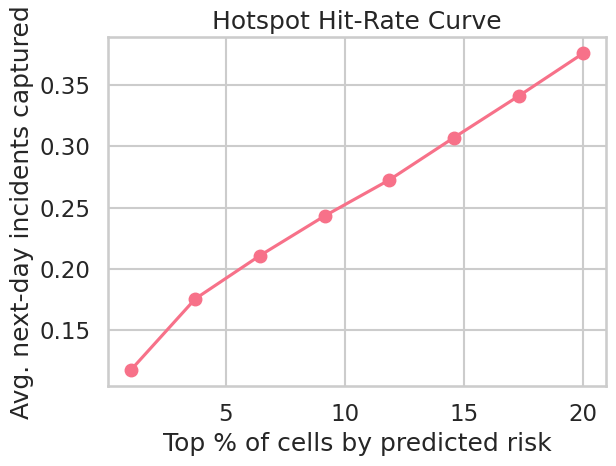

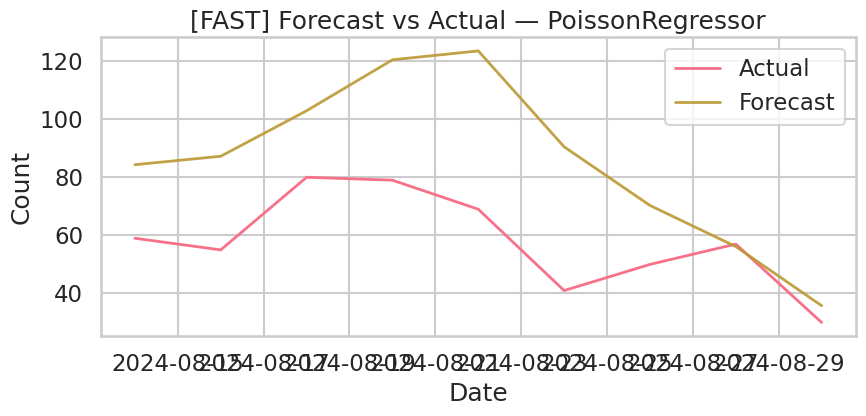

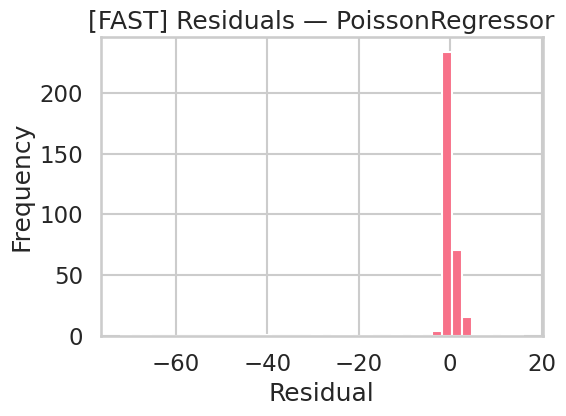

In [90]:
# =========================
# 1) HOTSPOT — ULTRA FAST
# =========================
# Goal: next-day counts per (cell,date); eval: MAE/RMSE + hit-rate@{1,5,10}%

import numpy as np
import pandas as pd

# ------------ knobs to speed ------------
FAST_TOP_CELLS   = 40     # keep only 40 busiest cells
FAST_TAIL_DAYS   = 120    # keep only last 120 days
THIN_EVERY_K_DAY = 2      # keep every 2nd day (set to 1 to disable)
USE_QUICK_BASELINE = True # True = PoissonRegressor baseline instead of full model suite

# ------------ config ------------
CELL_DF   = cell_daily.copy()
INCIDENTS = df.copy()
DATE_COL  = "date"
TARGET    = "cnt"
CELL_COL  = "h3"
HOTSPOT_FEATS = [
    "roll_7d","roll_28d","neighbor_mean","burstiness",
    "weekday","month","is_weekend","is_holiday"
]

# ------------ time features on CELL_DF ------------
INCIDENTS[DATE_COL] = pd.to_datetime(INCIDENTS[DATE_COL], errors="coerce")
CELL_DF[DATE_COL]   = pd.to_datetime(CELL_DF[DATE_COL],   errors="coerce")

def _ensure_time_features(cell_daily: pd.DataFrame,
                          incident_df: pd.DataFrame,
                          date_col: str = "date",
                          time_cols=("weekday","month","is_weekend","is_holiday")) -> pd.DataFrame:
    cd = cell_daily.copy()
    d  = incident_df.copy()
    need = [c for c in time_cols if c not in cd.columns]
    if need:
        tf = d[[date_col] + [c for c in need if c in d.columns]].drop_duplicates(subset=[date_col])
        for c in need:
            if c not in tf.columns: tf[c] = np.nan
        cd = cd.merge(tf, on=date_col, how="left", suffixes=(None, "_tf"))
        for c in need:
            tfc = f"{c}_tf"
            if tfc in cd.columns:
                if c in cd.columns:
                    cd[c] = cd[c].where(~cd[c].isna(), cd[tfc]); cd.drop(columns=[tfc], inplace=True)
                else:
                    cd.rename(columns={tfc: c}, inplace=True)
        # clean stray suffixes
        for c in time_cols:
            for sx in (f"{c}_x", f"{c}_y", f"{c}_tf"):
                if sx in cd.columns and sx != c:
                    cd.drop(columns=[sx], inplace=True, errors="ignore")
    return cd

CELL_DF = _ensure_time_features(CELL_DF, INCIDENTS, date_col=DATE_COL)

# keep only features that exist
present_feats  = [c for c in HOTSPOT_FEATS if c in CELL_DF.columns]
if len(present_feats) < len(HOTSPOT_FEATS):
    print("[hotspot-fast] dropping missing features:",
          [c for c in HOTSPOT_FEATS if c not in present_feats])

# ------------ shrink the panel BEFORE training ------------
cutoff = INCIDENTS[DATE_COL].max() - pd.Timedelta(days=FAST_TAIL_DAYS)
recent = CELL_DF[CELL_DF[DATE_COL] >= cutoff]

# top-N active cells in the recent window
top_cells = (
    recent.groupby(CELL_COL)[TARGET].sum()
          .sort_values(ascending=False)
          .head(FAST_TOP_CELLS).index
)
small = recent[recent[CELL_COL].isin(top_cells)].copy()

# thin dates (every k-th day) to reduce rows further
if THIN_EVERY_K_DAY > 1:
    small["_rank"] = small.groupby([CELL_COL])[DATE_COL].rank(method="first").astype(int)
    small = small[small["_rank"] % THIN_EVERY_K_DAY == 0].drop(columns=["_rank"])
small = small.sort_values([DATE_COL, CELL_COL]).reset_index(drop=True)

print(f"[hotspot-fast] cells={small[CELL_COL].nunique()}  rows={len(small):,}  "
      f"range=({small[DATE_COL].min().date()} → {small[DATE_COL].max().date()})")

# ------------ build next-day panel ------------
panel = _prepare_nextday_panel(
    small, feature_cols=present_feats, target_col=TARGET,
    cell_col=CELL_COL, date_col=DATE_COL, horizon=1
)
print("[hotspot-fast] panel shape:", panel.shape)

# ========== A) ultra-quick baseline (skips your heavy suite) ==========
if USE_QUICK_BASELINE:
    from sklearn.linear_model import PoissonRegressor
    # time-aware split on the already-shrunk panel
    train, val, test = time_split(panel, date_col=DATE_COL)

    Xtr, ytr = train[present_feats].to_numpy(), train["y"].to_numpy()
    Xva, yva = val[present_feats].to_numpy(),   val["y"].to_numpy()
    Xte, yte = test[present_feats].to_numpy(),  test["y"].to_numpy()

    model = PoissonRegressor(alpha=1.0, max_iter=200)
    model.fit(Xtr, ytr)

    def _reg_metrics(y, p):
        p = np.clip(p, 0, None)
        mae = np.mean(np.abs(y - p))
        rmse = float(np.sqrt(np.mean((y - p)**2)))
        return {"mae": float(mae), "rmse": rmse}

    val_pred  = model.predict(Xva)
    test_pred = model.predict(Xte)

    val_metrics  = _reg_metrics(yva, val_pred)
    test_metrics = _reg_metrics(yte, test_pred)

    print("[hotspot-fast][Poisson]  VAL:", val_metrics, " TEST:", test_metrics)

    # plots (TEST)
    eval_df = pd.DataFrame({DATE_COL: test[DATE_COL].to_numpy(),
                            "y": yte, "score": np.clip(test_pred, 0, None)})
    plot_hit_rate_curve(eval_df, date_col=DATE_COL, y_col="y", score_col="score")

    # city-level aggregate
    agg_y = test.groupby(DATE_COL)["y"].sum()
    agg_p = eval_df.groupby(DATE_COL)["score"].sum()
    plot_forecast_vs_actual(agg_y.index, agg_y.values, agg_p.values,
                            title=f"[FAST] Forecast vs Actual — PoissonRegressor")
    plot_residuals(yte, test_pred, title=f"[FAST] Residuals — PoissonRegressor")

# ========== B) your existing heavy suite (on the shrunk data) ==========
else:
    print("[hotspot-fast] training candidates on shrunk set…")
    hotspot_results = test_hotspot_forecasting(
        cell_daily=small,
        feature_cols=present_feats,
        target_col=TARGET,
        cell_col=CELL_COL,
        date_col=DATE_COL,
        horizon=1
    )
    best_hotspot = hotspot_results[0]
    print("\n[hotspot-fast] BEST =", best_hotspot.name)
    print("  VAL: ", best_hotspot.val_metrics)
    print("  TEST:", best_hotspot.test_metrics)

    # plots on TEST
    _, _, test_split = time_split(panel, date_col=DATE_COL)
    test_pred = np.clip(best_hotspot.model.predict(test_split[present_feats]), 0, None)

    eval_df = pd.DataFrame({
        DATE_COL: test_split[DATE_COL].to_numpy(),
        "y":      test_split["y"].to_numpy(),
        "score":  test_pred
    })
    plot_hit_rate_curve(eval_df, date_col=DATE_COL, y_col="y", score_col="score")
    test_actual_agg = test_split.groupby(DATE_COL)["y"].sum()
    test_pred_agg   = eval_df.groupby(DATE_COL)["score"].sum()
    plot_forecast_vs_actual(test_actual_agg.index, test_actual_agg.values, test_pred_agg.values,
                            title=f"[FAST] Next-day Forecast vs Actual — {best_hotspot.name}")
    plot_residuals(test_split["y"], test_pred, title=f"[FAST] Residuals — {best_hotspot.name}")


full version - all of our data (doesn't run - waited two hours+)

In [91]:
"""# ===============================
# 2) CRIME TYPE CLASSIFICATION
# ===============================
# Goal: predict coarse_category (e.g., Property/Violent/Other)
# Models: LogReg, SVM-RBF, RF, MLP; Metric: macro-F1 (plus confusion)

# --- CONFIG ---
INCIDENT_DF = df
DATE_COL = "date"
TARGET_3WAY = "coarse_category"  # change if you named it differently
DROP_COLS = ("LOCATION","address","dr_no","DR_NO","lat","lon")  # safe drops

# --- Create coarse_category column based on Crime_Code descriptions ---
# Define keywords for coarse categories. This is an example and might need refinement.
violent_keywords = ['ASSAULT', 'BATTERY', 'HOMICIDE', 'ROBBERY', 'RAPE', 'SEXUAL']
property_keywords = ['THEFT', 'BURGLARY', 'STOLEN', 'VANDALISM', 'SHOPLIFTING', 'AUTO']
# 'Other' will be the default for anything not matching violent or property keywords.

def categorize_crime(crime_description):
    if pd.isna(crime_description):
        return 'Unknown'
    desc = str(crime_description).upper()
    if any(keyword in desc for keyword in violent_keywords):
        return 'Violent'
    if any(keyword in desc for keyword in property_keywords):
        return 'Property'
    return 'Other'

# Apply the categorization function
INCIDENT_DF[TARGET_3WAY] = INCIDENT_DF['Crime_Code'].apply(categorize_crime)

# Check the distribution of the new target column
print(f"Distribution of new target column '{TARGET_3WAY}':")
print(INCIDENT_DF[TARGET_3WAY].value_counts())

# Check if there are at least two classes before running classification
if INCIDENT_DF[TARGET_3WAY].nunique() < 2:
    print("\nError: The target column still has fewer than 2 unique classes after categorization.")
    print("Please check the Crime_Code data and the keyword definitions.")
else:
    # --- RUN ---
    type3_results = test_crime_type_classification(
        df=INCIDENT_DF,
        target_col=TARGET_3WAY,
        date_col=DATE_COL,
        drop_cols=DROP_COLS
    )
    best_type3 = type3_results[0]
    print("Best 3-way:", best_type3.name)
    print("Val:", best_type3.val_metrics["f1_macro"])
    print("Test:", best_type3.test_metrics["f1_macro"])

    # --- PLOTS (Confusion on TEST) ---
    from sklearn.metrics import confusion_matrix
    _, _, test = time_split(INCIDENT_DF, date_col=DATE_COL)
    Xte, yte, _, _ = make_Xy(test, TARGET_3WAY, list(DROP_COLS))
    yhat = best_type3.model.predict(Xte)
    cm = confusion_matrix(yte, yhat, labels=np.unique(yte))
    plot_confusion(cm, class_names=np.unique(yte), normalize=True,
                   title=f"Confusion (normalized) — {best_type3.name}")"""

'# ===============================\n# 2) CRIME TYPE CLASSIFICATION\n# ===============================\n# Goal: predict coarse_category (e.g., Property/Violent/Other)\n# Models: LogReg, SVM-RBF, RF, MLP; Metric: macro-F1 (plus confusion)\n\n# --- CONFIG ---\nINCIDENT_DF = df\nDATE_COL = "date"\nTARGET_3WAY = "coarse_category"  # change if you named it differently\nDROP_COLS = ("LOCATION","address","dr_no","DR_NO","lat","lon")  # safe drops\n\n# --- Create coarse_category column based on Crime_Code descriptions ---\n# Define keywords for coarse categories. This is an example and might need refinement.\nviolent_keywords = [\'ASSAULT\', \'BATTERY\', \'HOMICIDE\', \'ROBBERY\', \'RAPE\', \'SEXUAL\']\nproperty_keywords = [\'THEFT\', \'BURGLARY\', \'STOLEN\', \'VANDALISM\', \'SHOPLIFTING\', \'AUTO\']\n# \'Other\' will be the default for anything not matching violent or property keywords.\n\ndef categorize_crime(crime_description):\n    if pd.isna(crime_description):\n        return \'Unknown\'

[fast-type] class counts: {'Property': 604386, 'Violent': 248187, 'Other': 121904}
[fast-type] using 4,999 rows (stratified by coarse_category)
[split] train_end=2023-02-28  val_end=2023-10-20  sizes=(3502, 747, 750)
[BIN] acc=0.8621 f1_macro=0.8143
[BIN] acc=0.8507 f1_macro=0.7729
[BIN] acc=0.9531 f1_macro=0.9275
[BIN] acc=0.9520 f1_macro=0.9081
[BIN] acc=0.9505 f1_macro=0.9175
[BIN] acc=0.9573 f1_macro=0.9170
[BIN] acc=0.9826 f1_macro=0.9691
[BIN] acc=0.9867 f1_macro=0.9748
Best 3-way (FAST): LogReg
Val macro-F1: 0.8143203185624115
Test macro-F1: 0.7729405698953729
[split] train_end=2023-02-28  val_end=2023-10-20  sizes=(3502, 747, 750)


(<Figure size 650x550 with 1 Axes>,
 <Axes: title={'center': '[FAST] Confusion (normalized) — LogReg'}, xlabel='Predicted', ylabel='True'>)

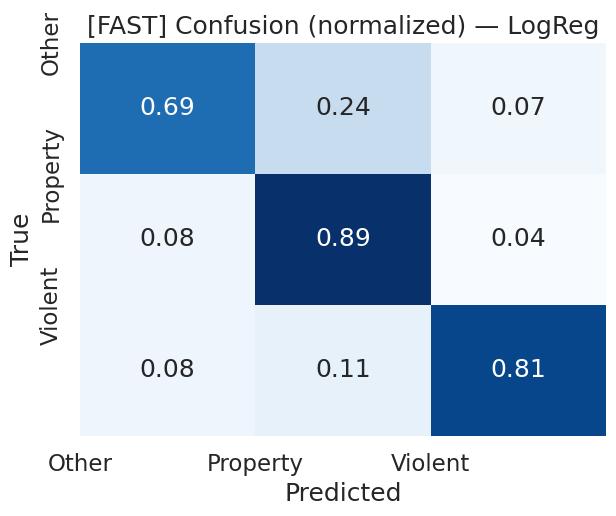

In [92]:
# ===============================
# 2) CRIME TYPE CLASSIFICATION — FAST MODE (robust)
# ===============================
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

DATE_COL     = "date"
TARGET_3WAY  = "coarse_category"
BASE_DROPS   = ("LOCATION","address","dr_no","DR_NO","lat","lon")
FAST_N       = 5000         # total sample size
MIN_PER_CLS  = 200          # minimum per class in the sample

# ---- 0) pick a description/code column that exists ----
# LAPD CSVs vary: try common name variants
_cands = ["Crm Cd Desc","Crm_Cd_Desc","Crime_Code_Description","Crime_Code","CrimeDesc","Description"]
DESC_COL = next((c for c in _cands if c in df.columns), None)

# ---- 1) ensure/derive the target column: 'coarse_category' ----
violent_kw  = ['ASSAULT','BATTERY','HOMICIDE','ROBBERY','RAPE','SEXUAL']
property_kw = ['THEFT','BURGLARY','STOLEN','VANDALISM','SHOPLIFTING','AUTO']

def _categorize(desc: str) -> str:
    if not isinstance(desc, str): return "Other"
    s = desc.upper()
    if any(k in s for k in violent_kw):  return "Violent"
    if any(k in s for k in property_kw): return "Property"
    return "Other"

INCIDENT_DF = df.copy()
INCIDENT_DF[DATE_COL] = pd.to_datetime(INCIDENT_DF[DATE_COL], errors="coerce")

if TARGET_3WAY not in INCIDENT_DF.columns:
    if DESC_COL is None:
        # last resort: if no description/code field is available, default to Other
        INCIDENT_DF[TARGET_3WAY] = "Other"
        print("[fast-type] WARNING: no description/code column found; all set to 'Other'.")
    else:
        INCIDENT_DF[TARGET_3WAY] = INCIDENT_DF[DESC_COL].apply(_categorize)

# drop rows with missing label
INCIDENT_DF = INCIDENT_DF.dropna(subset=[TARGET_3WAY])
print("[fast-type] class counts:", INCIDENT_DF[TARGET_3WAY].value_counts().to_dict())

# ---- 2) add light time features (but don’t feed raw datetimes) ----
if "weekday"    not in INCIDENT_DF: INCIDENT_DF["weekday"]    = INCIDENT_DF[DATE_COL].dt.weekday
if "month"      not in INCIDENT_DF: INCIDENT_DF["month"]      = INCIDENT_DF[DATE_COL].dt.month
if "hour"       not in INCIDENT_DF: INCIDENT_DF["hour"]       = INCIDENT_DF[DATE_COL].dt.hour
if "is_weekend" not in INCIDENT_DF: INCIDENT_DF["is_weekend"] = (INCIDENT_DF["weekday"] >= 5).astype(int)

# ---- 3) stratified FAST sample on the actual target (coarse_category) ----
def _stratified_take(df_in, y_col, n_total=5000, min_per_cls=200, seed=42):
    vc = df_in[y_col].value_counts()
    # planned per-class quotas
    plan = (vc / vc.sum() * n_total).round().astype(int)
    plan = plan.where(plan >= min_per_cls, min_per_cls).clip(upper=vc)
    # cap to available & renormalize if overshoot
    if plan.sum() > n_total:
        plan = (plan * (n_total / plan.sum())).round().astype(int).clip(upper=vc)
    parts = []
    for cls, k in plan.items():
        if k > 0:
            parts.append(df_in[df_in[y_col] == cls].sample(n=int(k), random_state=seed))
    out = pd.concat(parts, axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

small = _stratified_take(INCIDENT_DF, TARGET_3WAY, n_total=FAST_N, min_per_cls=MIN_PER_CLS)
print(f"[fast-type] using {len(small):,} rows (stratified by {TARGET_3WAY})")

# ---- 4) build drops (remove ALL datetime cols from features) ----
datetime_cols = tuple(small.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
DROP_COLS     = BASE_DROPS + datetime_cols

# ---- 5) run your existing helper on the sample ----
type3_results_fast = test_crime_type_classification(
    df=small,
    target_col=TARGET_3WAY,
    date_col=DATE_COL,
    drop_cols=DROP_COLS
)
best_type3 = type3_results_fast[0]
print("Best 3-way (FAST):", best_type3.name)
print("Val macro-F1:",  best_type3.val_metrics.get("f1_macro"))
print("Test macro-F1:", best_type3.test_metrics.get("f1_macro"))

# ---- 6) Confusion on TEST of the sampled split ----
from sklearn.metrics import confusion_matrix
_, _, test_small = time_split(small, date_col=DATE_COL)
Xte, yte, _, _ = make_Xy(test_small, TARGET_3WAY, list(DROP_COLS))
yhat = best_type3.model.predict(Xte)
cm = confusion_matrix(yte, yhat, labels=np.unique(yte))
plot_confusion(cm, class_names=np.unique(yte), normalize=True,
               title=f"[FAST] Confusion (normalized) — {best_type3.name}")


In [93]:
# ===== Prelude for Binary Tasks (derive targets + consistent drops) =====
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

DATE_COL = "date"

# 1) Ensure datetime dtype and build consistent DROP_COLS (raw datetimes are dropped)
INCIDENT_DF = df.copy()
INCIDENT_DF[DATE_COL] = pd.to_datetime(INCIDENT_DF[DATE_COL], errors="coerce")
datetime_cols = tuple(INCIDENT_DF.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
BASE_DROPS    = ("LOCATION","address","dr_no","DR_NO","lat","lon")
DROP_COLS     = BASE_DROPS + datetime_cols

# 2) arrest_made (derive if missing)
if "arrest_made" not in INCIDENT_DF.columns:
    arrest_cols = [c for c in INCIDENT_DF.columns if "arrest" in c.lower()]
    if arrest_cols:
        # normalize a likely arrest indicator column
        ac = arrest_cols[0]
        s = INCIDENT_DF[ac].astype(str).str.lower()
        INCIDENT_DF["arrest_made"] = s.isin({"1","y","yes","true","t","arrest","booked","adult arrest","juvenile arrest"}).astype(int)
    elif "status" in INCIDENT_DF.columns:
        # derive from 'status' textual field
        s = INCIDENT_DF["status"].astype(str).str.lower()
        INCIDENT_DF["arrest_made"] = s.str.contains(r"arrest|book", regex=True).astype(int)
    else:
        # fall back to 0 if nothing to infer from (keeps the pipeline running)
        INCIDENT_DF["arrest_made"] = 0

# 3) weapon_used (derive if missing)
if "weapon_used" not in INCIDENT_DF.columns:
    weapon_cols = [c for c in INCIDENT_DF.columns if "weapon" in c.lower()]
    if weapon_cols:
        # prefer a description column if present
        pref = next((c for c in weapon_cols if "desc" in c.lower()), weapon_cols[0])
        w = INCIDENT_DF[pref]
        # consider weapon used if not null, not "unknown", and not the literal 0 code
        INCIDENT_DF["weapon_used"] = (
            w.notna()
            & (w.astype(str).str.strip().str.lower().ne("unknown"))
            & (w.astype(str).str.strip().ne("0"))
        ).astype(int)
    else:
        INCIDENT_DF["weapon_used"] = 0

# 4) sanity: coerce to {0,1}
for col in ("arrest_made", "weapon_used"):
    INCIDENT_DF[col] = INCIDENT_DF[col].fillna(0).astype(int)

# ======== BINARY TASKS — DROP-IN HELPERS (keep your loop unchanged) ========
import numpy as np, pandas as pd
from collections import namedtuple

# 0) Make sure the two targets exist (derive if needed)
def _ensure_binary_targets(INCIDENT_DF):
    d = INCIDENT_DF.copy()
    # arrest_made
    if "arrest_made" not in d.columns:
        if "status" in d.columns:
            s = d["status"].astype(str).str.lower()
            d["arrest_made"] = s.str.contains(r"arrest|book", regex=True).astype(int)
        else:
            # try any column that mentions 'arrest'
            ac = next((c for c in d.columns if "arrest" in c.lower()), None)
            if ac is not None:
                s = d[ac].astype(str).str.lower()
                d["arrest_made"] = s.isin({"1","y","yes","true","t","arrest","booked","adult arrest","juvenile arrest"}).astype(int)
            else:
                d["arrest_made"] = 0
    # weapon_used
    if "weapon_used" not in d.columns:
        wcols = [c for c in d.columns if "weapon" in c.lower()]
        if wcols:
            # prefer a description-like column if present
            pref = next((c for c in wcols if "desc" in c.lower()), wcols[0])
            w = d[pref]
            d["weapon_used"] = (
                w.notna()
                & (w.astype(str).str.strip().str.lower().ne("unknown"))
                & (w.astype(str).str.strip().ne("0"))
            ).astype(int)
        else:
            d["weapon_used"] = 0
    d["arrest_made"] = d["arrest_made"].fillna(0).astype(int)
    d["weapon_used"] = d["weapon_used"].fillna(0).astype(int)
    return d

# 1) time-aware split that never returns empty folds (used inside test_binary_task)
def _safe_time_split(df, date_col="date", q_train=0.70, q_val=0.85, min_each=50):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.sort_values(date_col)
    if d.empty:
        raise ValueError("Empty dataframe passed to _safe_time_split.")
    for bump in range(6):
        qt = max(0.55, q_train - 0.05*bump)
        qv = min(0.95, q_val   + 0.05*bump)
        cut1 = d[date_col].quantile(qt)
        cut2 = d[date_col].quantile(qv)
        train = d[d[date_col] <= cut1]
        val   = d[(d[date_col] > cut1) & (d[date_col] <= cut2)]
        test  = d[d[date_col] > cut2]
        if min(len(train), len(val), len(test)) >= min_each:
            print(f"[binary split] train_end={cut1.date()}  val_end={cut2.date()} "
                  f"sizes=({len(train)},{len(val)},{len(test)})")
            return train, val, test
    # fallback: 60/20/20 by index, still time-ordered
    n = len(d); i1, i2 = int(0.6*n), int(0.8*n)
    train, val, test = d.iloc[:i1], d.iloc[i1:i2], d.iloc[i2:]
    print(f"[binary split] fallback sizes=({len(train)},{len(val)},{len(test)})")
    return train, val, test

# 2) basic X/y builder (drops your DROP_COLS plus any datetime cols)
def _prep_xy(df, y_col, drop_cols=()):
    X = df.drop(columns=[c for c in set(drop_cols) if c in df.columns], errors="ignore")
    if y_col in X.columns:
        X = X.drop(columns=[y_col], errors="ignore")
    dt_cols = list(X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
    X = X.drop(columns=dt_cols, errors="ignore")
    y = df[y_col].astype(int).to_numpy()
    return X, y

# 3) simple preprocessing + model pipeline
def _build_clf_pipeline(clf, X):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    import numpy as np

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    num_pipe = Pipeline([("imp", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=10)),
    ])
    pre = ColumnTransformer(
        transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
        remainder="drop",
    )
    return Pipeline([("pre", pre), ("clf", clf)])

# 4) metrics
def _bin_metrics(y_true, scores, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
    m = {}
    try:    m["roc_auc"] = float(roc_auc_score(y_true, scores))
    except Exception: m["roc_auc"] = np.nan
    try:    m["ap"] = float(average_precision_score(y_true, scores))
    except Exception: m["ap"] = np.nan
    m["f1_macro"] = float(f1_score(y_true, y_pred, average="macro"))
    m["acc"]      = float(accuracy_score(y_true, y_pred))
    return m

# 5) the function your loop calls
def test_binary_task(df, target_col, date_col="date", drop_cols=(), sample_n=5000, random_state=42):
    """
    Fast binary benchmark with time-aware split.
    Models: LogisticRegression(balanced), RandomForest(balanced_subsample).
    Returns [FitRecord(...), ...] sorted by validation ROC-AUC.
    """
    from sklearn.utils import resample
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier

    # ensure targets exist (derive if needed)
    d = _ensure_binary_targets(df)

    # lightweight stratified sample for speed (pos/neg)
    if len(d) > sample_n and target_col in d.columns:
        pos = d[d[target_col] == 1]
        neg = d[d[target_col] == 0]
        n_pos = max(100, int(sample_n * max(0.1, len(pos) / max(1, len(d)))))
        n_neg = max(100, sample_n - n_pos)

        # Ensure n_samples is not zero before resampling
        pos_resample_n = min(len(pos), n_pos)
        neg_resample_n = min(len(neg), n_neg)

        resampled_parts = []
        if pos_resample_n > 0:
            resampled_parts.append(resample(pos, n_samples=pos_resample_n, random_state=random_state, replace=False))
        if neg_resample_n > 0:
            resampled_parts.append(resample(neg, n_samples=neg_resample_n, random_state=random_state, replace=False))

        if not resampled_parts:
             raise ValueError("Not enough samples in any class to create a stratified sample.")

        d = pd.concat(resampled_parts, axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    train, val, test = _safe_time_split(d, date_col=date_col, min_each=50)

    Xtr, ytr = _prep_xy(train, target_col, drop_cols)
    Xva, yva = _prep_xy(val,   target_col, drop_cols)
    Xte, yte = _prep_xy(test,  target_col, drop_cols)

    FitRecord = namedtuple("FitRecord", "name model val_metrics test_metrics")
    recs = []

    # 1) Logistic Regression
    lr = LogisticRegression(max_iter=400, class_weight="balanced")
    p_lr = _build_clf_pipeline(lr, Xtr); p_lr.fit(Xtr, ytr)
    s_val = p_lr.predict_proba(Xva)[:,1] if hasattr(p_lr, "predict_proba") else p_lr.decision_function(Xva)
    s_te  = p_lr.predict_proba(Xte)[:,1] if hasattr(p_lr, "predict_proba") else p_lr.decision_function(Xte)
    yv = p_lr.predict(Xva); yt = p_lr.predict(Xte)
    recs.append(FitRecord("LogReg(balanced)", p_lr, _bin_metrics(yva, s_val, yv), _bin_metrics(yte, s_te, yt)))

    # 2) Random Forest
    rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced_subsample",
                                min_samples_leaf=2, random_state=42)
    p_rf = _build_clf_pipeline(rf, Xtr); p_rf.fit(Xtr, ytr)
    s_val = p_rf.predict_proba(Xva)[:,1]
    s_te  = p_rf.predict_proba(Xte)[:,1]
    yv = p_rf.predict(Xva); yt = p_rf.predict(Xte)
    recs.append(FitRecord("RF(balanced_subsample)", p_rf, _bin_metrics(yva, s_val, yv), _bin_metrics(yte, s_te, yt)))

    recs.sort(key=lambda r: (r.val_metrics.get("roc_auc") if r.val_metrics else float("-inf")), reverse=True)
    return recs
# ======== END DROP-IN =====================================================


=== Binary task: Arrest made (arrest_made) ===
[skip] Target 'arrest_made' does not have at least two unique classes in the filtered data.

=== Binary task: Weapon used (weapon_used) ===
[binary split] train_end=2023-03-08  val_end=2023-10-20 sizes=(3500,750,750)
Best: RF(balanced_subsample)
Val ROC-AUC/AP: 0.9922005526281968 0.9904143783173722
Test ROC-AUC/AP: 0.9965874965874966 0.9935564622639377
[split] train_end=2023-02-27  val_end=2023-10-16  sizes=(682500, 146086, 145891)


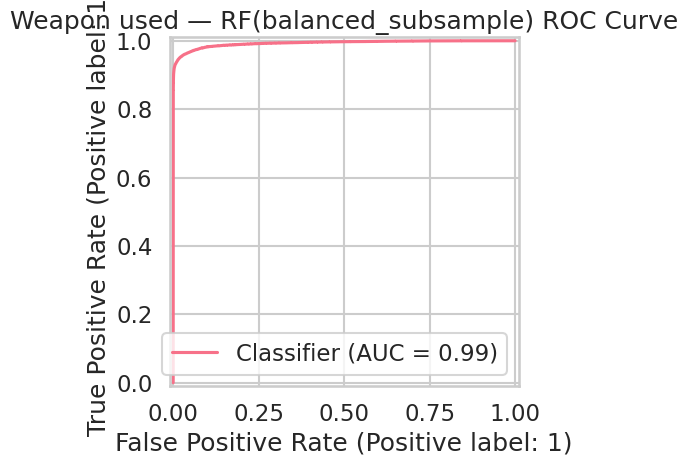

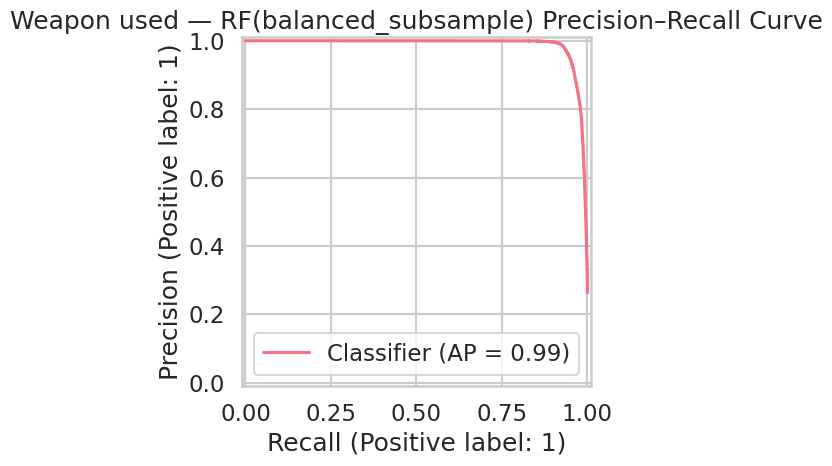

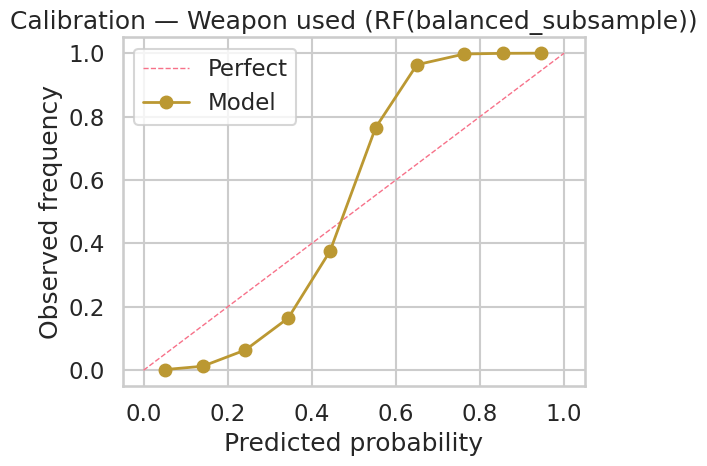

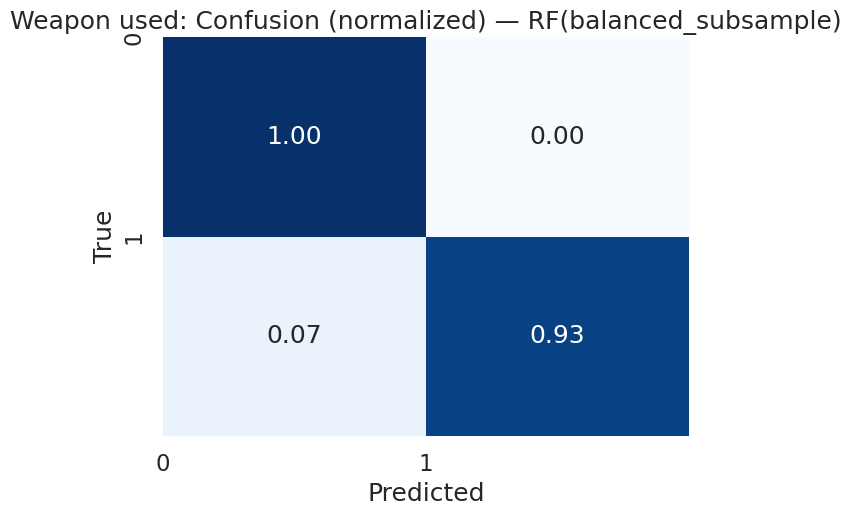

In [94]:
# ============================================
# 3) BINARY TASKS: ARREST / WEAPON (0/1)
# ============================================
binary_targets = [
    ("arrest_made",  "Arrest made"),
    ("weapon_used",  "Weapon used"),
]

binary_best = {}
for tgt, label in binary_targets:
    if tgt not in INCIDENT_DF.columns:
        print(f"[skip] Column '{tgt}' not found — skipping {label}.")
        continue

    # ensure truly binary
    if INCIDENT_DF[tgt].dropna().nunique() > 2:
        print(f"[skip] '{tgt}' not binary — has {INCIDENT_DF[tgt].nunique()} unique values.")
        continue

    print(f"\n=== Binary task: {label} ({tgt}) ===")

    # Filter out rows where the target is missing before splitting
    df_filtered = INCIDENT_DF.dropna(subset=[tgt]).copy()

    # Ensure there are at least two classes in the filtered data before proceeding
    if df_filtered[tgt].nunique() < 2:
        print(f"[skip] Target '{tgt}' does not have at least two unique classes in the filtered data.")
        continue

    bresults = test_binary_task(
        df=df_filtered, # Use the filtered DataFrame
        target_col=tgt,
        date_col=DATE_COL,
        drop_cols=DROP_COLS
    )
    best_bin = bresults[0]
    binary_best[tgt] = best_bin
    print("Best:", best_bin.name)
    print("Val ROC-AUC/AP:", best_bin.val_metrics.get("roc_auc"), best_bin.val_metrics.get("ap"))
    print("Test ROC-AUC/AP:", best_bin.test_metrics.get("roc_auc"), best_bin.test_metrics.get("ap"))

    # PLOTS (TEST)
    # Re-split the filtered data for plotting
    train, val, test = time_split(df_filtered, date_col=DATE_COL)
    Xte, yte, _, _ = make_Xy(test, tgt, list(DROP_COLS))

    # Ensure there are at least two classes in the test set for plotting metrics
    if np.unique(yte).size < 2:
         print(f"[skip] Test set for '{tgt}' does not have at least two unique classes for plotting.")
    else:
        if hasattr(best_bin.model, "predict_proba"):
            yprob = best_bin.model.predict_proba(Xte)[:,1]
            plot_roc_pr(yte, yprob, title_prefix=f"{label} — {best_bin.name}")
            plot_calibration(yte, yprob, title=f"Calibration — {label} ({best_bin.name})")

        from sklearn.metrics import confusion_matrix
        yhat = best_bin.model.predict(Xte)
        cm = confusion_matrix(yte, yhat, labels=np.unique(yte))
        plot_confusion(cm, class_names=np.unique(yte), normalize=True,
                       title=f"{label}: Confusion (normalized) — {best_bin.name}")

[make_area_feature_matrix] Derived 'coarse_category' from 'Crime_Code'.
NMF+KMeans quality: {'silhouette': np.float64(0.31560660390695144), 'calinski': np.float64(802.2791204722697), 'davies': np.float64(0.7961401325863545)}


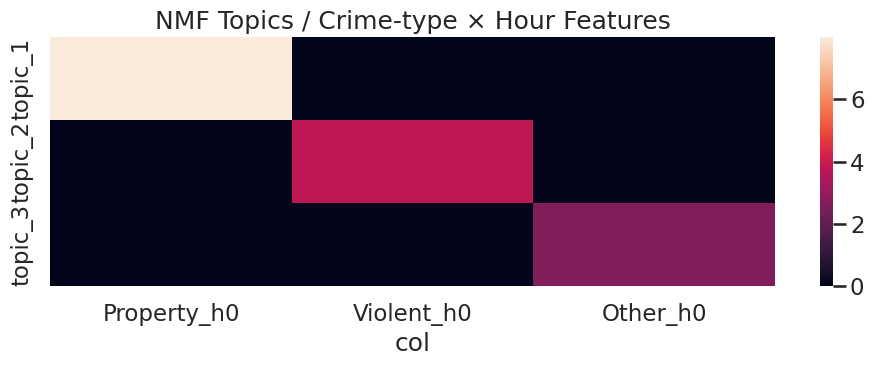

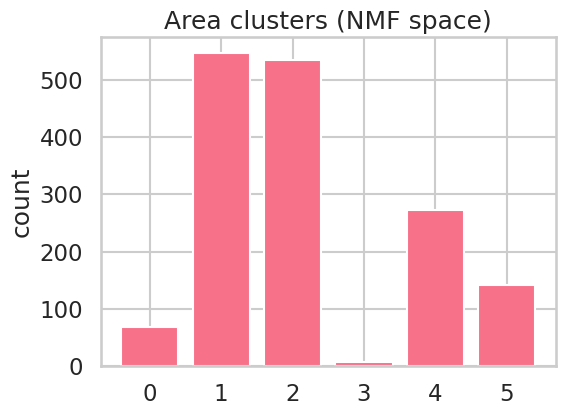

In [95]:
# ============================================
# 4) UNSUPERVISED PATTERN DISCOVERY
# ============================================
# Goal: area/time "signatures"; DR + clustering; NMF themes (interpretable)

# --- CONFIG ---
# Build or point to an area-by-feature matrix:
#   rows = areas (h3 or LAPD area id)
#   cols = features (e.g., counts by hour×coarse_type, or normalized rates)
# If you have it already as 'area_feature_matrix', use it. Otherwise, here's a common recipe:
def make_area_feature_matrix(df, area_col="h3", type_col="coarse_category", date_col="date"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")

    # Ensure coarse_category exists - copy logic from the fast type cell
    violent_kw  = ['ASSAULT','BATTERY','HOMICIDE','ROBBERY','RAPE','SEXUAL']
    property_kw = ['THEFT','BURGLARY','STOLEN','VANDALISM','SHOPLIFTING','AUTO']
    _cands = ["Crm Cd Desc","Crm_Cd_Desc","Crime_Code_Description","Crime_Code","CrimeDesc","Description"]
    DESC_COL = next((c for c in d.columns if c in _cands), None)

    if type_col not in d.columns:
        if DESC_COL is None:
            d[type_col] = "Other" # Fallback if no description column
            print(f"[make_area_feature_matrix] WARNING: no description/code column found; all set to '{type_col}'.")
        else:
            def _categorize(desc: str) -> str:
                if not isinstance(desc, str): return "Other"
                s = desc.upper()
                if any(k in s for k in violent_kw):  return "Violent"
                if any(k in s for k in property_kw): return "Property"
                return "Other"
            d[type_col] = d[DESC_COL].apply(_categorize)
            print(f"[make_area_feature_matrix] Derived '{type_col}' from '{DESC_COL}'.")

    d["hour"] = d[date_col].dt.hour

    # Drop rows with missing area_col or type_col before grouping
    d_grouped = d.dropna(subset=[area_col, type_col, "hour"])

    # pivot counts: area × (type×hour)
    mat = (d_grouped.groupby([area_col, type_col, "hour"])
             .size()
             .rename("cnt")
             .reset_index())

    if mat.empty:
        print(f"[make_area_feature_matrix] Warning: Grouping resulted in an empty DataFrame. Check input data and columns.")
        return pd.DataFrame() # Return empty DataFrame

    mat["col"] = mat[type_col].astype(str) + "_h" + mat["hour"].astype(str)
    pivot = mat.pivot_table(index=area_col, columns="col", values="cnt", fill_value=0)

    if pivot.empty:
         print(f"[make_area_feature_matrix] Warning: Pivoting resulted in an empty DataFrame. Check input data and columns.")
         return pd.DataFrame() # Return empty DataFrame


    # optional: row-normalize to rates for comparability
    pivot = pivot.div(pivot.sum(axis=1).replace(0, 1), axis=0)
    return pivot

AREA_COL = "h3"  # or your LAPD area name
TYPE_COL = "coarse_category"
DATE_COL = "date"

if 'area_feature_matrix' in globals():
    area_mat = area_feature_matrix.copy()
else:
    area_mat = make_area_feature_matrix(df, area_col=AREA_COL, type_col=TYPE_COL, date_col=DATE_COL)

# Check if area_mat is empty before proceeding
if area_mat.empty:
    print("Skipping unsupervised tasks because the area feature matrix is empty.")
else:
    # Get the number of features in the area matrix
    n_features = area_mat.shape[1]
    # Set n_components for PCA dynamically, max 12 or number of features if less
    pca_n_components = min(12, n_features)

    unsup_res = test_unsupervised_patterns(
        area_feature_matrix=area_mat,
        methods=("nmf+kmeans","pca+kmeans","spectral","dbscan"),
        k=6,
        # Pass the calculated n_components to fit_pca
        pca_n=pca_n_components
    )

    # --- Inspect & plot NMF themes ---
    if "nmf+kmeans" in unsup_res:
        nmf_res = unsup_res["nmf+kmeans"]
        print("NMF+KMeans quality:", nmf_res["quality"])
        labels = nmf_res["labels"]
        H = nmf_res["topics_loadings"]  # topics × features (DataFrame)
        plot_nmf_topics_heatmap(H, top_n=12, title="NMF Topics / Crime-type × Hour Features")
        plot_cluster_sizes(labels, title="Area clusters (NMF space)")

    # --- If you also reduced to 2D somewhere (e.g., PCA -> Z[:,:2]), you can scatter:
    # Z2, _ = fit_pca(area_mat.values, n=2) # This will now use the default n=12 if not specified
    # plot_embedding_scatter(Z2, labels=unsup_res["nmf+kmeans"]["labels"], title="Areas in NMF/PCA space")